In [2]:
import gym
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

seed = 0

# Helper Function for Visualization

In [3]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# PPO Agent with softmax policy

## CLIPPE LOSS
### $L^{CLIP} = \frac{1}{N}\sum_{i} \min(r_i\cdot G_i,\text{clip}(r_i,1-\epsilon,1+\epsilon)\cdot G_{i}) $
### Return : $G_i = \sum_{k=0} \gamma^{k}R_{i+1+k}$
### Ratio : $r_i = \frac{\pi_{new}(a_i|s_i)}{\pi_{old}(a_i|s_i)} = \exp(\log(\pi_{new}(a_{i}|s_{i})) - \log(\pi_{old}(a_{i}|s_{i})))$

In [3]:
class PPOAgent_softmax(object):
    def __init__(self, obs_dim, n_act,
                 epochs=10, lr=3e-5, hdim=64,
                 clip_value=0.2,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.n_act = n_act
        
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        
        self.clip_value = clip_value
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss_train_op()
            self._kl_entropy()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.int32, (None, ), 'act')
        self.score_ph = tf.placeholder(tf.float32, (None,), 'score')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
        self.old_logits_ph = tf.placeholder(tf.float32, (None,self.n_act), 'old_logits')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        self.logits = tf.layers.dense(out, self.n_act,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="logits")
        
        # SOFTMAX POLICY
        self.pi = tf.nn.softmax(self.logits)
        
        # SAMPLE OPERATION
        categorical = tf.contrib.distributions.Categorical(logits=self.logits)
        self.sample_action = categorical.sample(1,seed=self.seed)
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER        
        one_hot_act = tf.one_hot(self.act_ph,self.n_act)
        
        # 
        self.log_p = 
        
        #
        self.log_p_old = 
        
    def _loss_train_op(self):
        
        # REINFORCE OBJECTIVE
        ratio = 
        cliped_ratio = 
        self.loss = -tf.reduce_mean(tf.minimum(self.score_ph*ratio,self.score_ph*cliped_ratio))
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _kl_entropy(self):
        
        pi = self.pi
        pi_old = tf.nn.softmax(self.old_logits_ph)
                
        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(pi_old*(tf.log(pi_old)-tf.log(pi)),axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = -tf.reduce_sum(pi*tf.log(pi),axis=1) # sum -p*log(p)
        self.entropy = tf.reduce_mean(entropy) # average over Batch
        
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action[0]
    
    def control(self, obs): # COMPUTE MEAN
        feed_dict = {self.obs_ph: obs}
        best_action = np.argmax(self.sess.run(self.pi,feed_dict=feed_dict))
        return best_action        
    
    def update(self, observes, actions, scores, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_logits = self.sess.run(self.logits,{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        for e in range(self.epochs):
            observes, actions, scores, old_logits = shuffle(observes, actions, scores, old_logits, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end],
                     self.score_ph: scores[start:end],
                     self.old_logits_ph: old_logits[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.score_ph: scores,
             self.old_logits_ph: old_logits,
             self.lr_ph: self.lr}               
        loss, kl, entropy  = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
        return loss, kl, entropy
    
    def close_sess(self):
        self.sess.close()

# Helper Function for Training 

In [4]:
def run_episode(env, policy, animate=False, evaluation=False): # Run policy and collect (state, action, reward) pairs
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        
        action = agent.get_action(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.array(actions), np.array(rewards, dtype=np.float32), infos)

def run_policy(env, agent, episodes): # collect trajectories. if 'evaluation' is ture, then only mean value of policy distribution is used without sampling.
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, agent)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

def build_train_set(trajectories):
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    returns = np.concatenate([t['returns'] for t in trajectories])
    
    return observes, actions, returns

def compute_returns(trajectories, gamma=0.995): # Add value estimation for each trajectories
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        returns = np.zeros_like(rewards)
        g = 0
        for t in reversed(range(len(rewards))):
            g = rewards[t] + gamma*g
            returns[t] = g
        trajectory['returns'] = returns

# Training

In [5]:
env = gym.make('CartPole-v1')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
n_act = env.action_space.n

agent = PPOAgent_softmax(obs_dim, n_act, epochs=5, hdim=32, clip_value=0.5, lr=3e-4,seed=seed)

#
avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)

episode_size = 1
batch_size = 32
nupdates = 1000

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episodes=episode_size)
    compute_returns(trajectories)
    observes, actions, returns = build_train_set(trajectories)

    pol_loss, kl, entropy = agent.update(observes, actions, returns, batch_size=batch_size)

    avg_loss_list.append(pol_loss)
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%200) == 0:
        print('[{}/{}] return : {:.3f},  policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(
            update, nupdates, np.mean(avg_return_list), np.mean(avg_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > 495): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
Use the retry module or similar alternatives.
[0/1000] return : 14.000,  policy loss : -7.345, policy kl : 0.00000, policy entropy : 0.693
[200/1000] return : 174.300,  policy loss : -66.226, policy kl : 0.00094, policy entropy : 0.521
[400/1000] return : 410.700,  policy loss : -114.062, policy kl : 0.01656, policy entropy : 0.501
[409/1000] return : 500.000, policy loss : -128.238
The problem is solved with 409 episodes


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 500.00



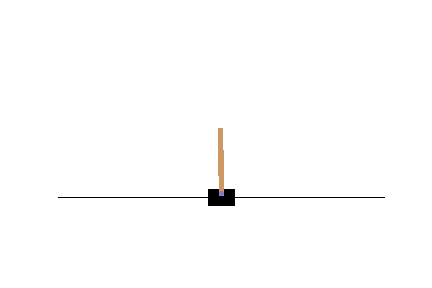
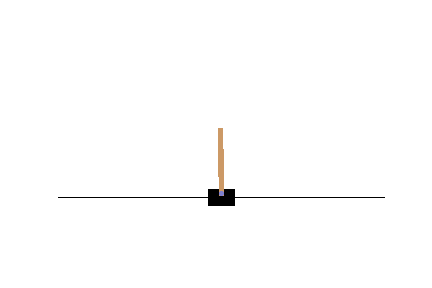
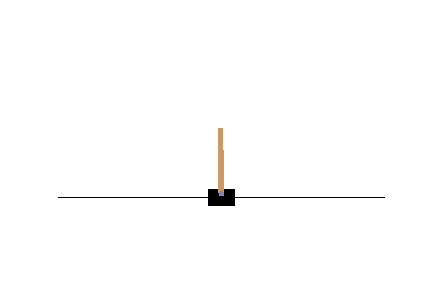
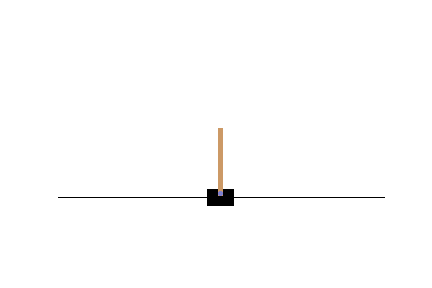
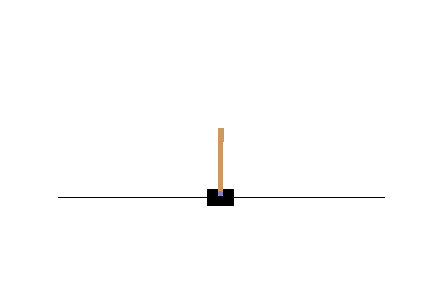
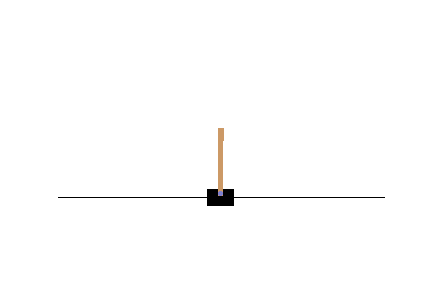
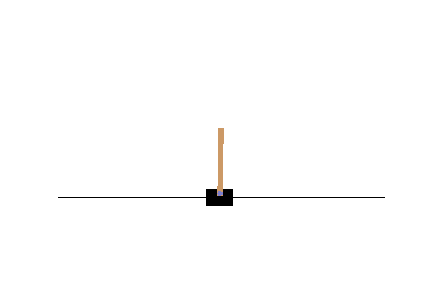
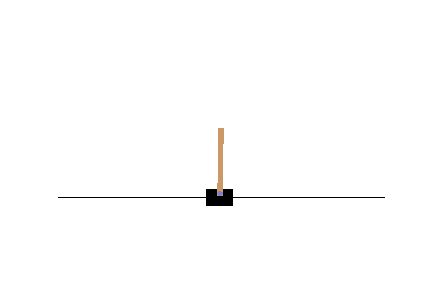
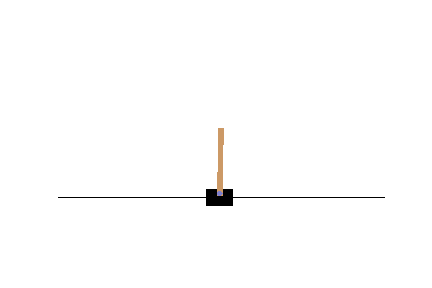
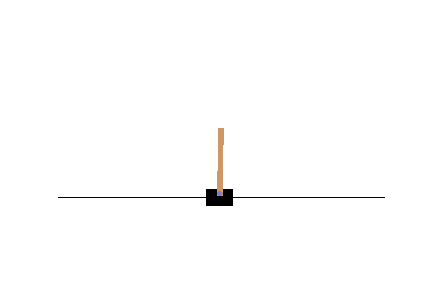
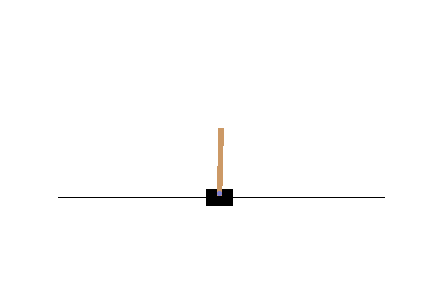
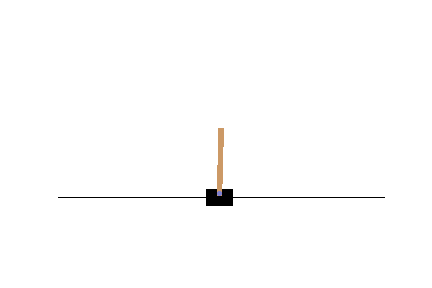
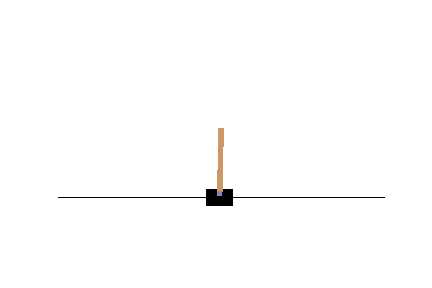
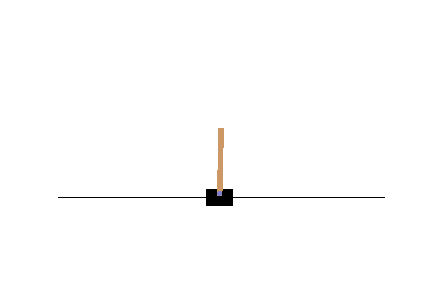
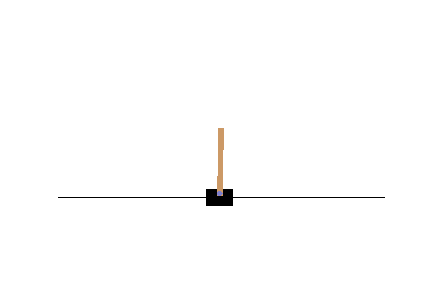
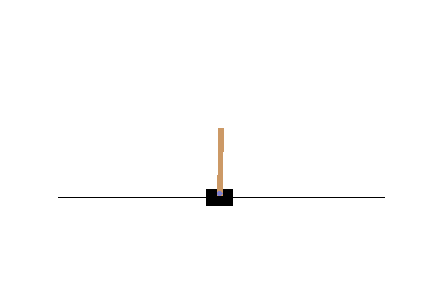
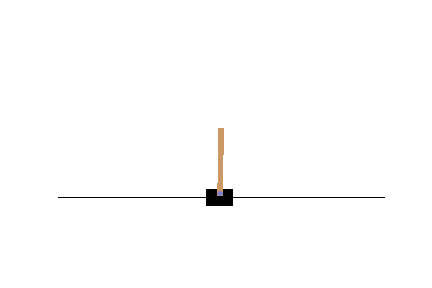
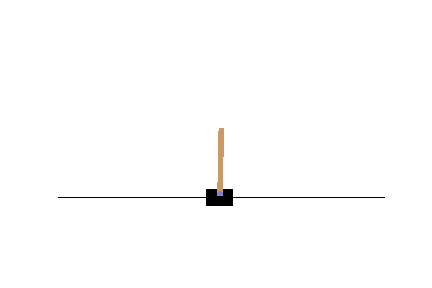
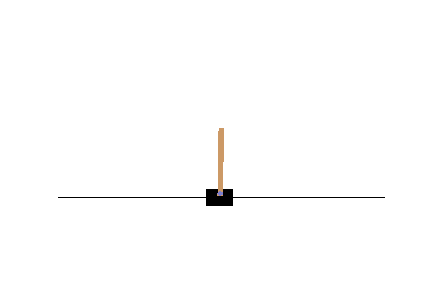
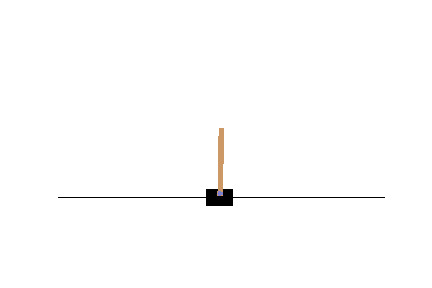
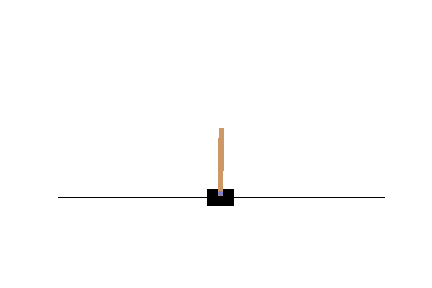
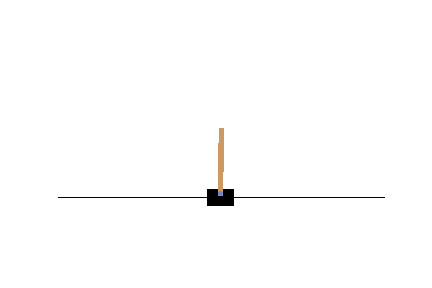
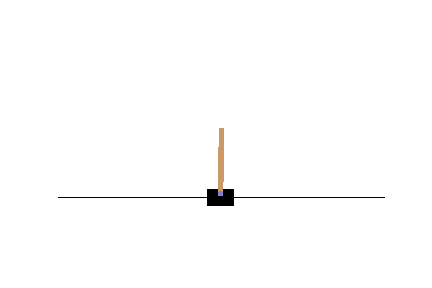
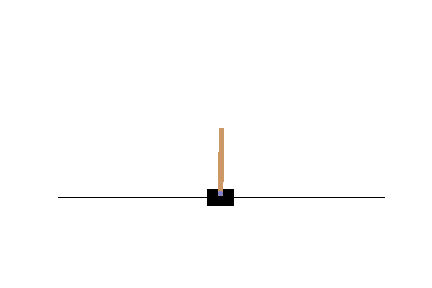
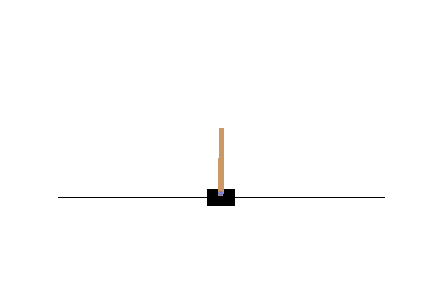
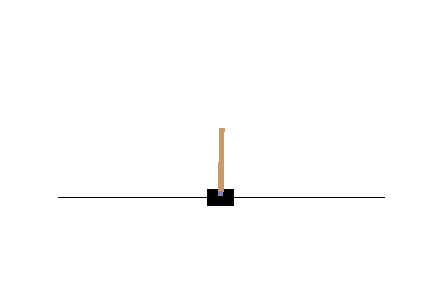
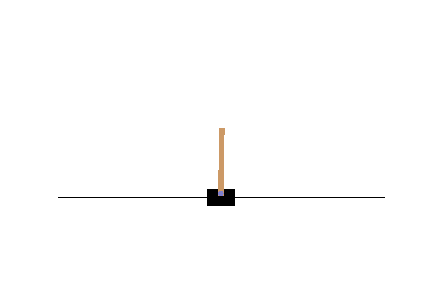
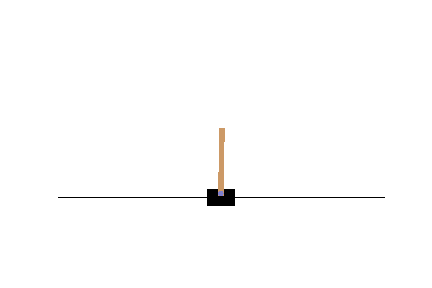
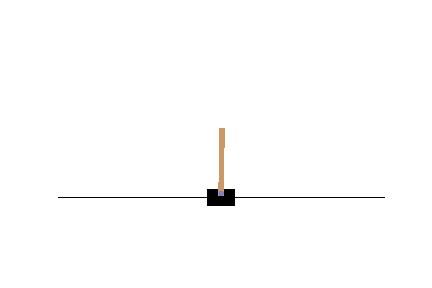
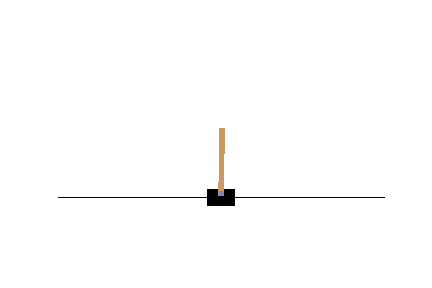
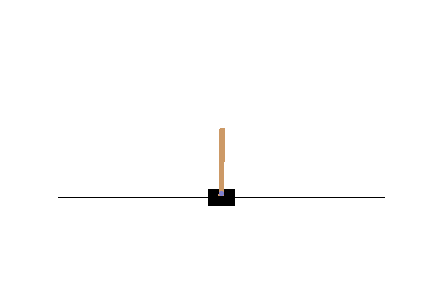
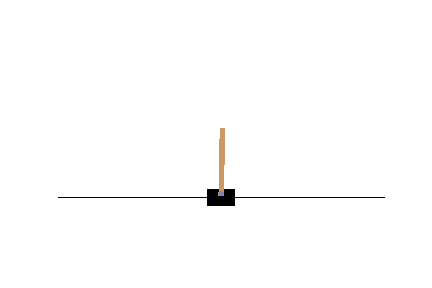
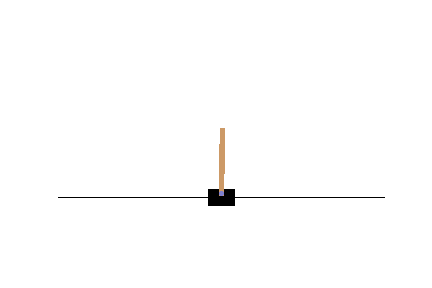
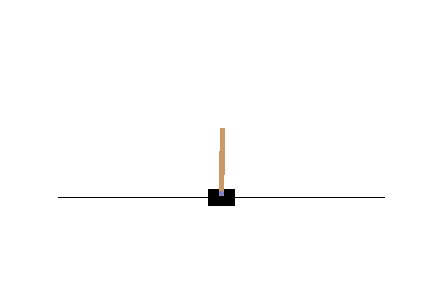
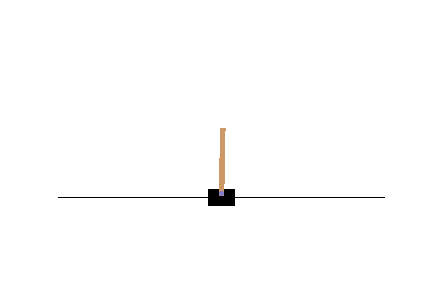
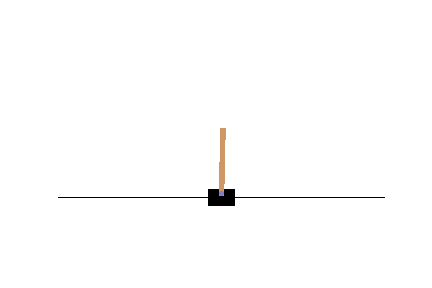
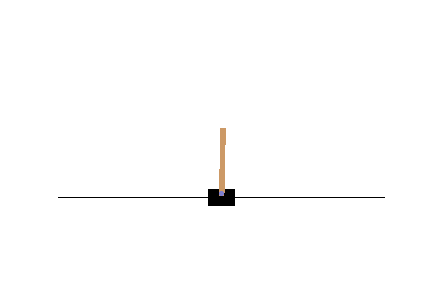
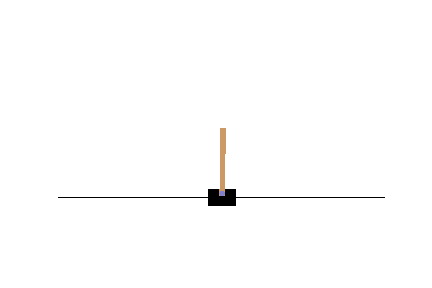
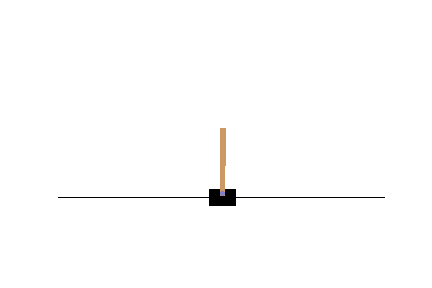
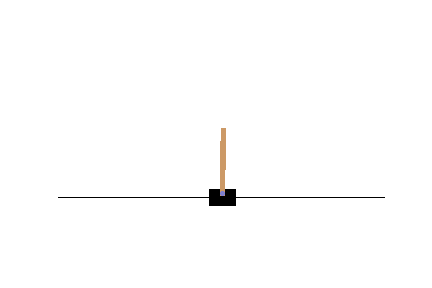
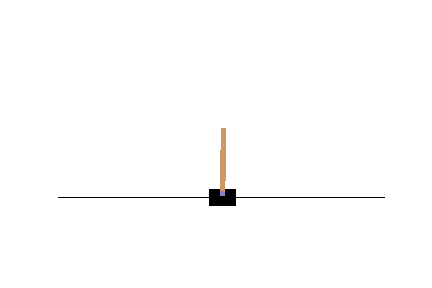
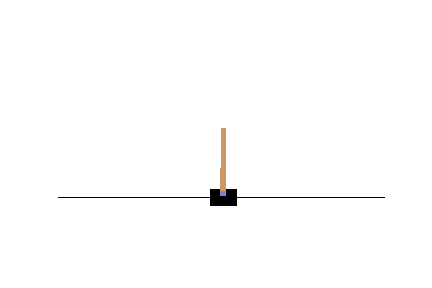
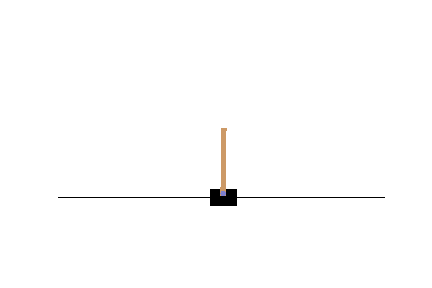
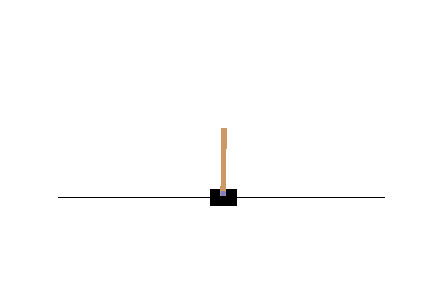
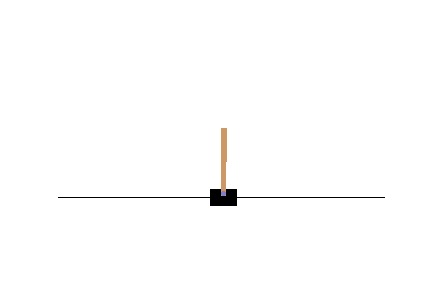
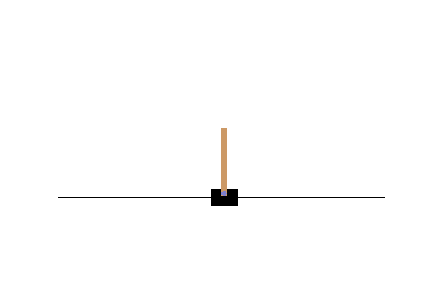
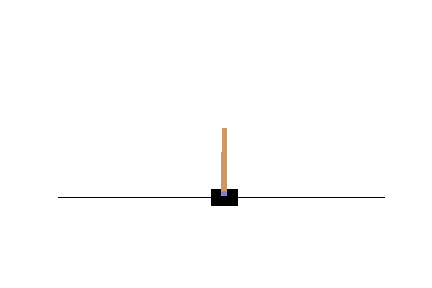
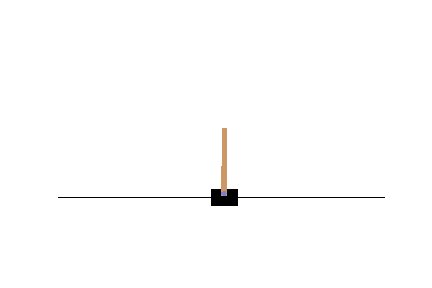
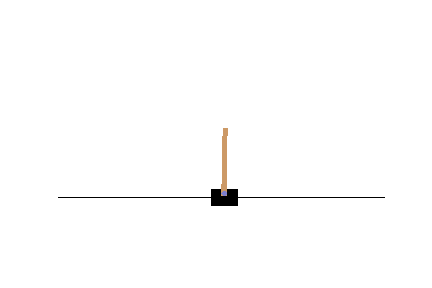
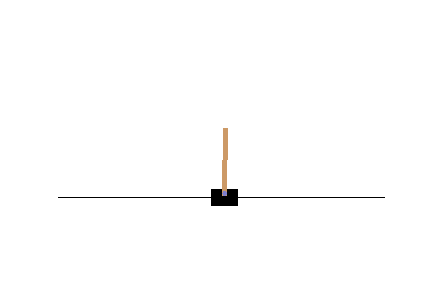
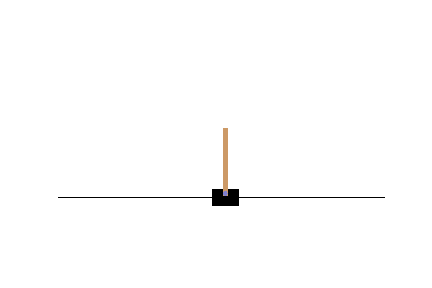
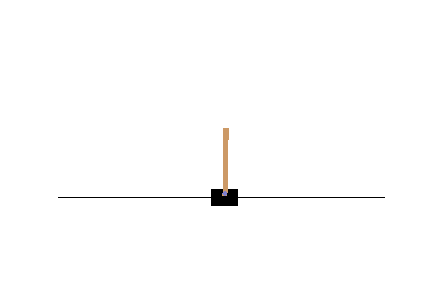
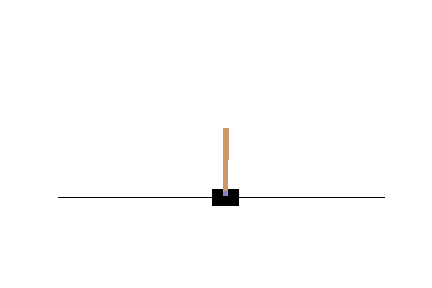
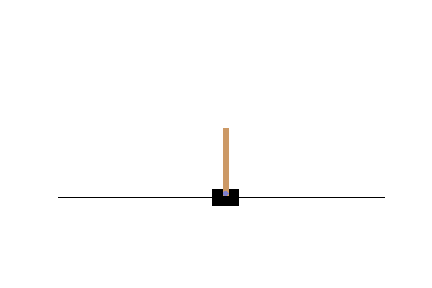
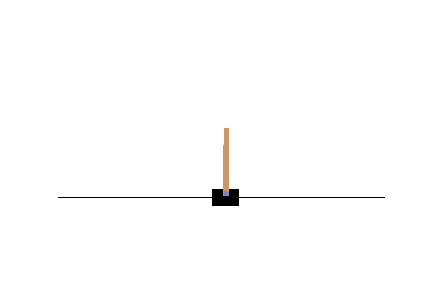
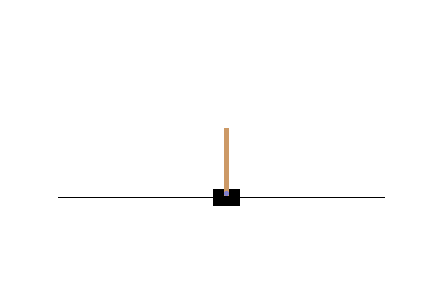
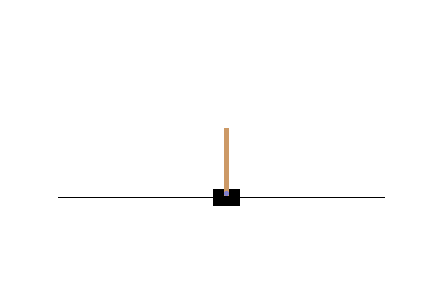
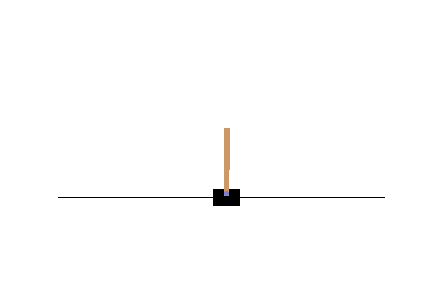
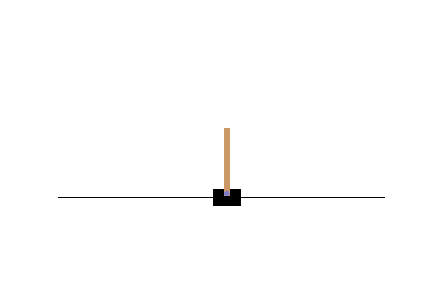
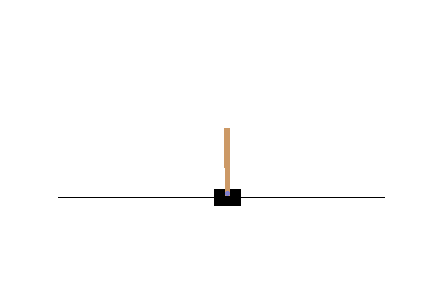
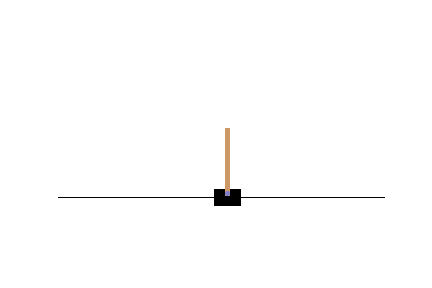
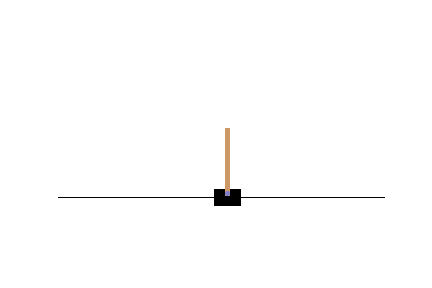
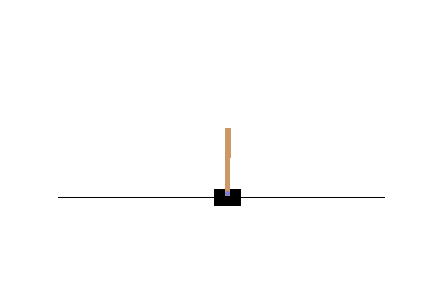
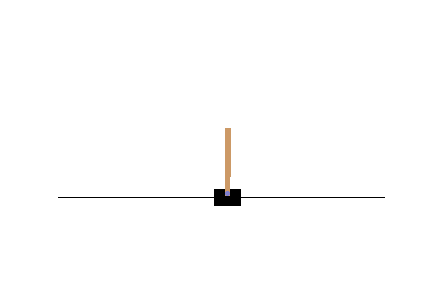
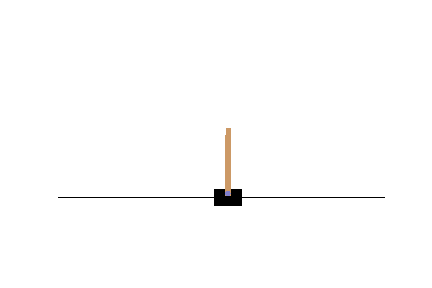
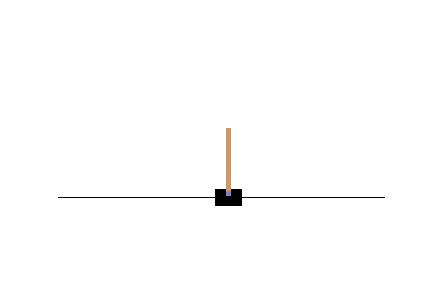
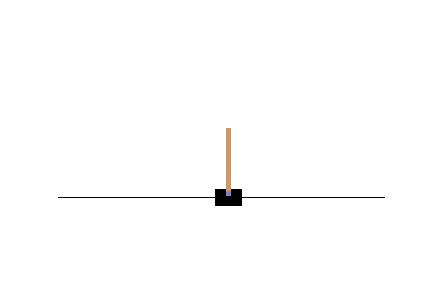
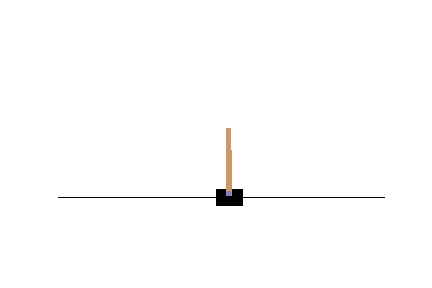
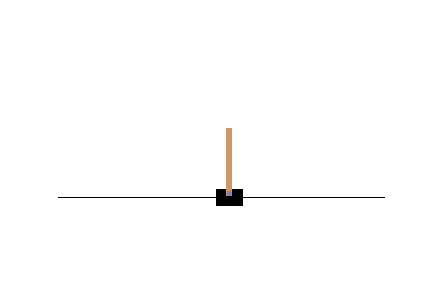
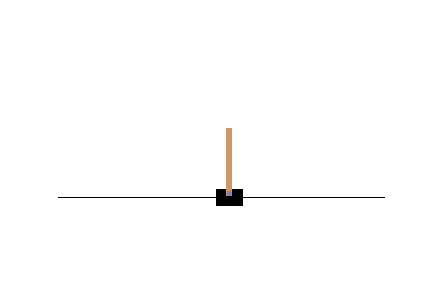
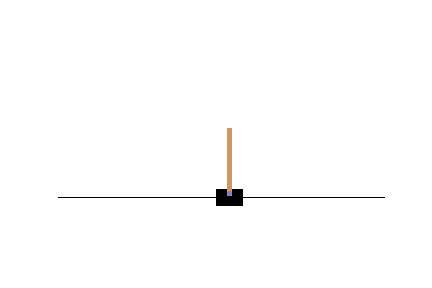
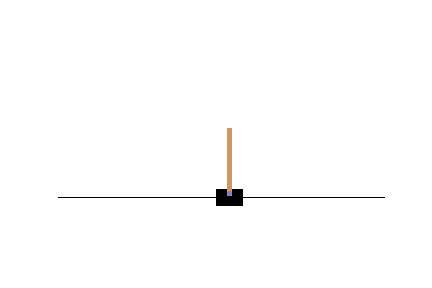
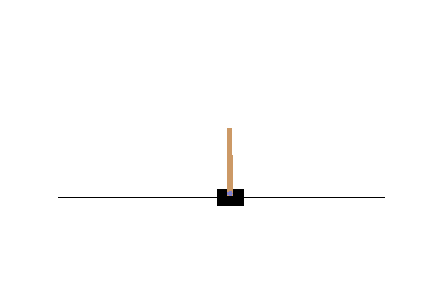
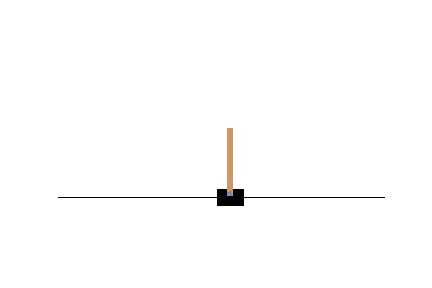
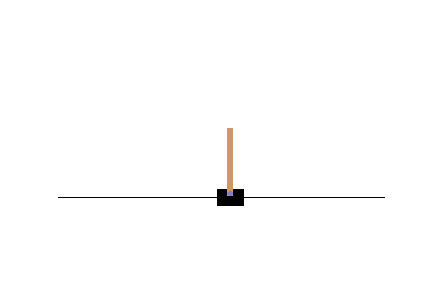
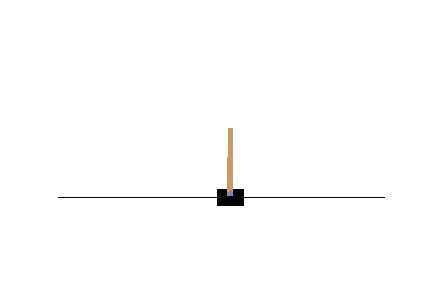
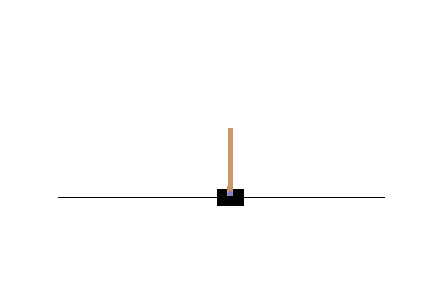
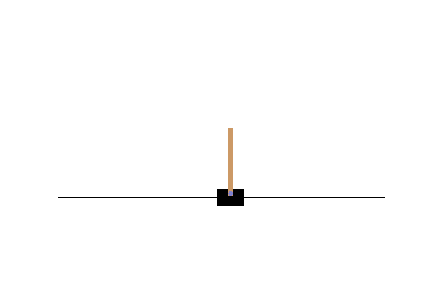
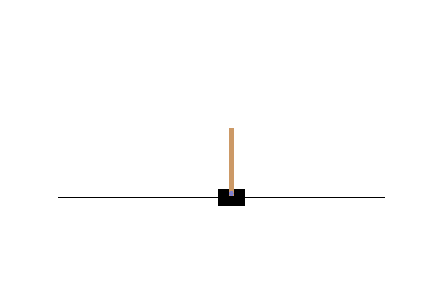
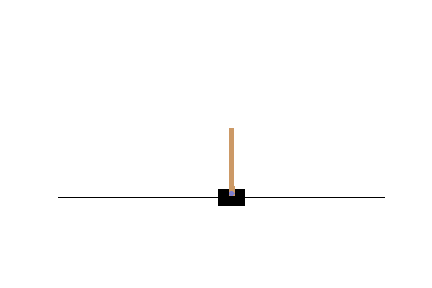
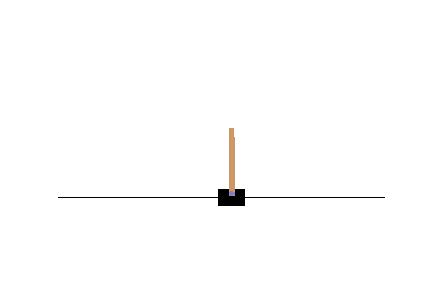
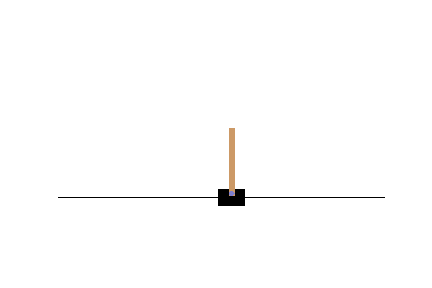
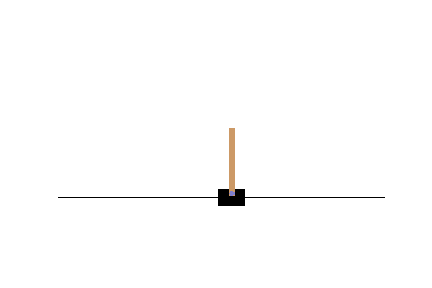
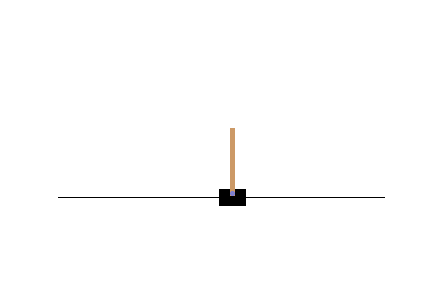
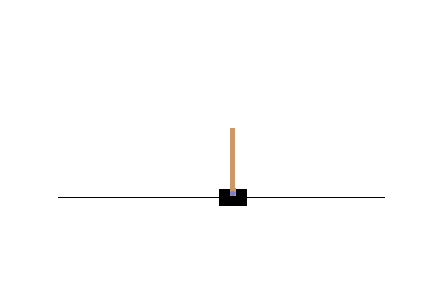
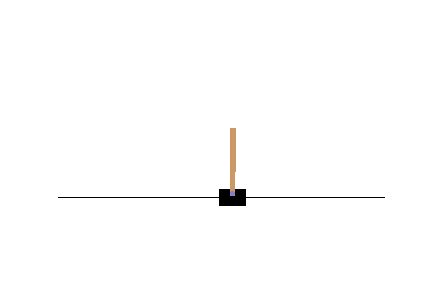
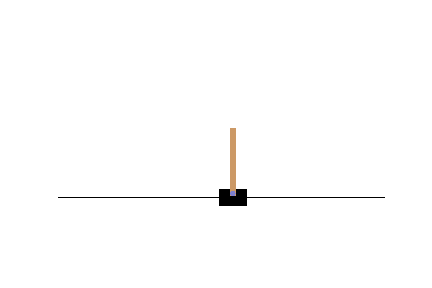
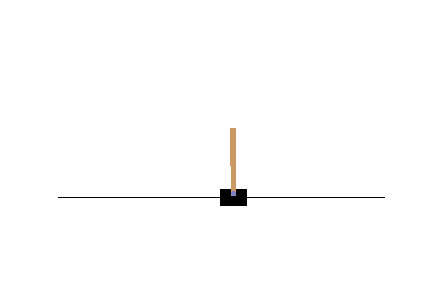
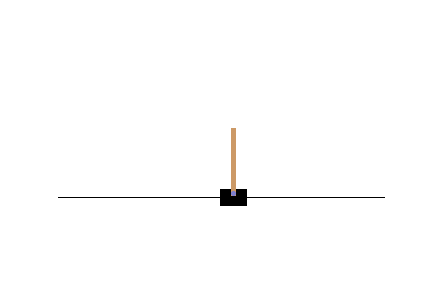
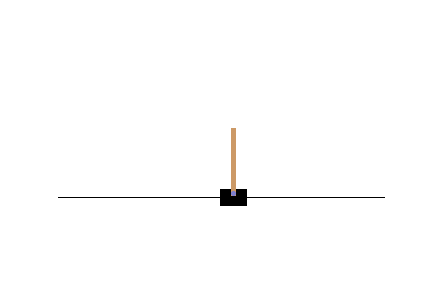
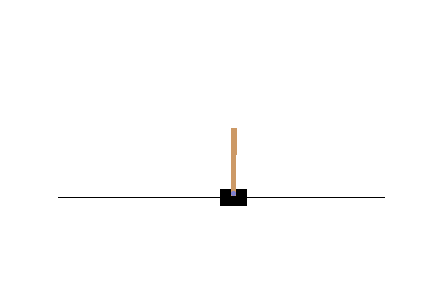
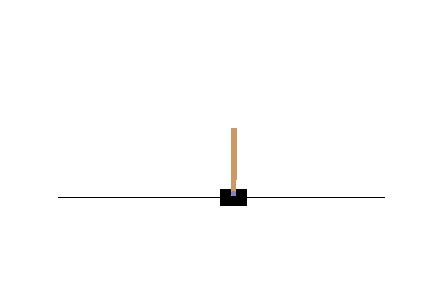
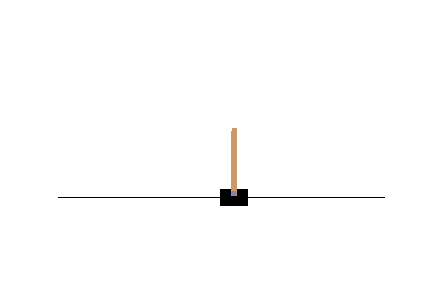
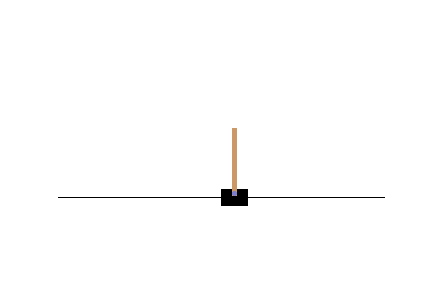
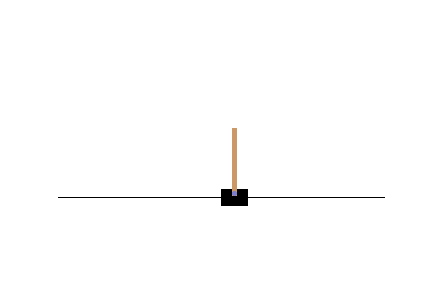
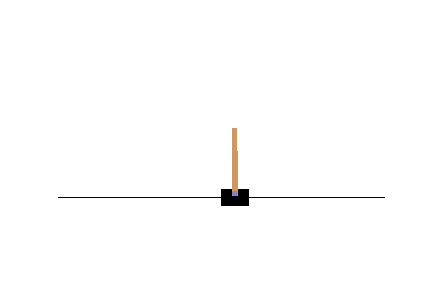
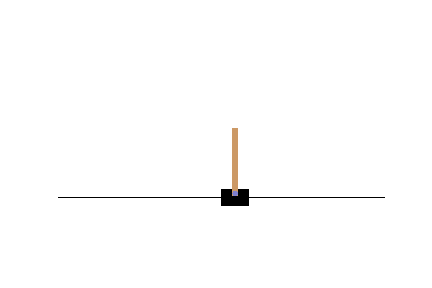
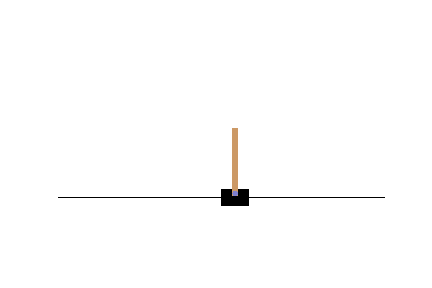
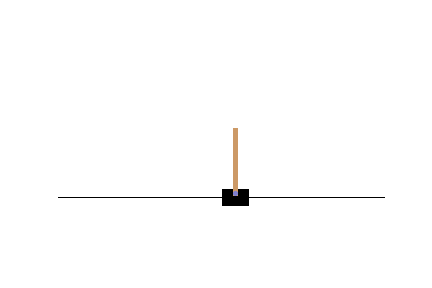
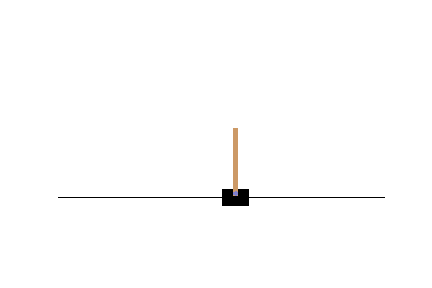
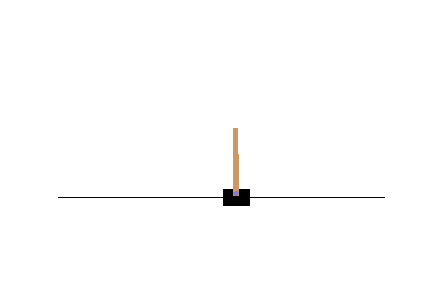
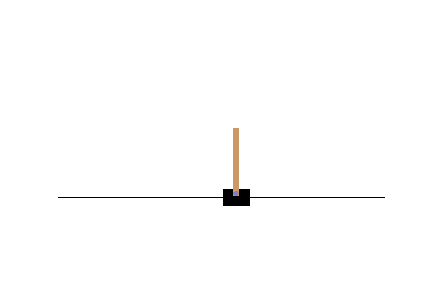
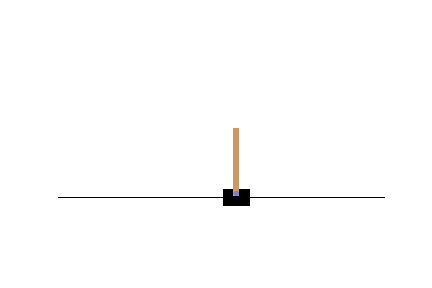
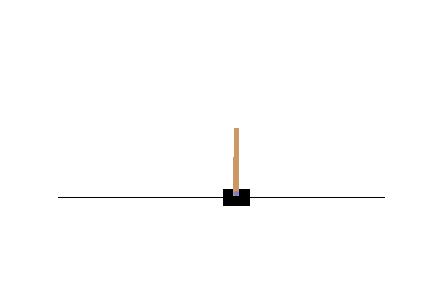
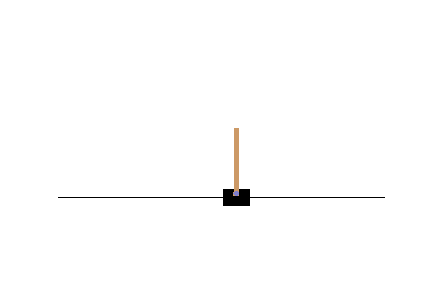
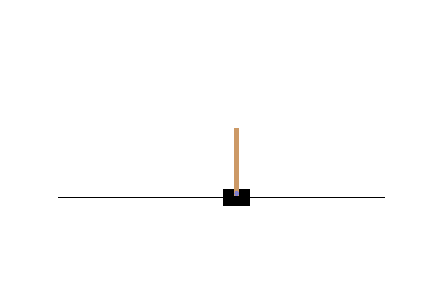
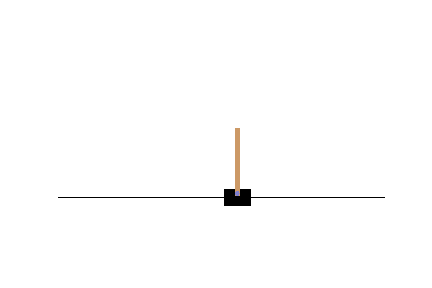
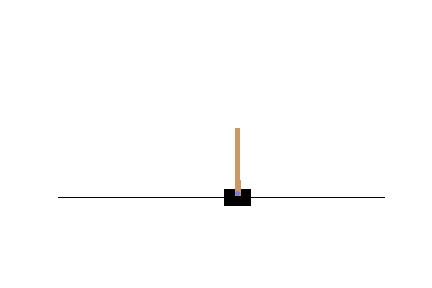
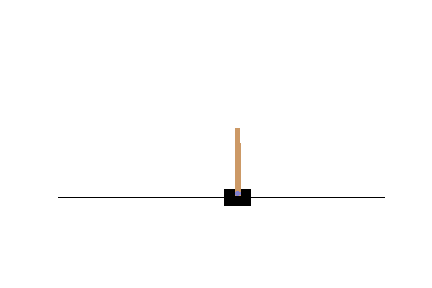
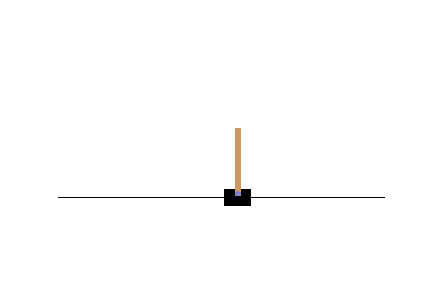
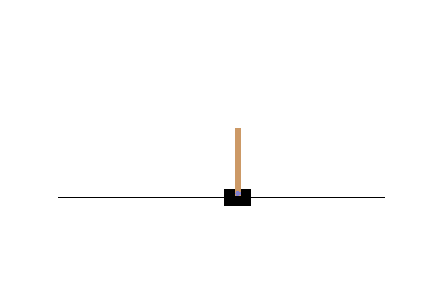
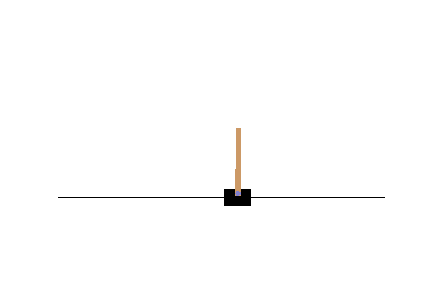
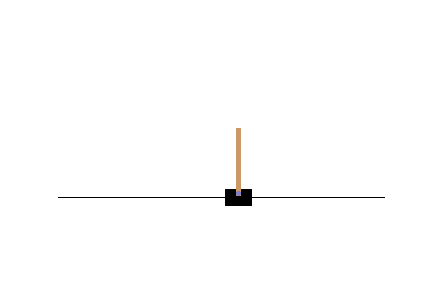
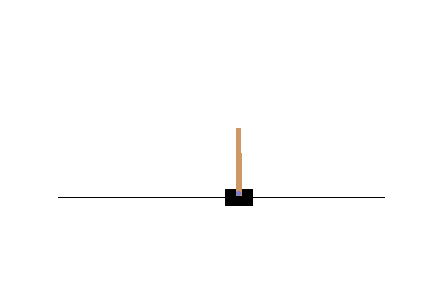
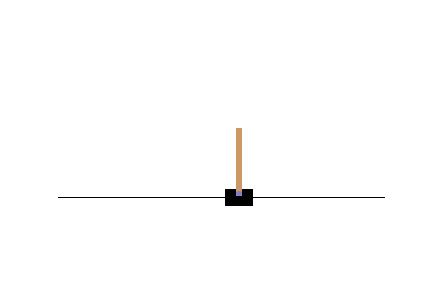
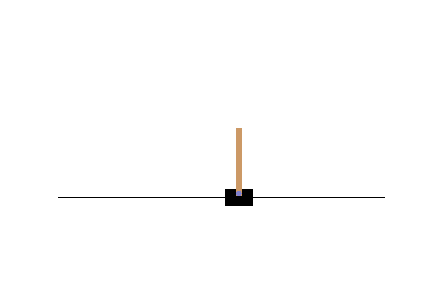
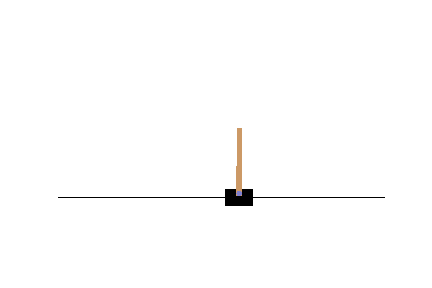
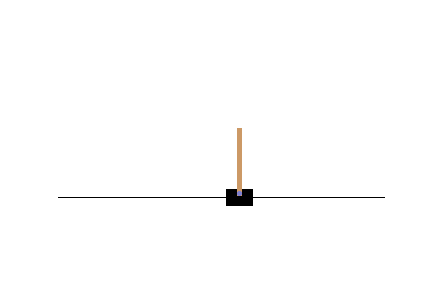
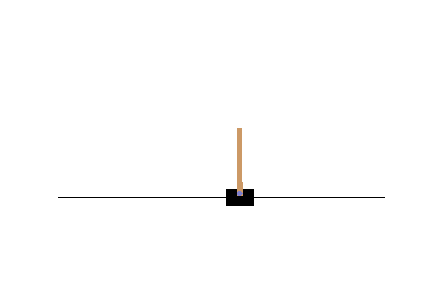
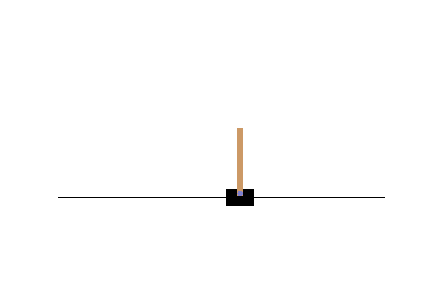
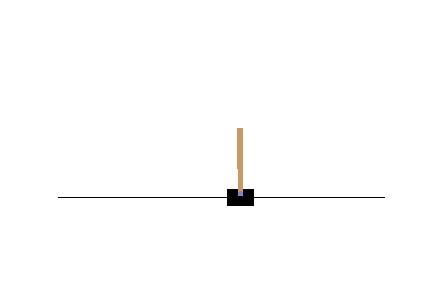
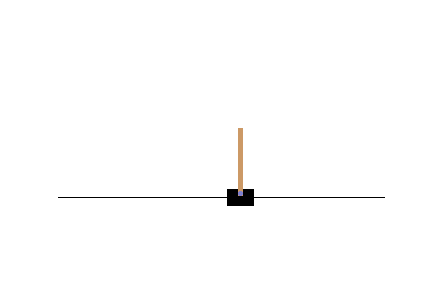
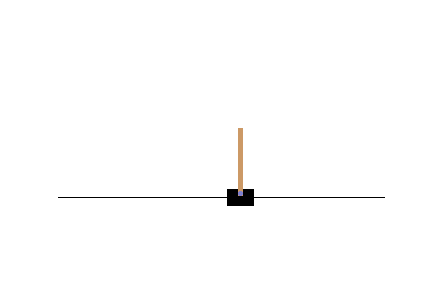
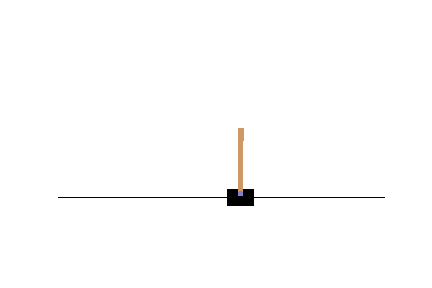
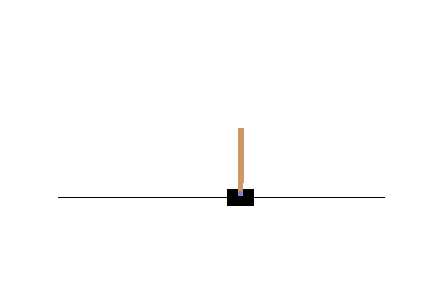
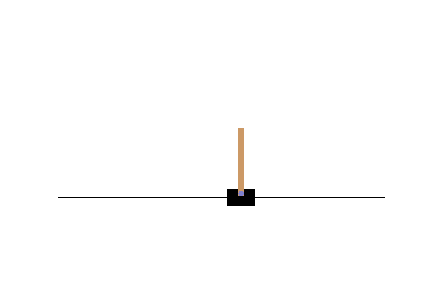
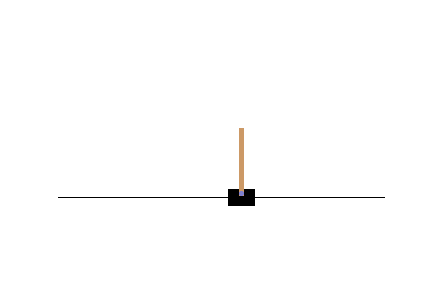
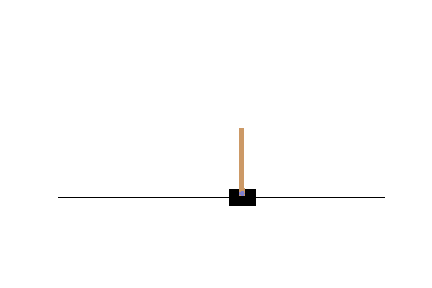
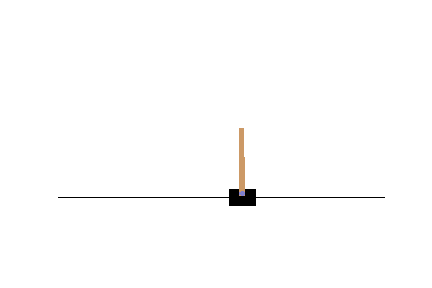
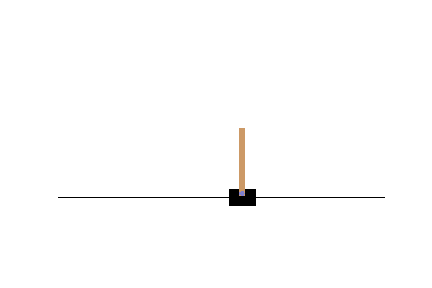
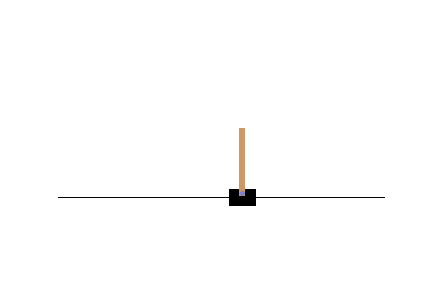
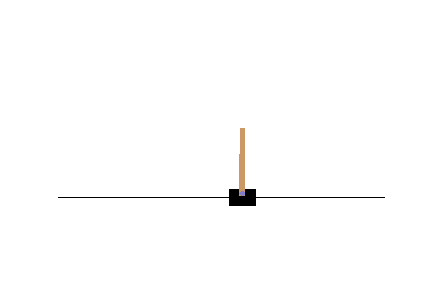
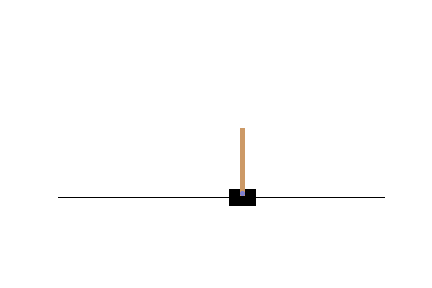
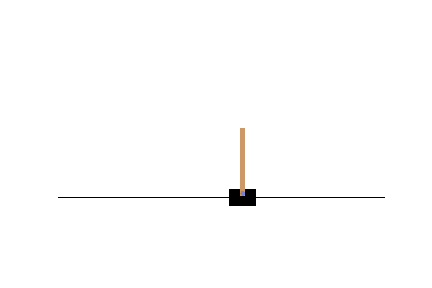
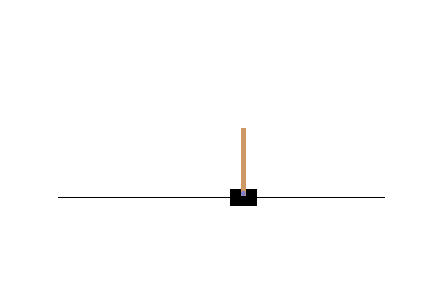
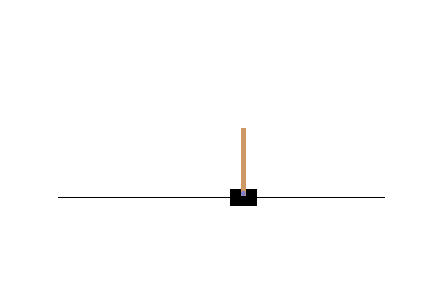
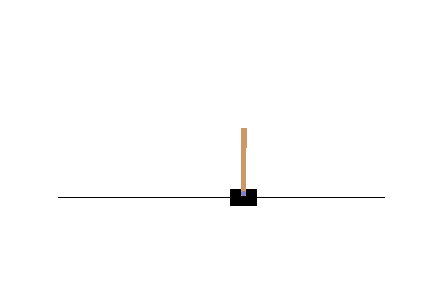
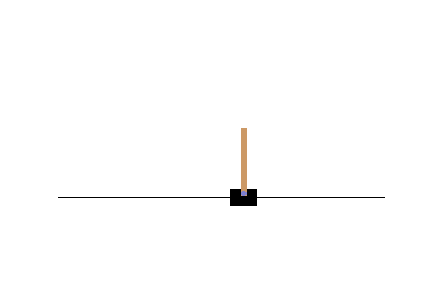
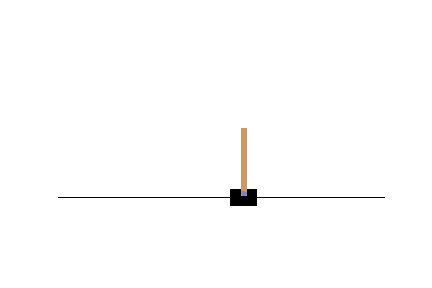
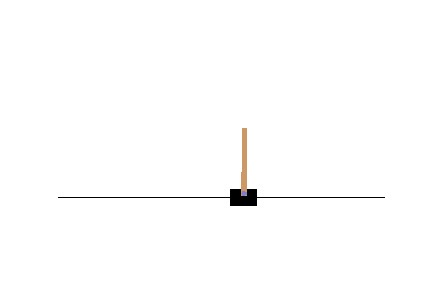
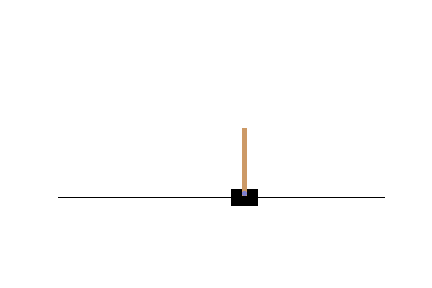
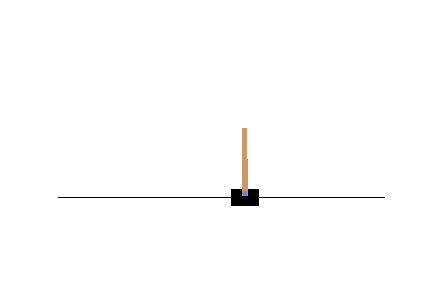
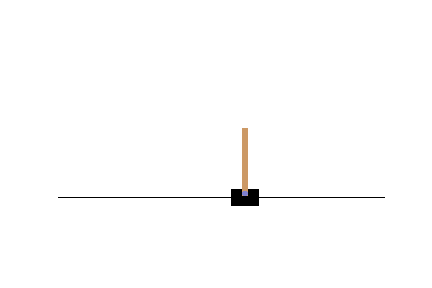
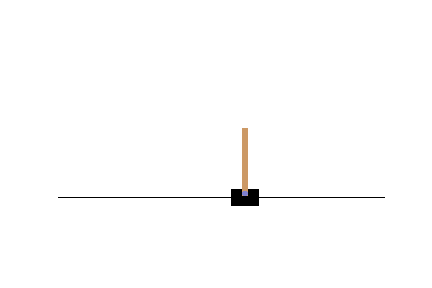
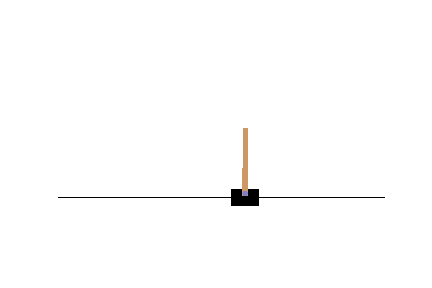
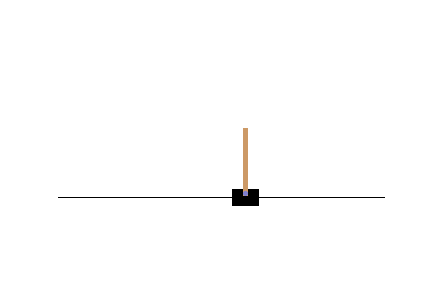
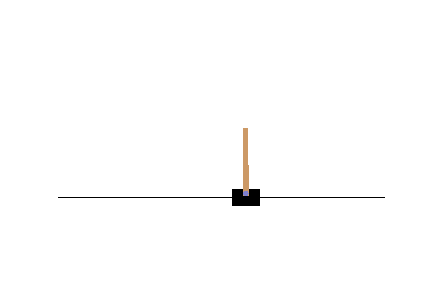
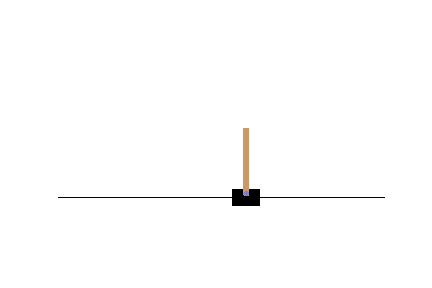
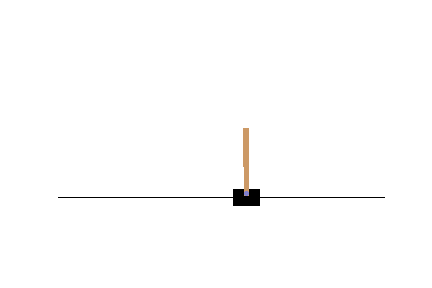
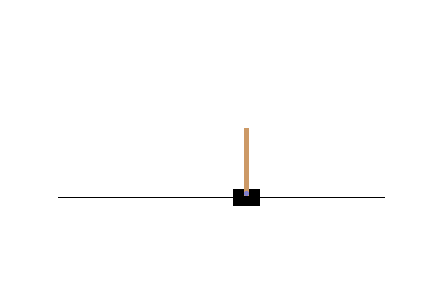
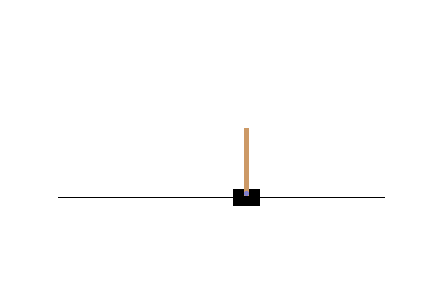
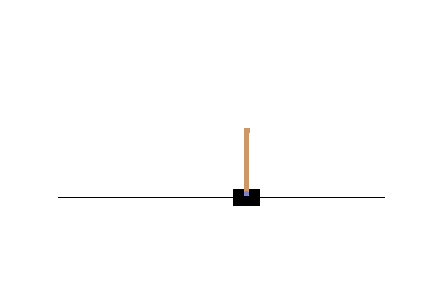
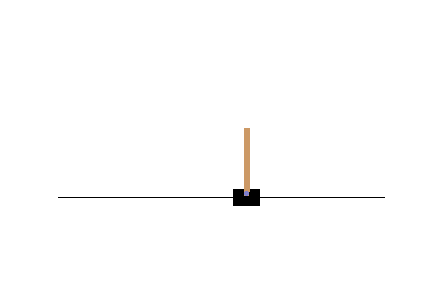
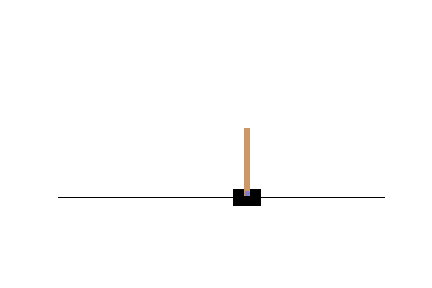
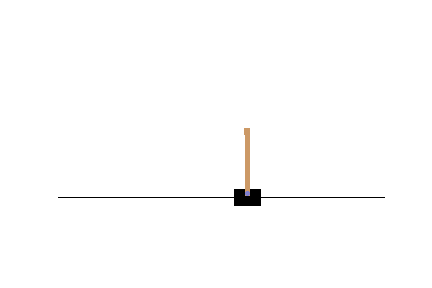
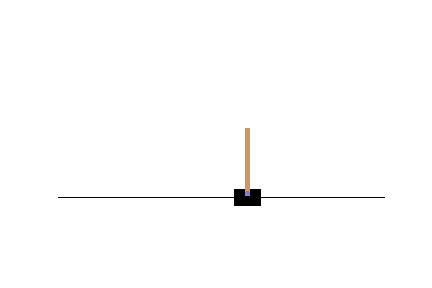
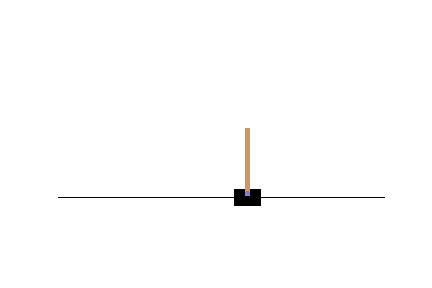
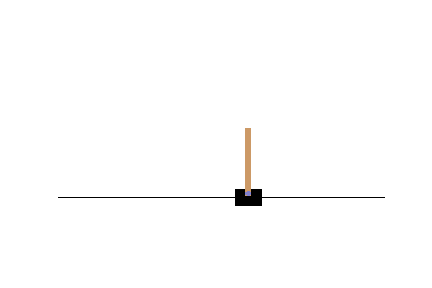
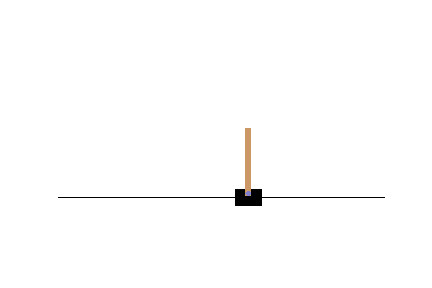
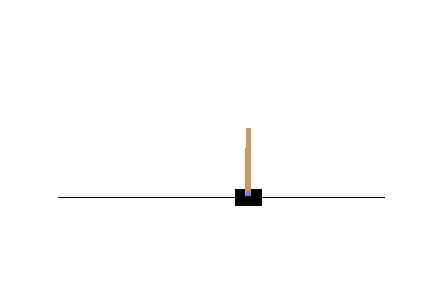
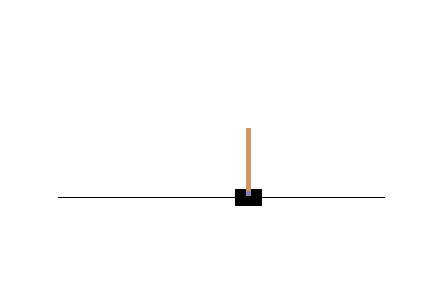
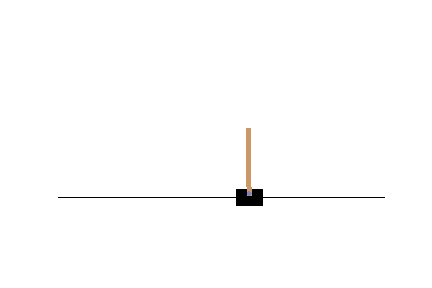
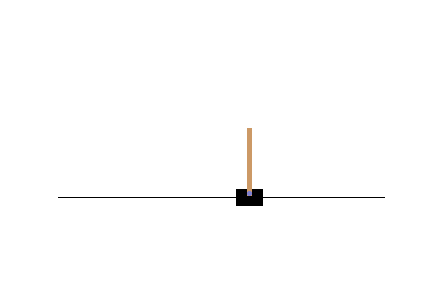
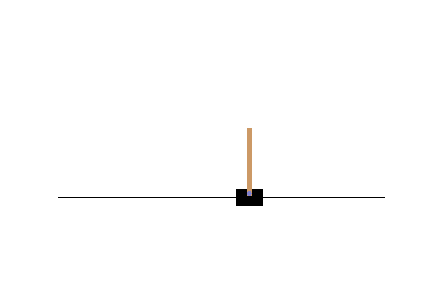
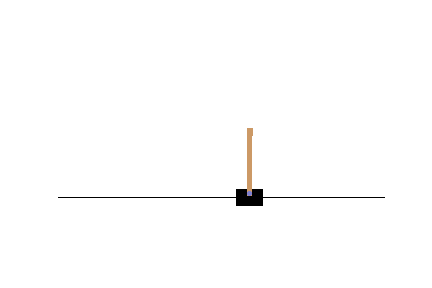
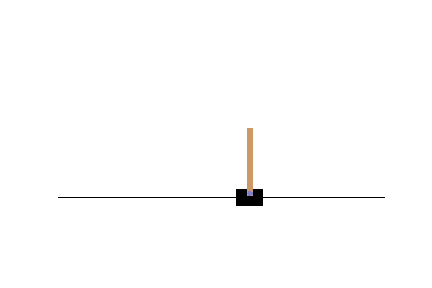
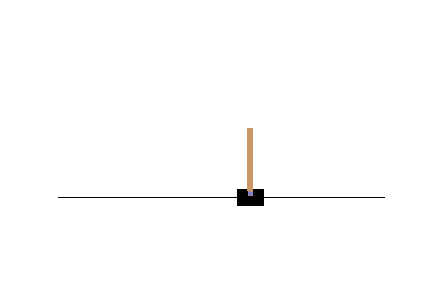
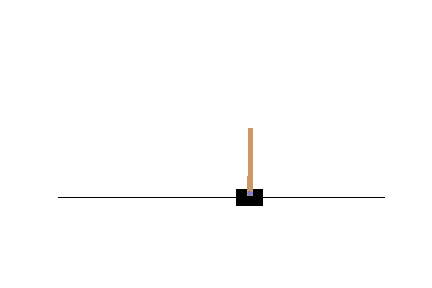
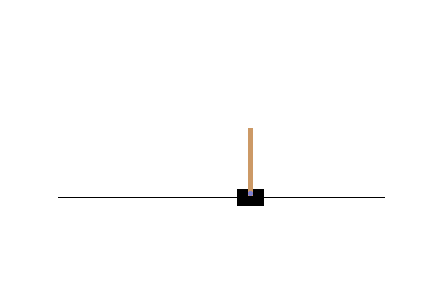
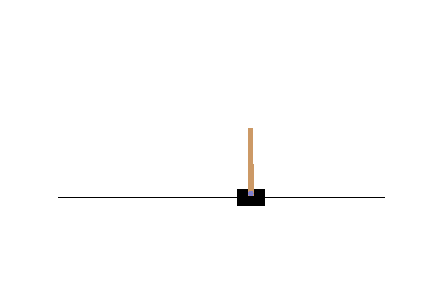
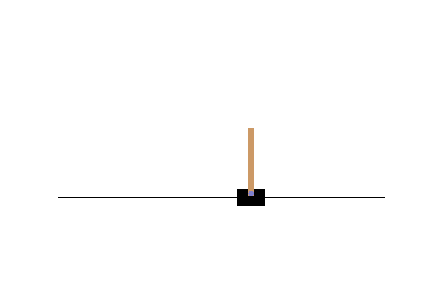
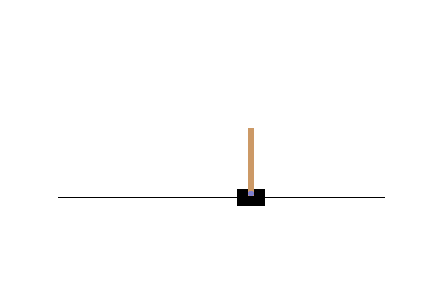
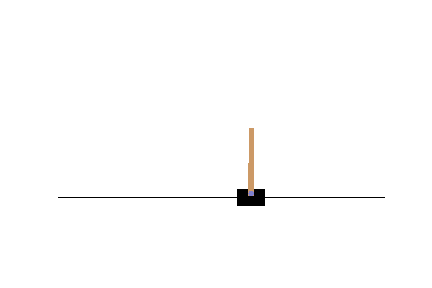
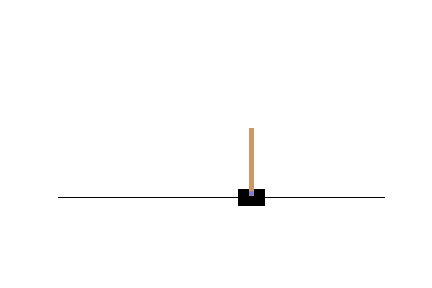
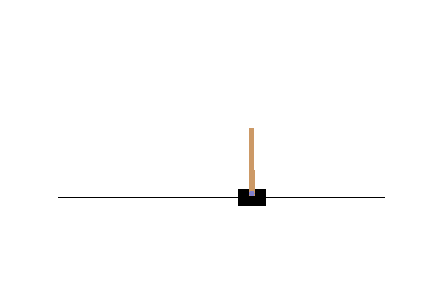
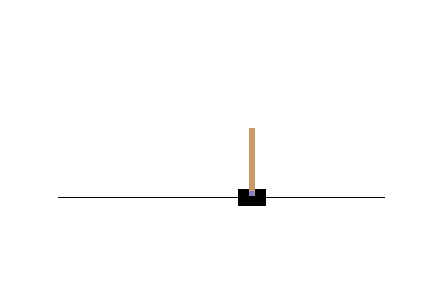
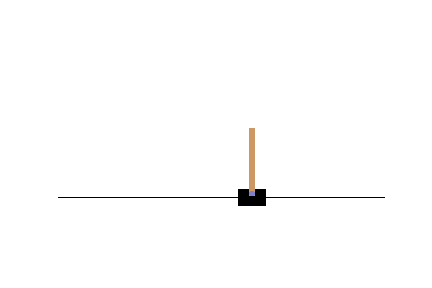
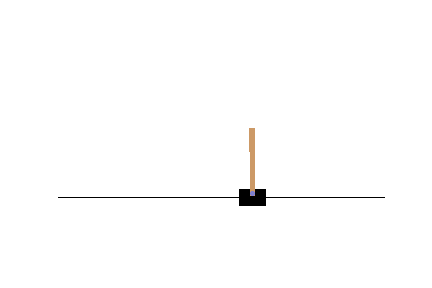
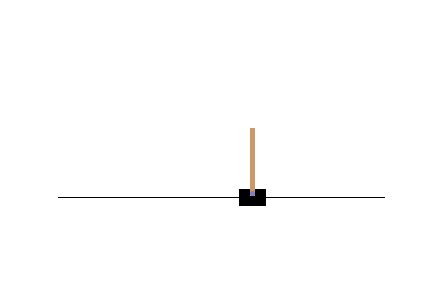
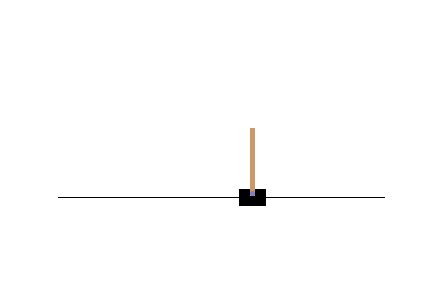
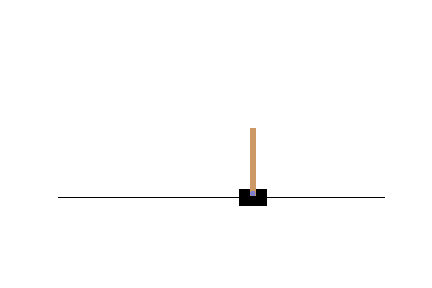
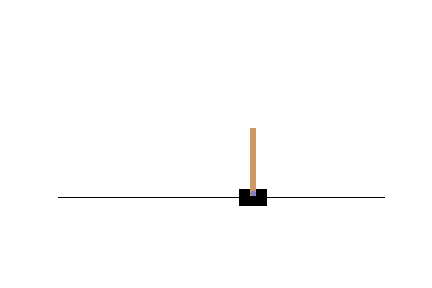
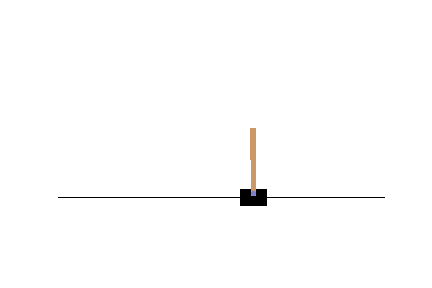
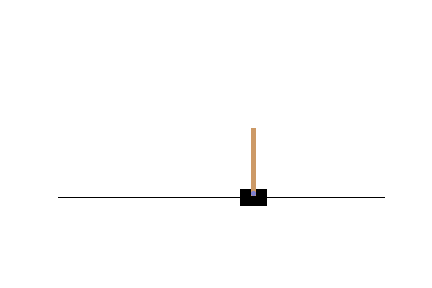
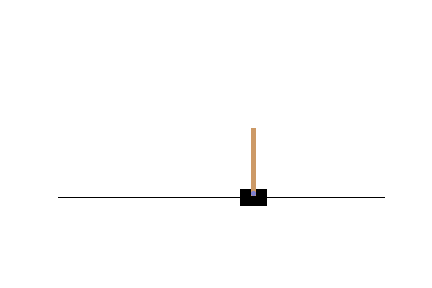
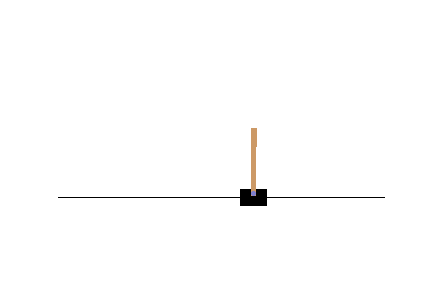
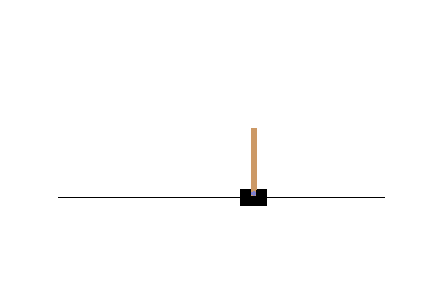
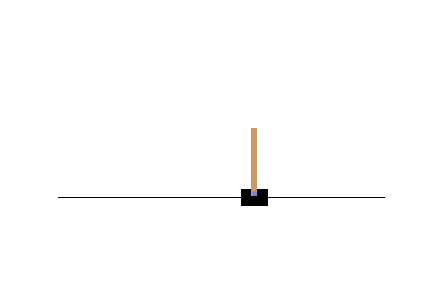
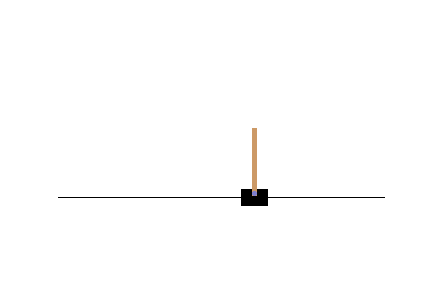
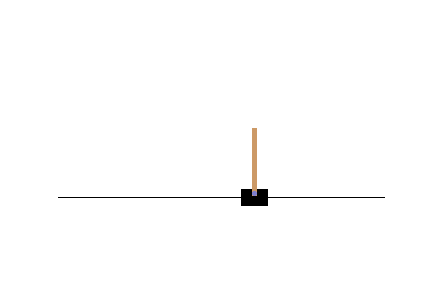
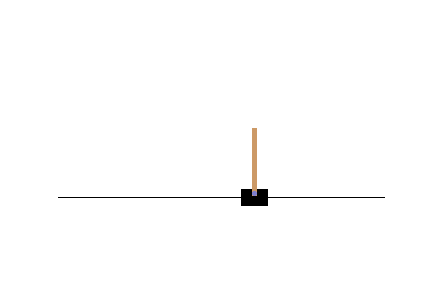
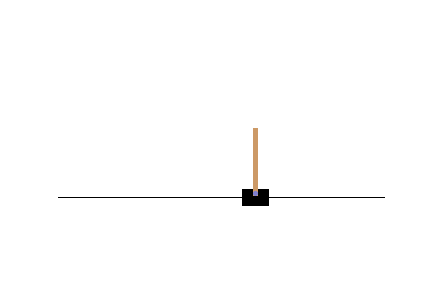
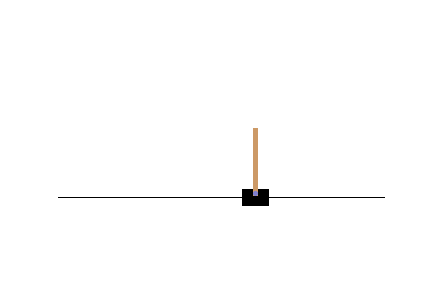
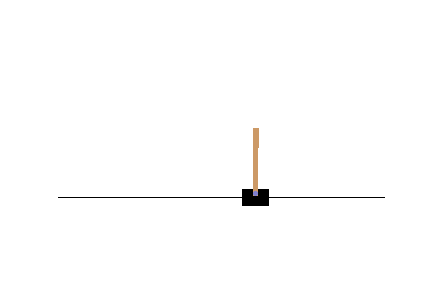
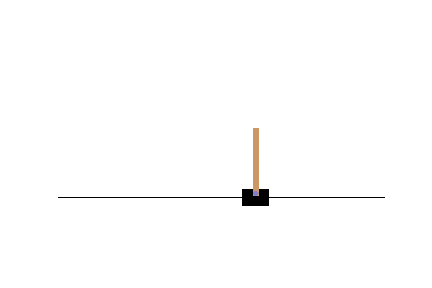
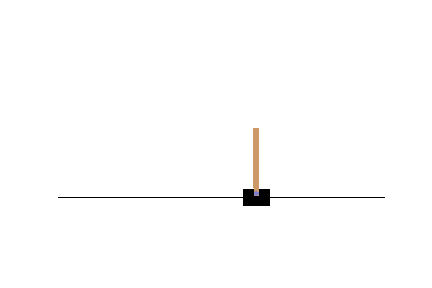
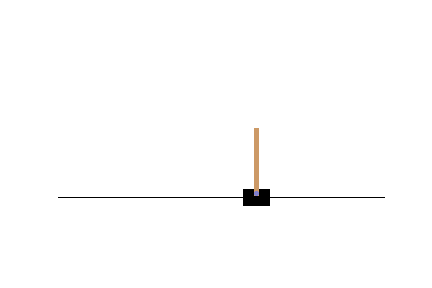
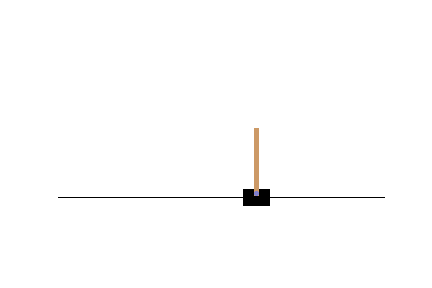
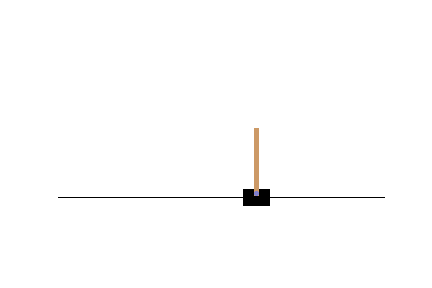
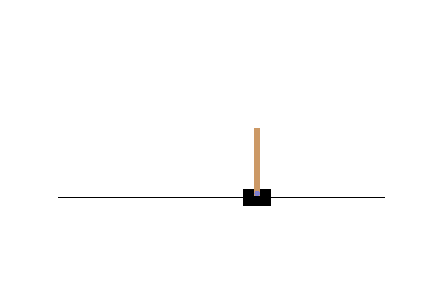
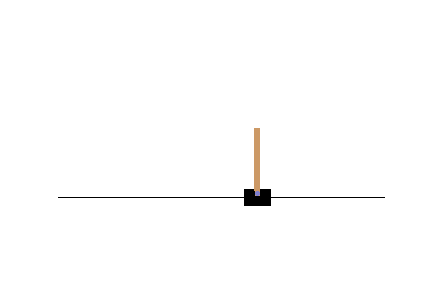
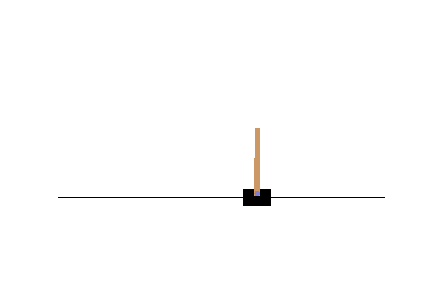
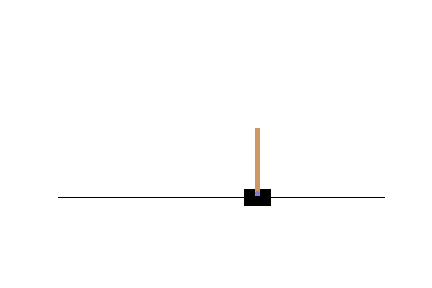
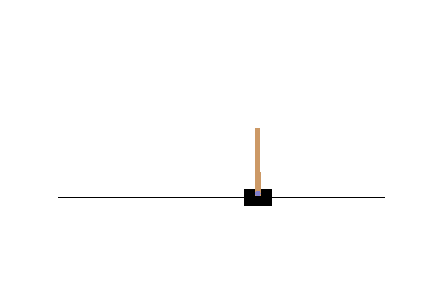
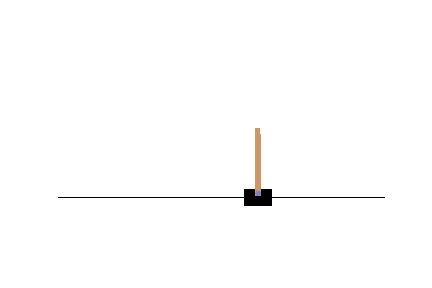
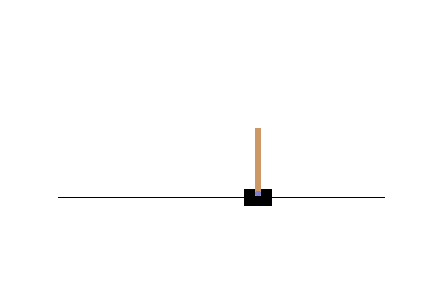
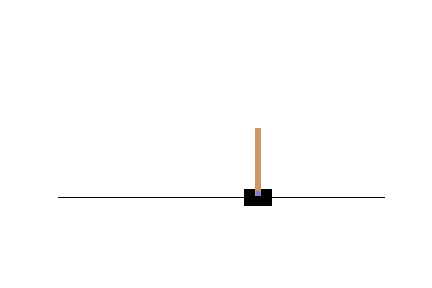
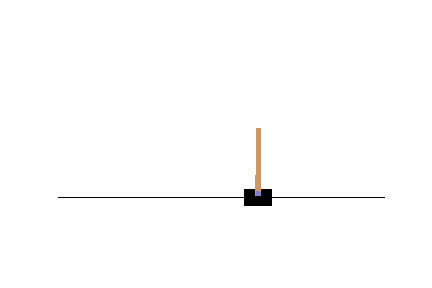
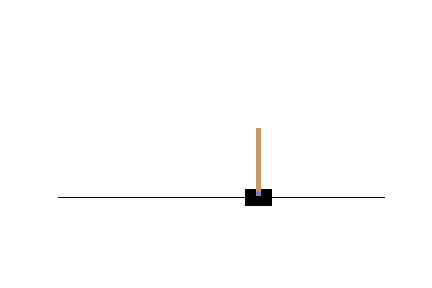
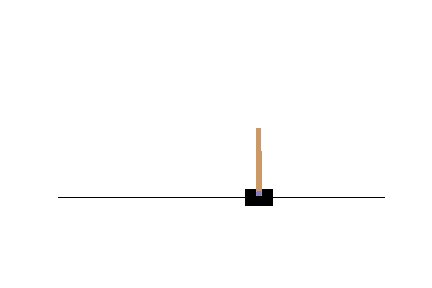
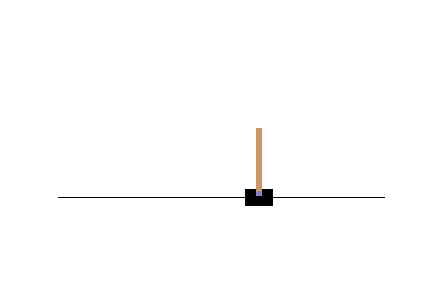
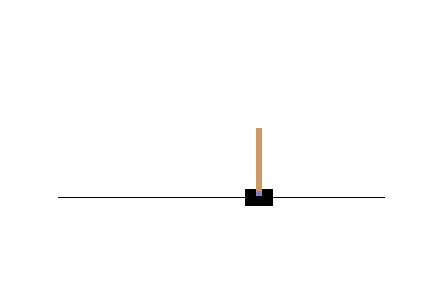
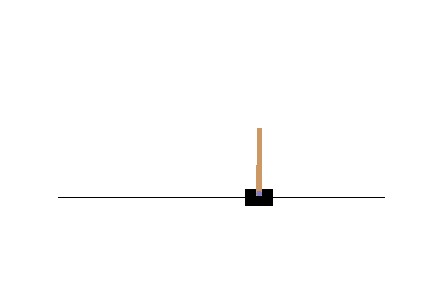
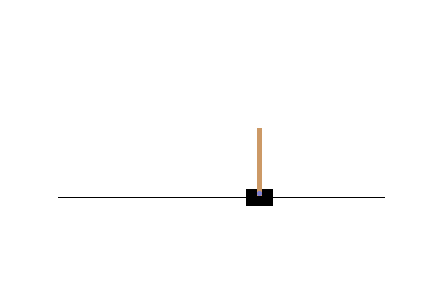
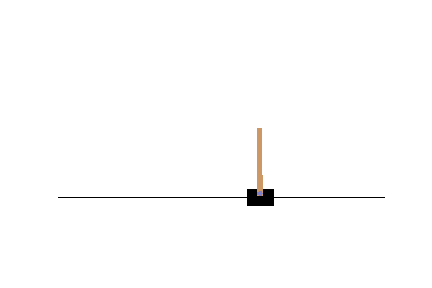
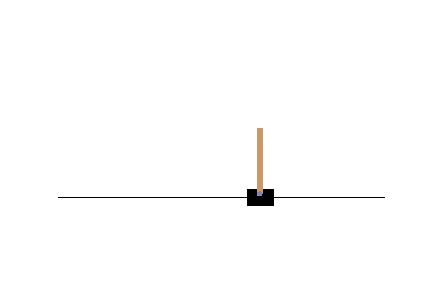
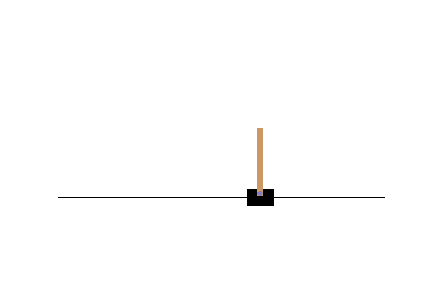
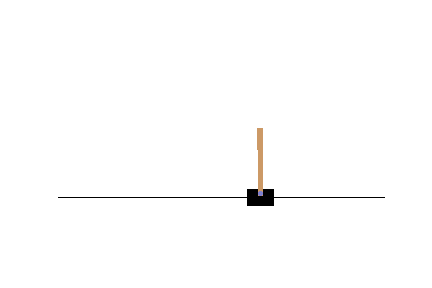
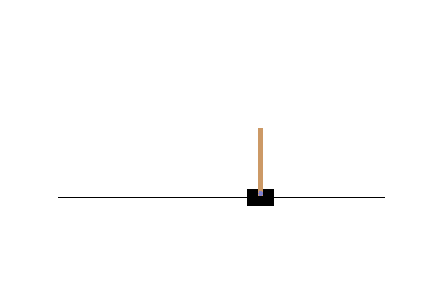
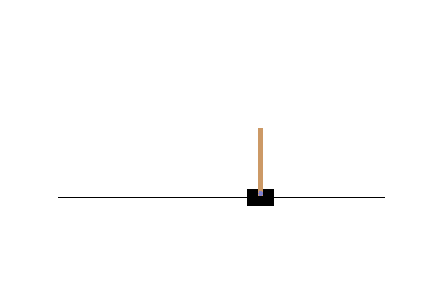
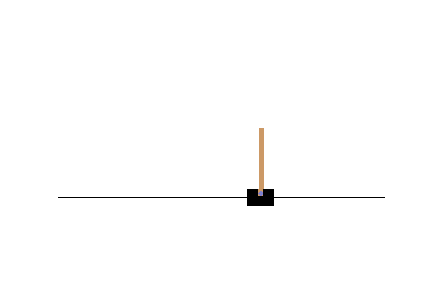
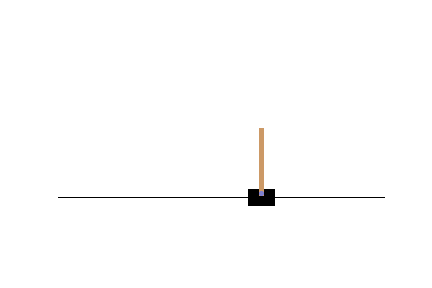
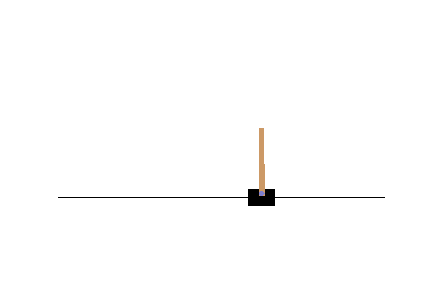
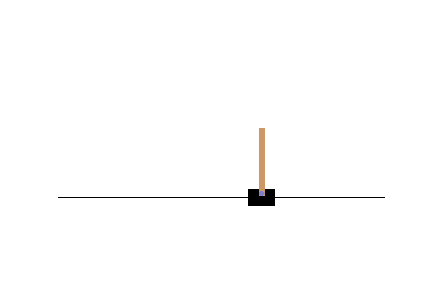
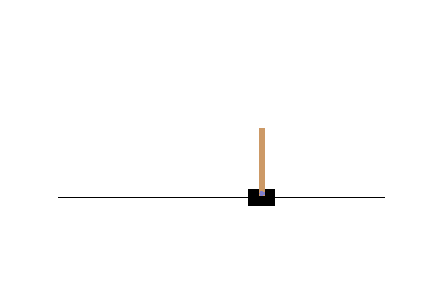
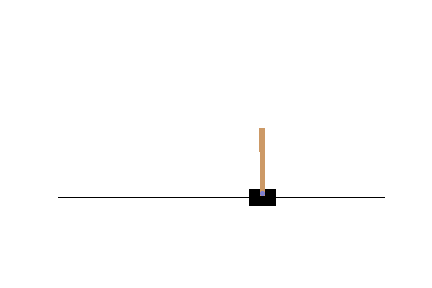
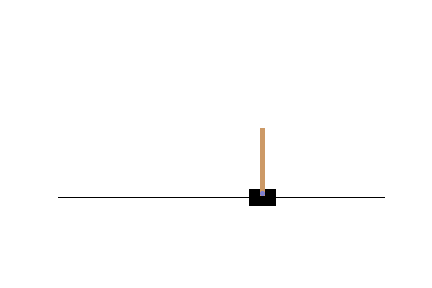
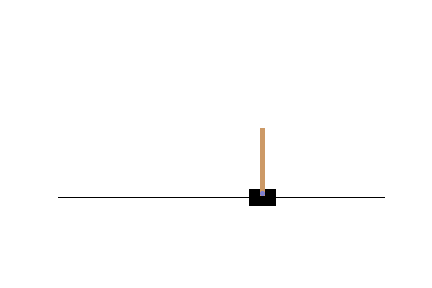
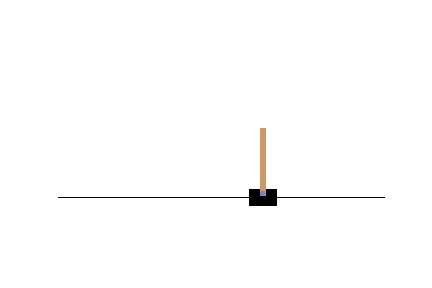
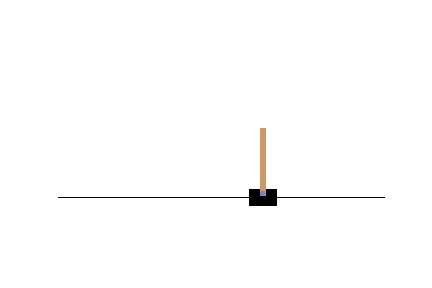
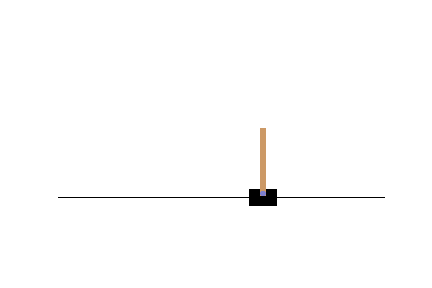
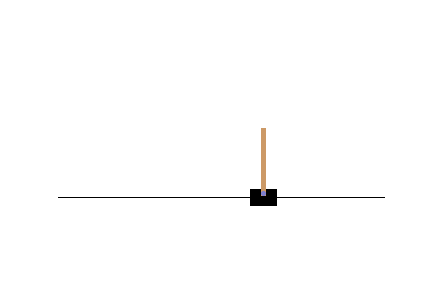
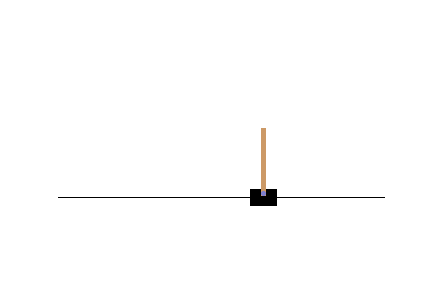
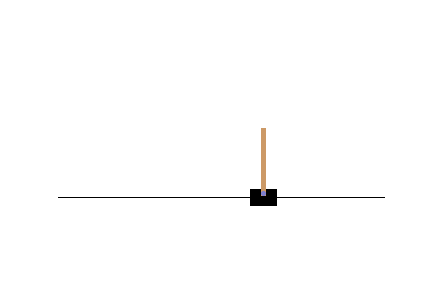
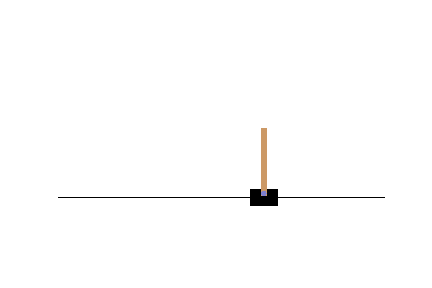
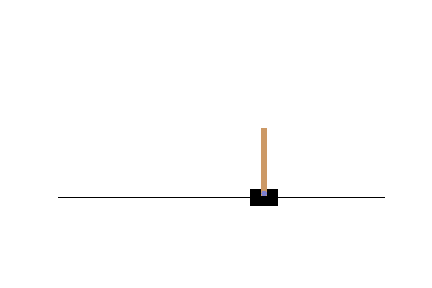
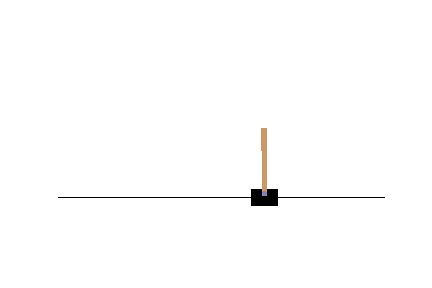
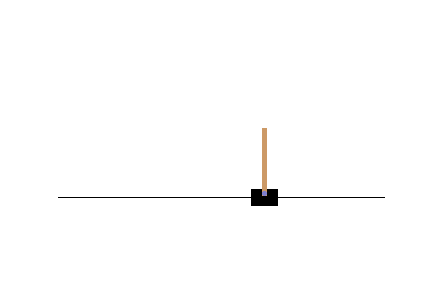
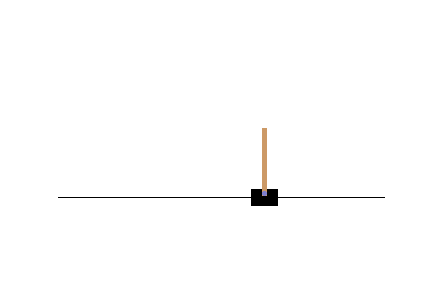
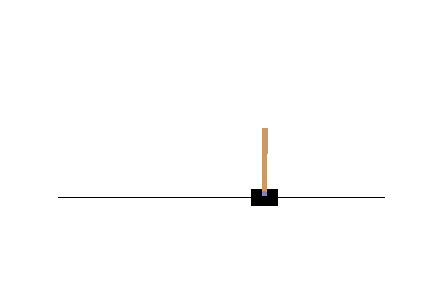
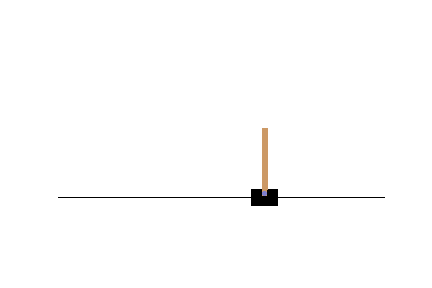
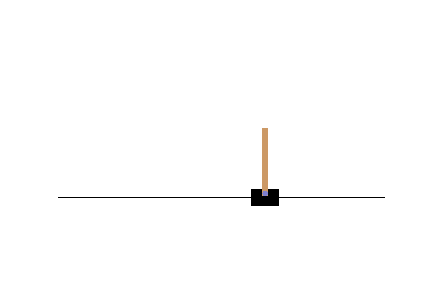
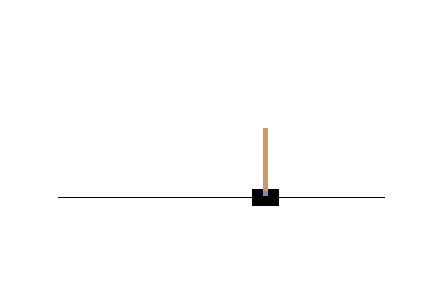
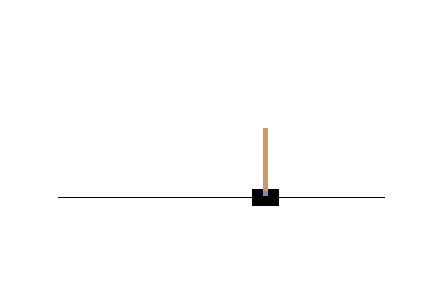
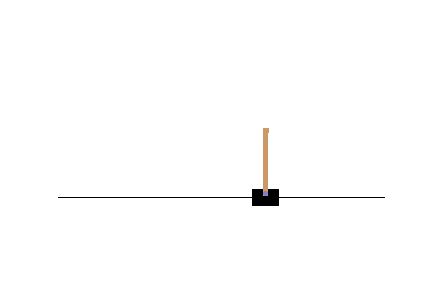
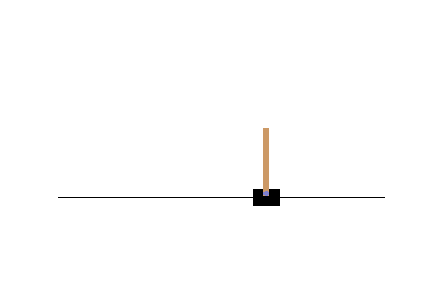
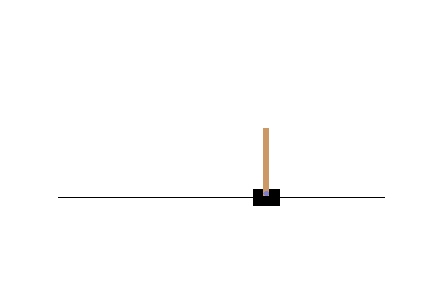
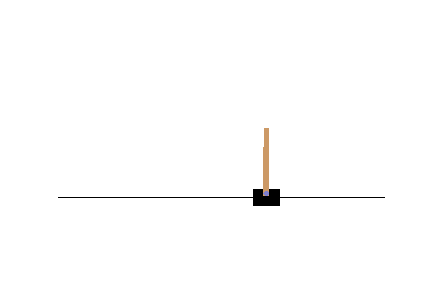
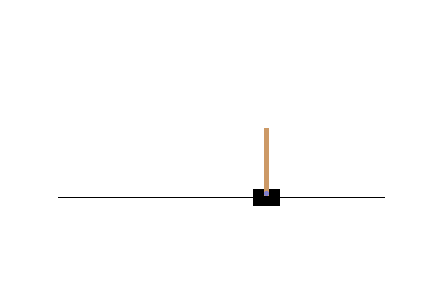
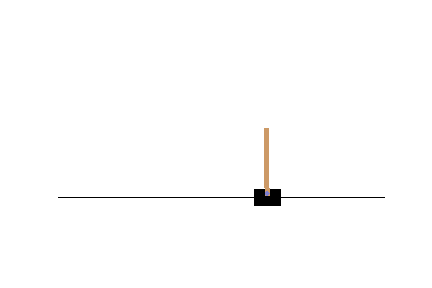
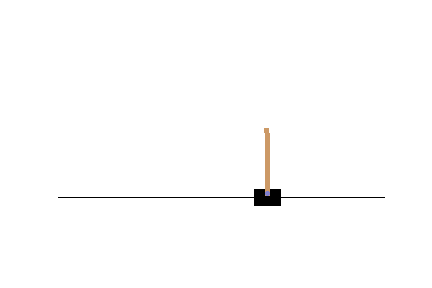
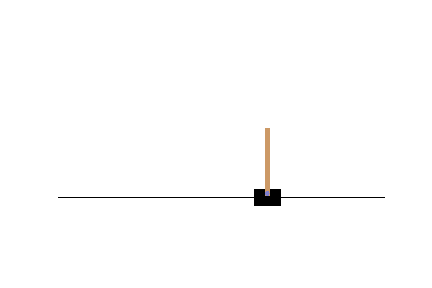
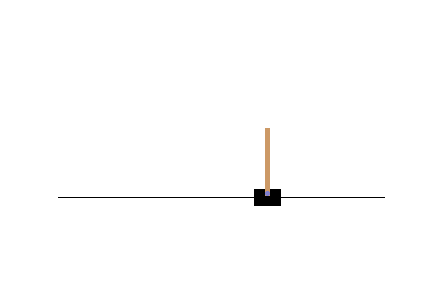
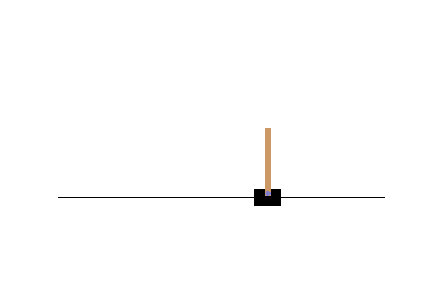
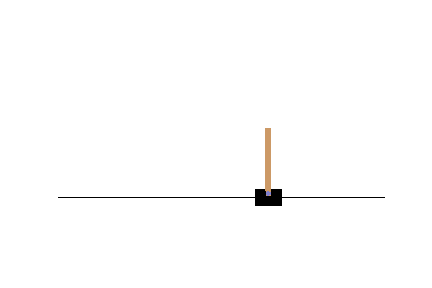
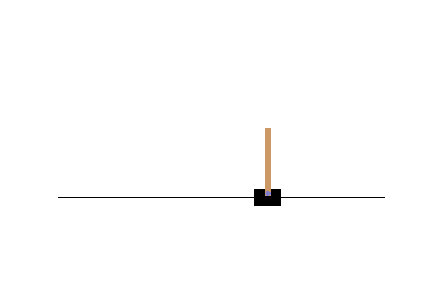
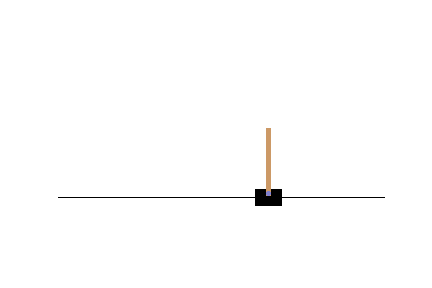
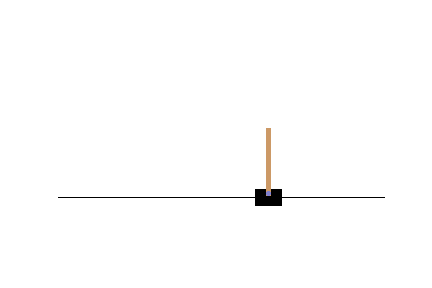
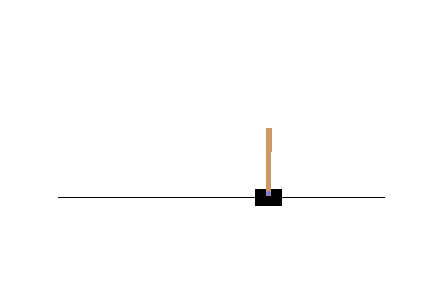
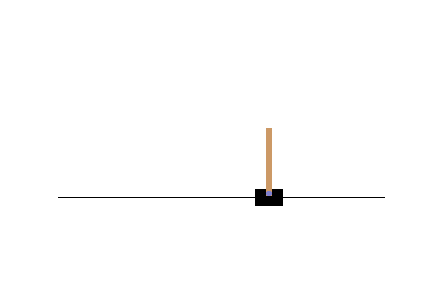
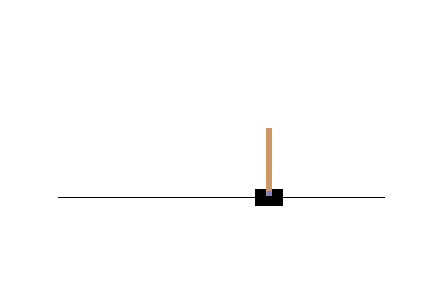
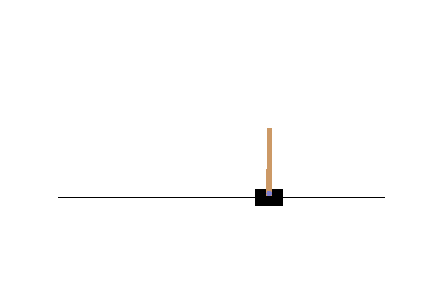
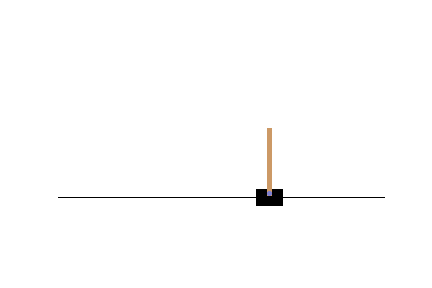
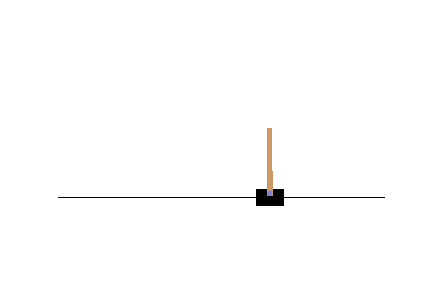
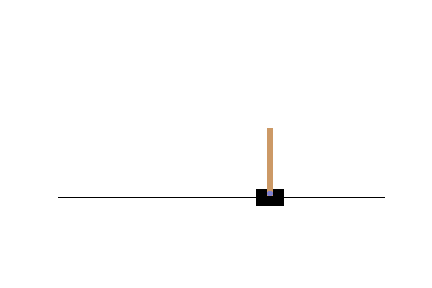
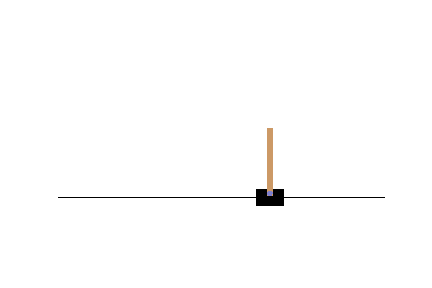
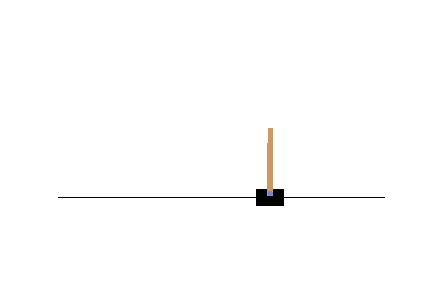
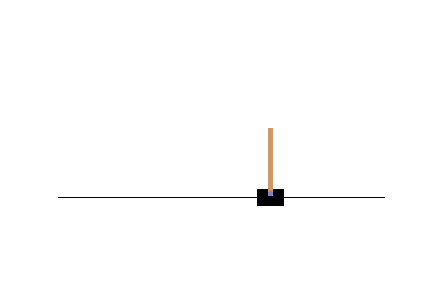
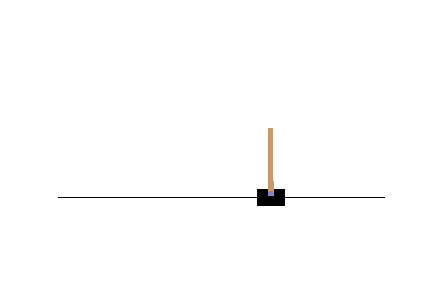
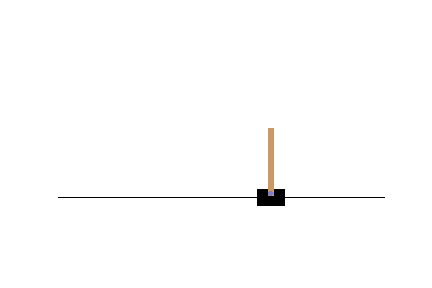
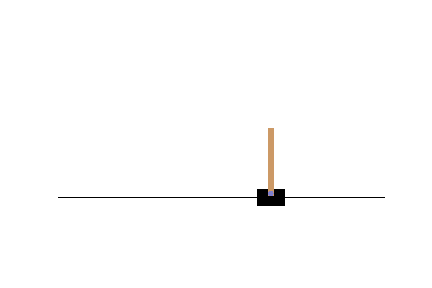
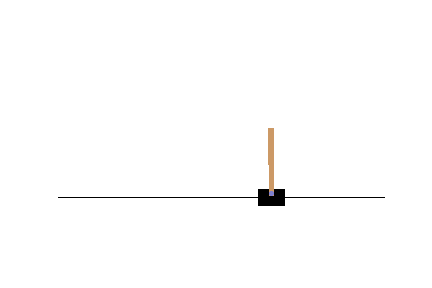
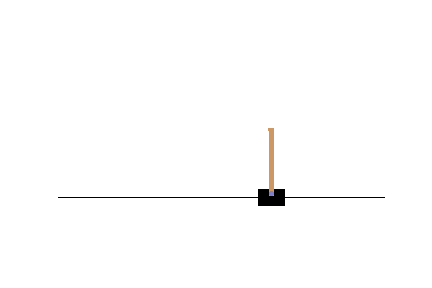
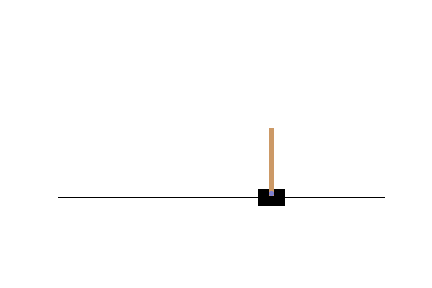
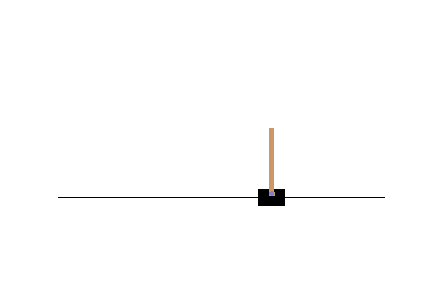
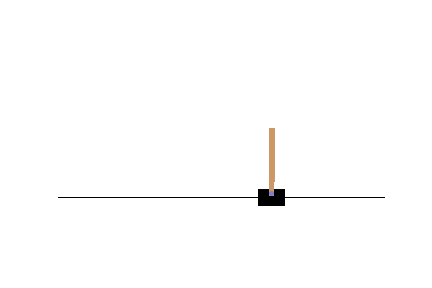
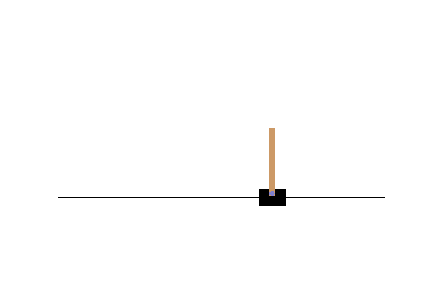
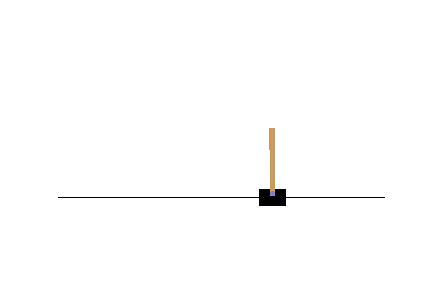
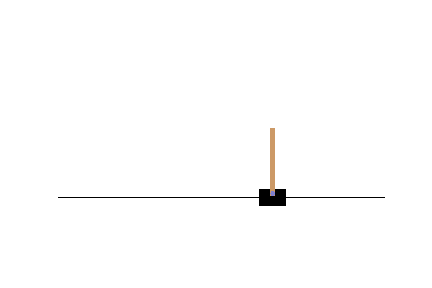
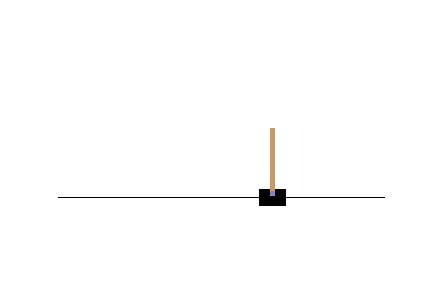
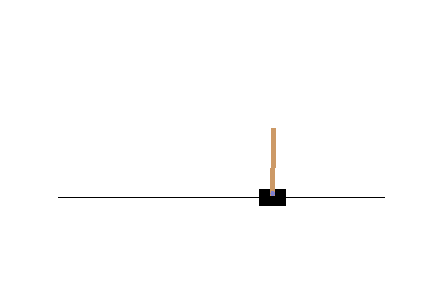
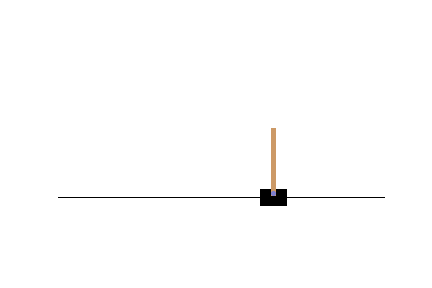
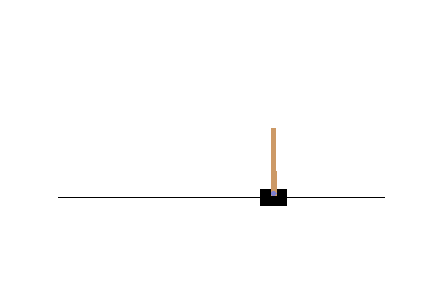
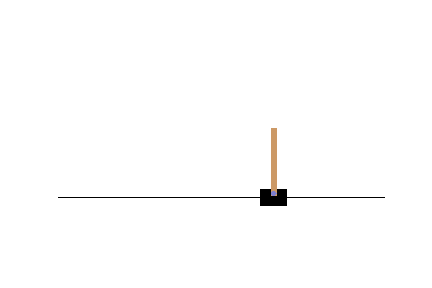
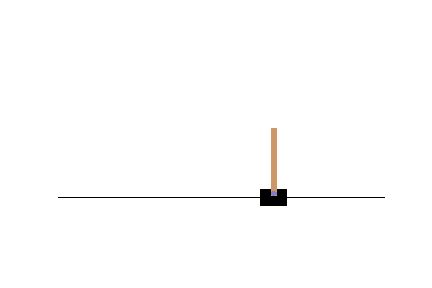
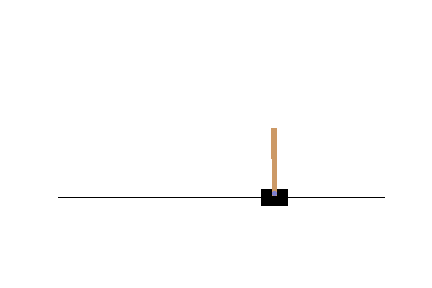
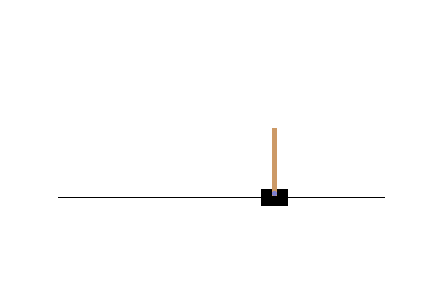
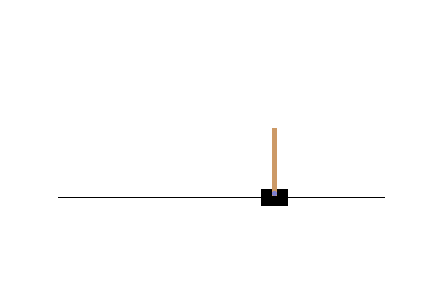
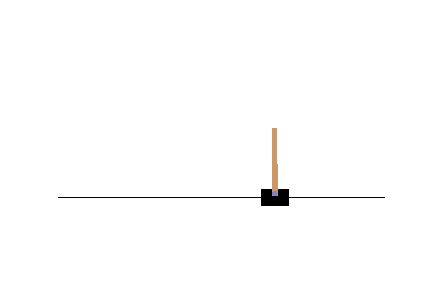
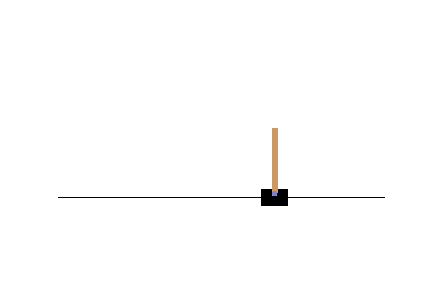
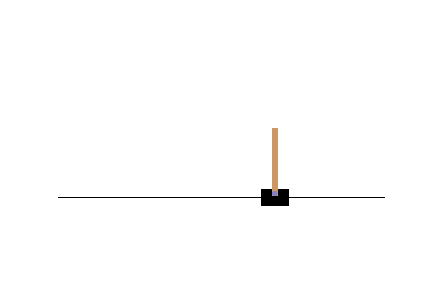
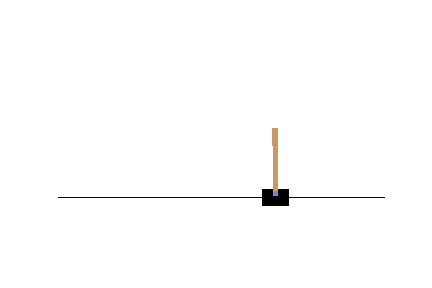
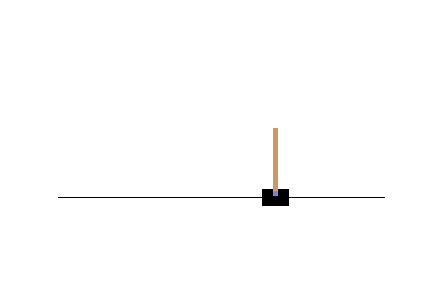
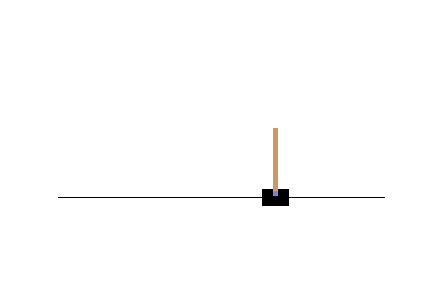
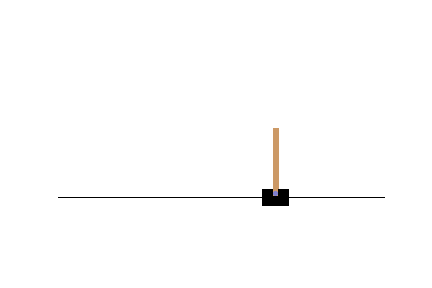
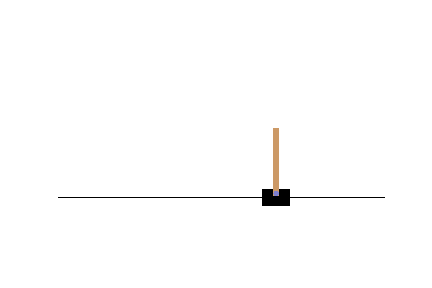
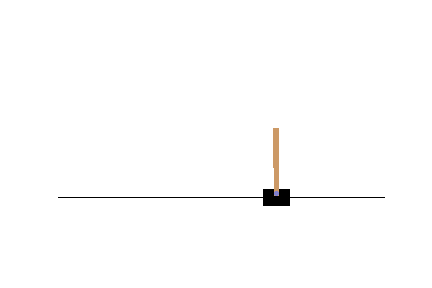
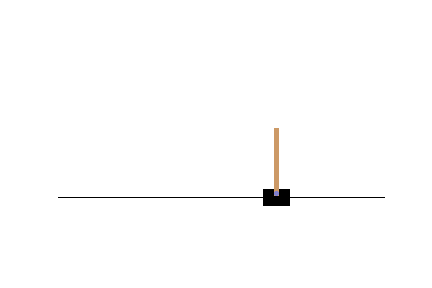
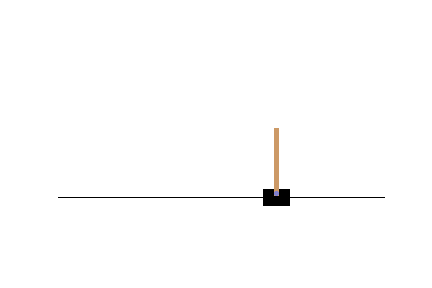
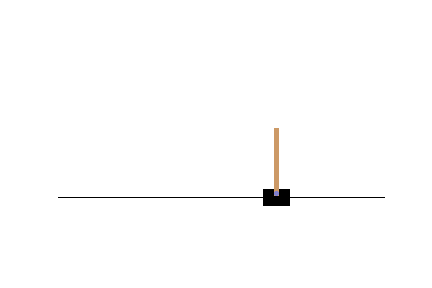
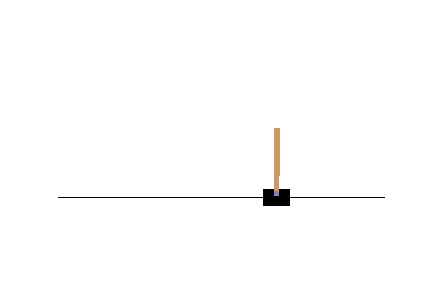
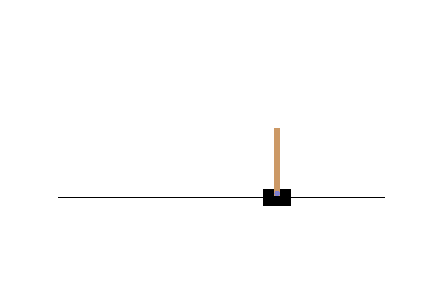
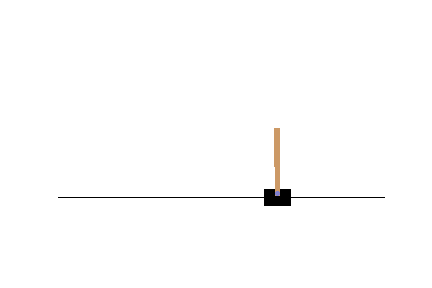
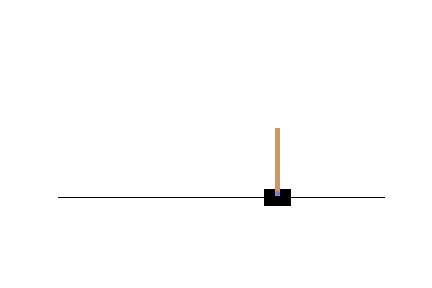
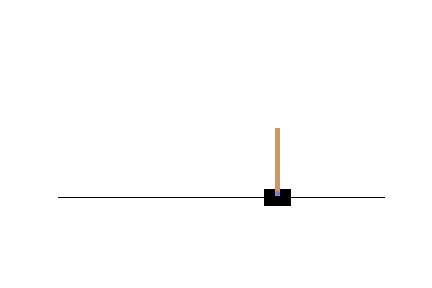
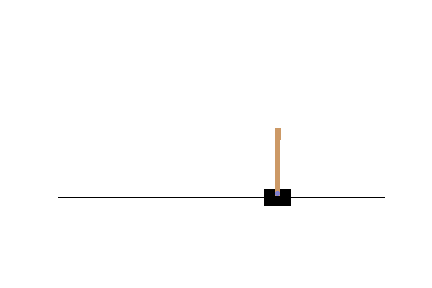
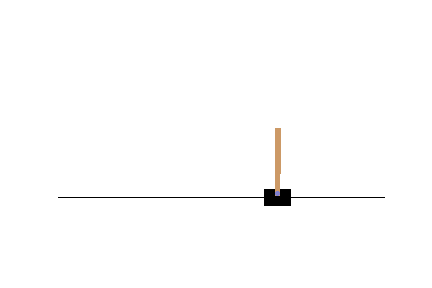
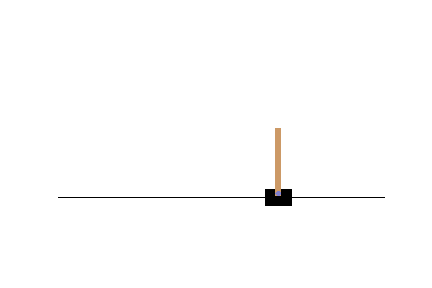
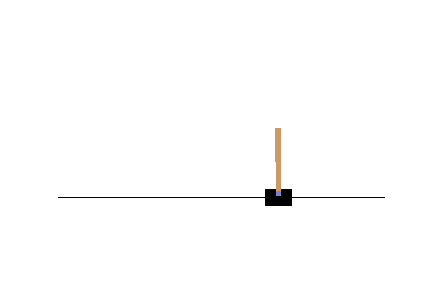
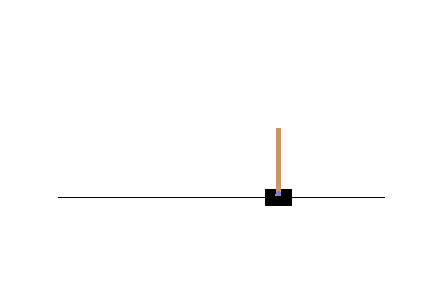
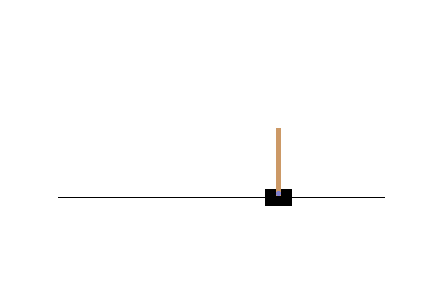
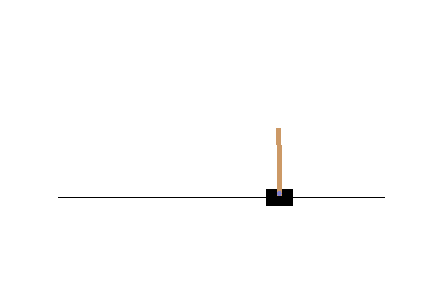
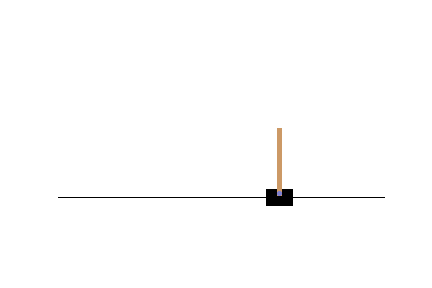
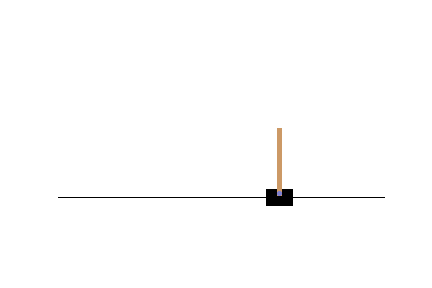
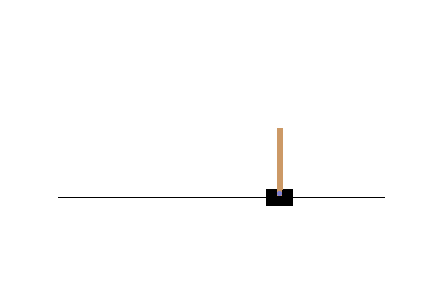
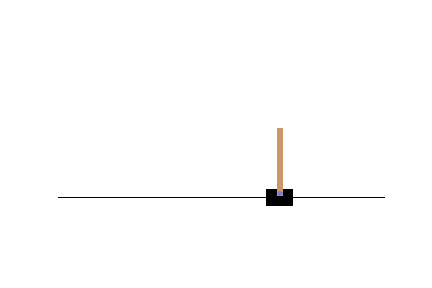
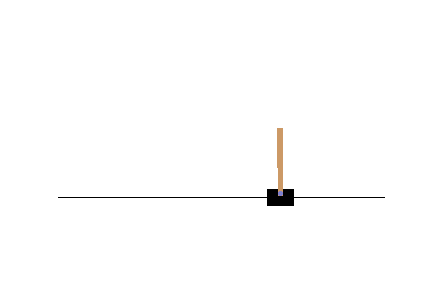
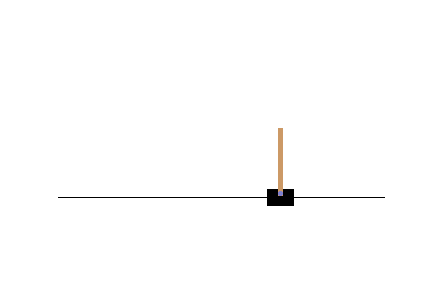
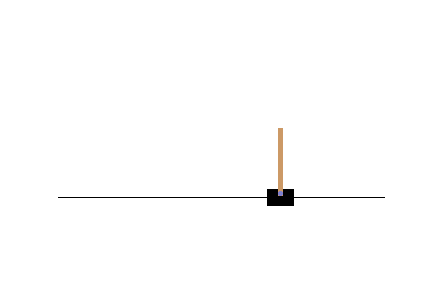
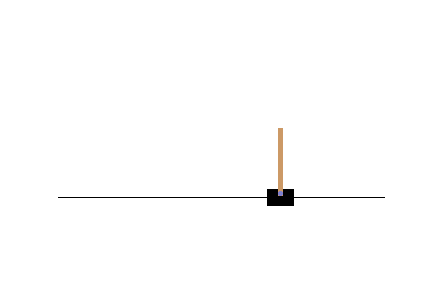
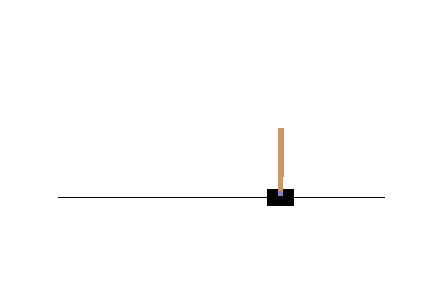
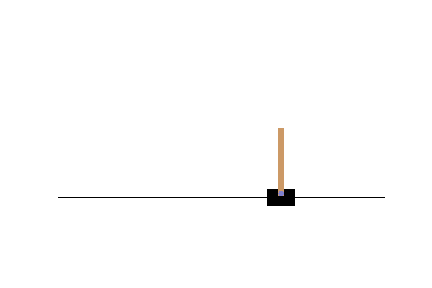
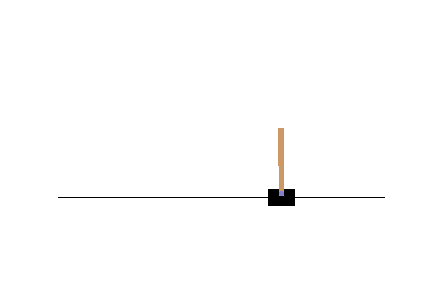
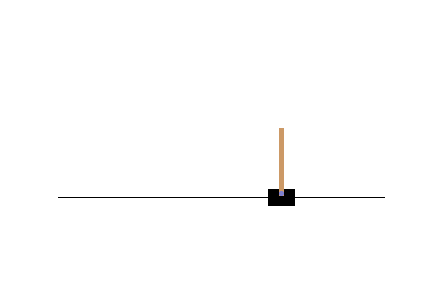
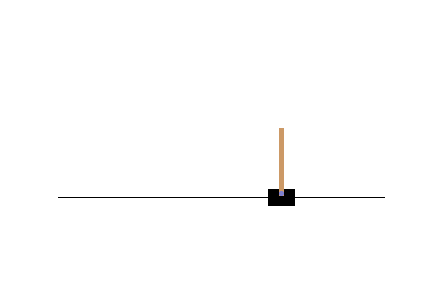
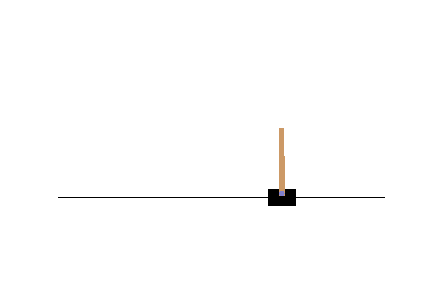
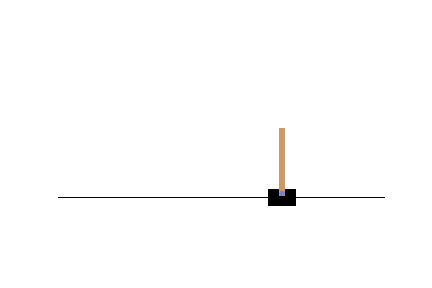
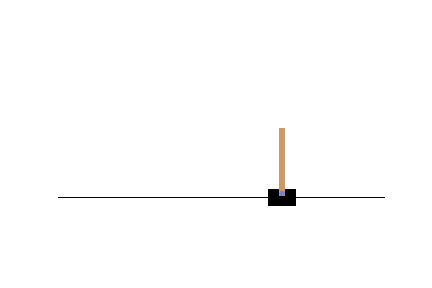
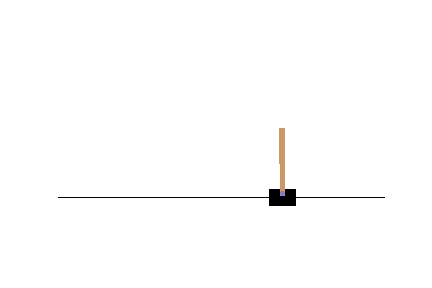
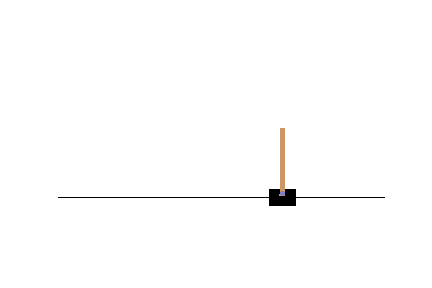
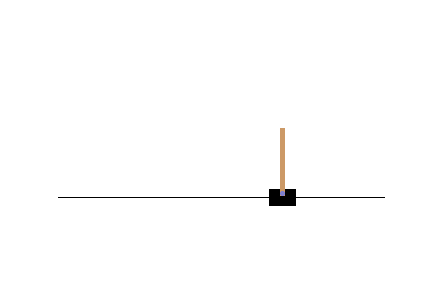
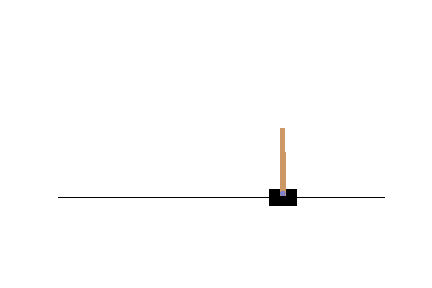
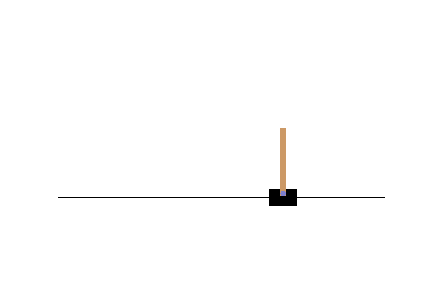
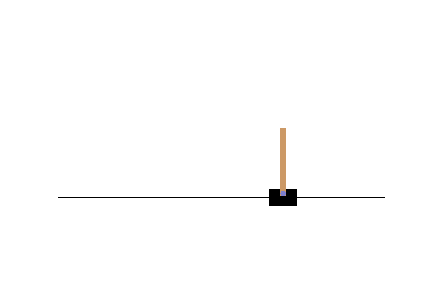
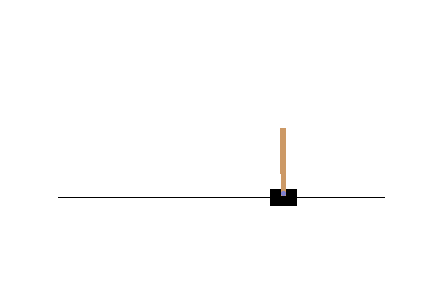
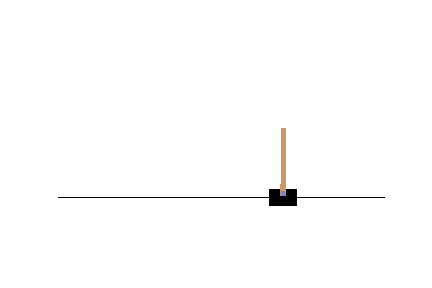
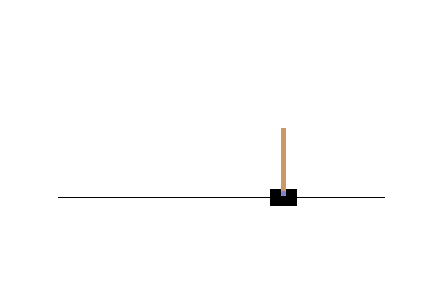
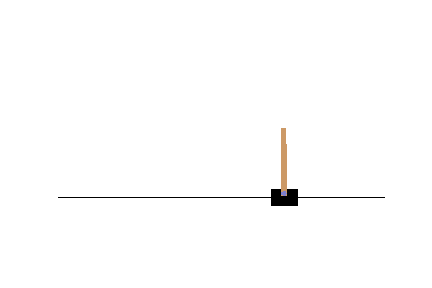
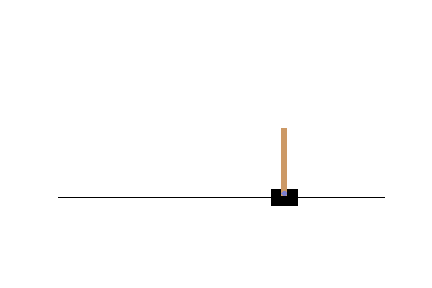
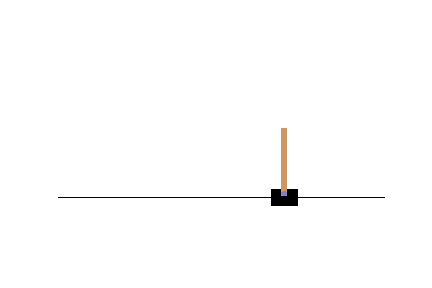
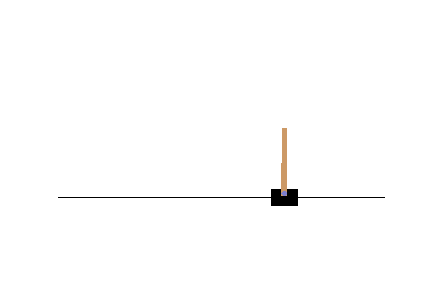
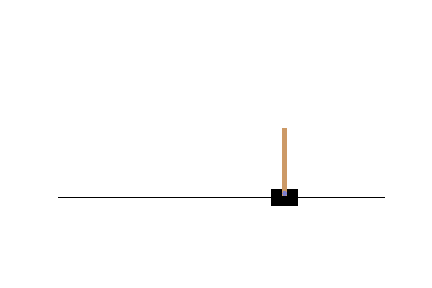
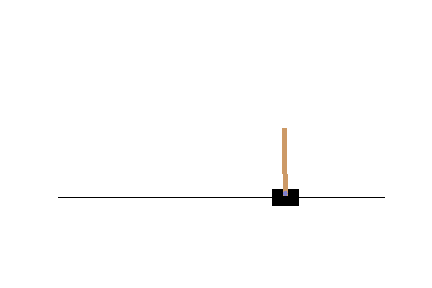
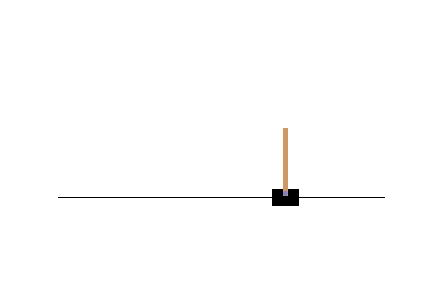
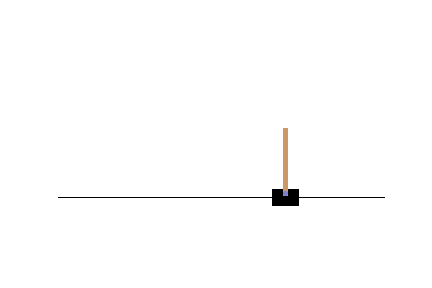
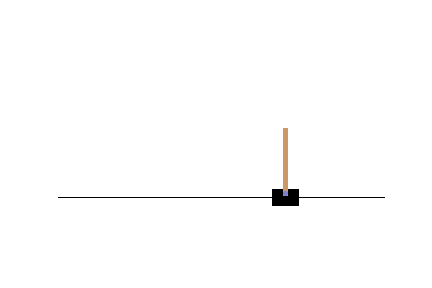
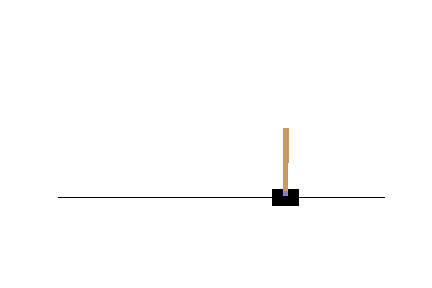
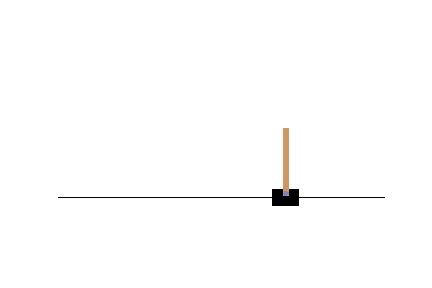
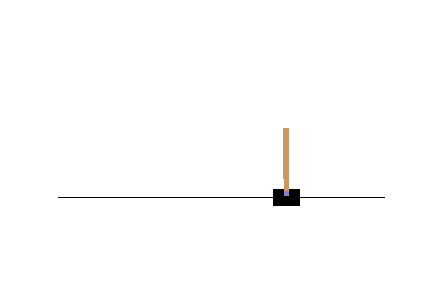
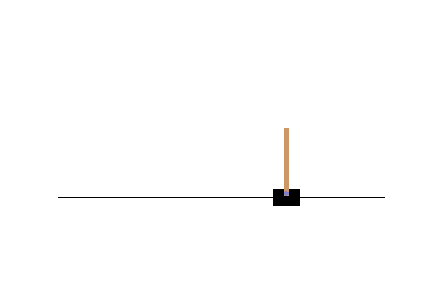
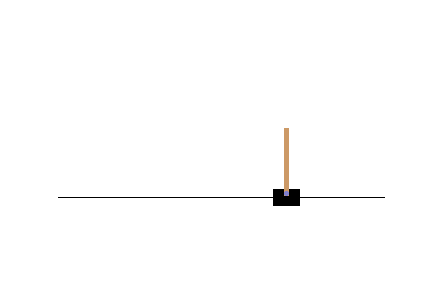
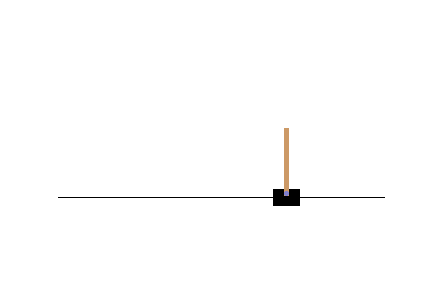
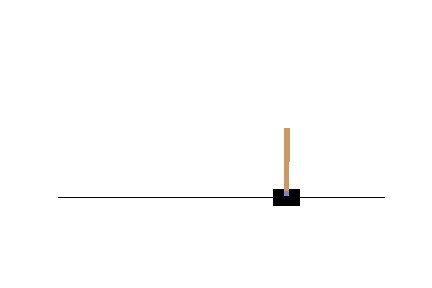
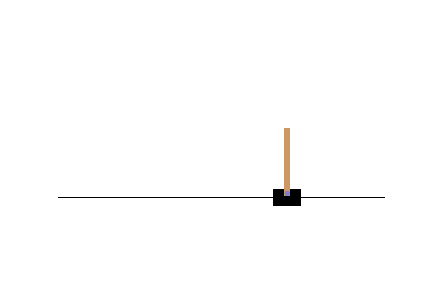
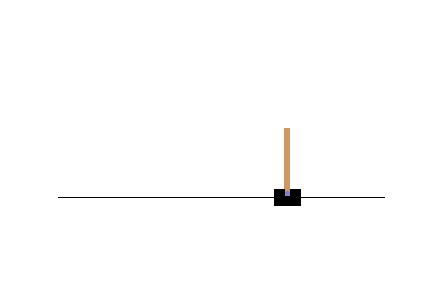
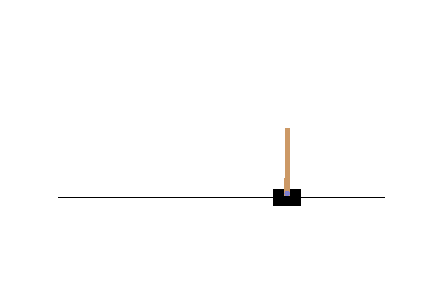
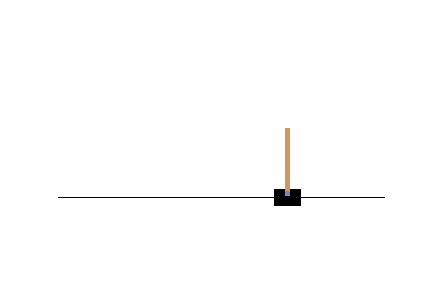
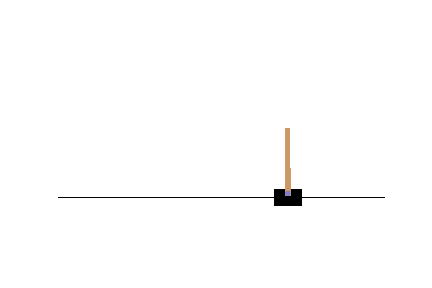
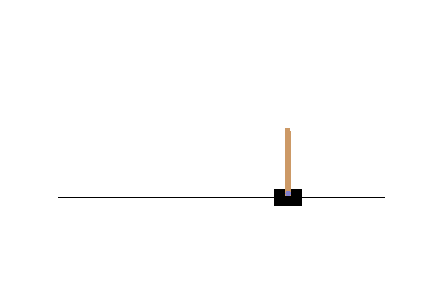
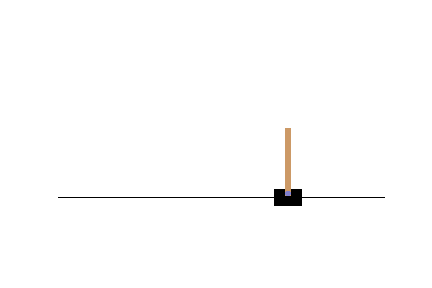
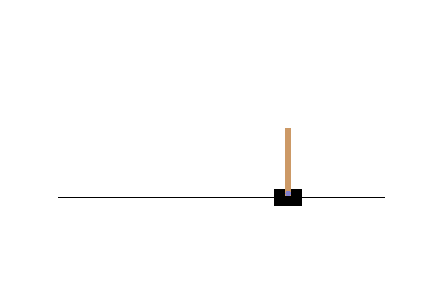
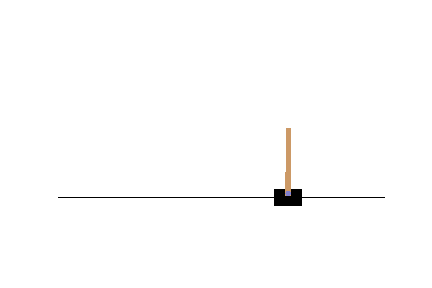
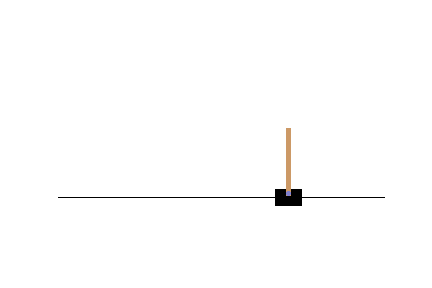
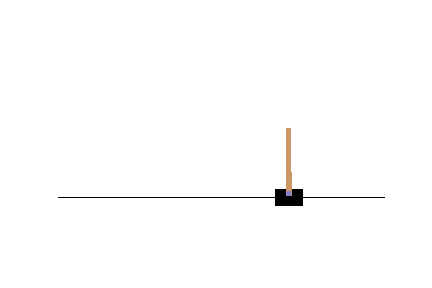
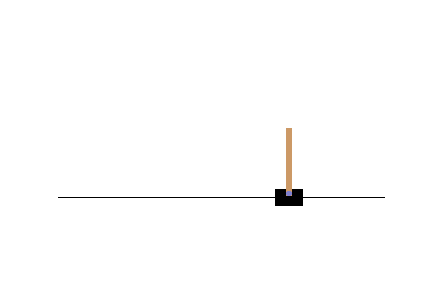
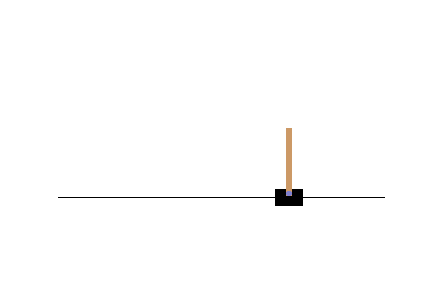
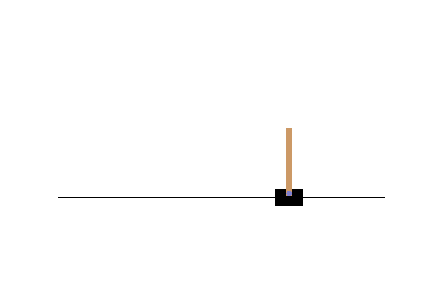
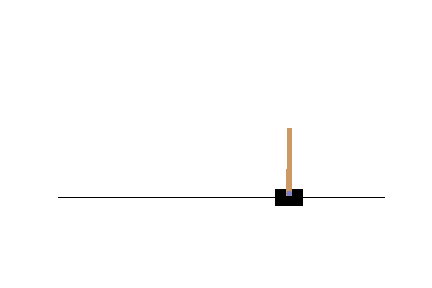
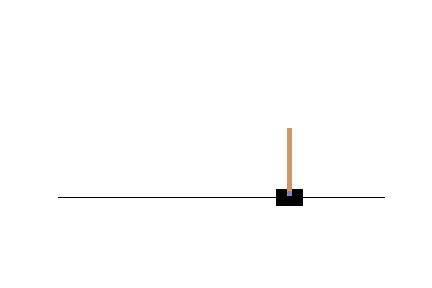
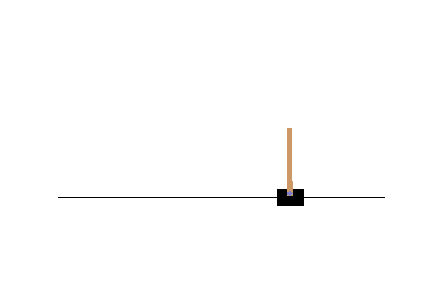
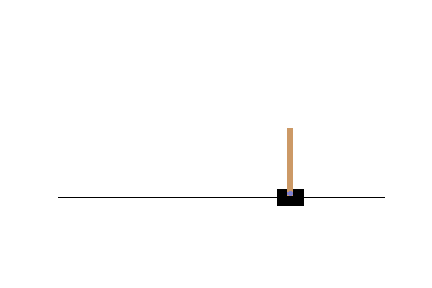
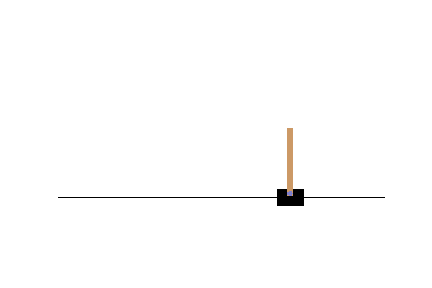
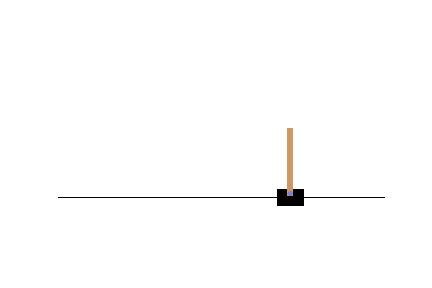
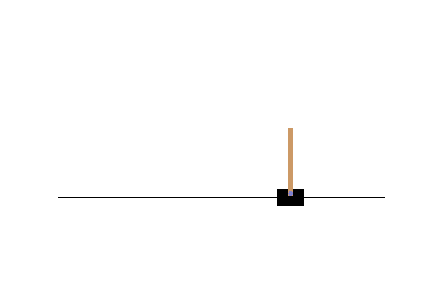
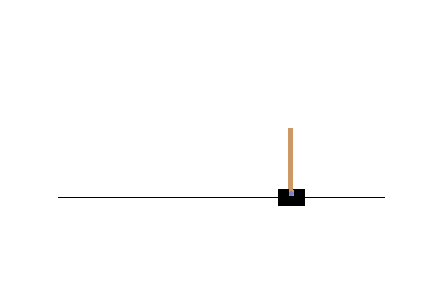
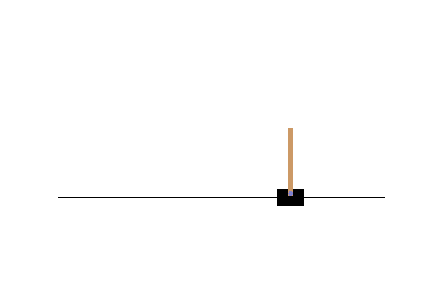
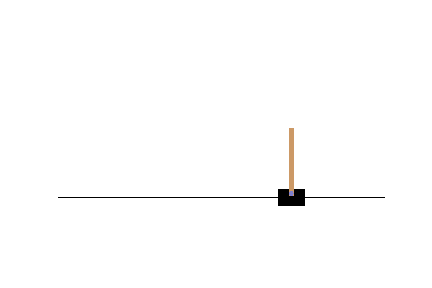
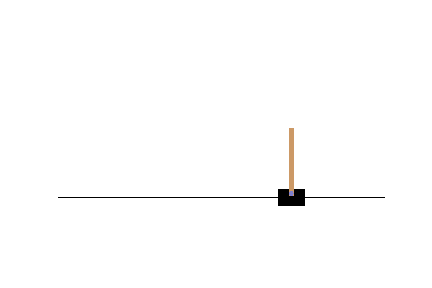
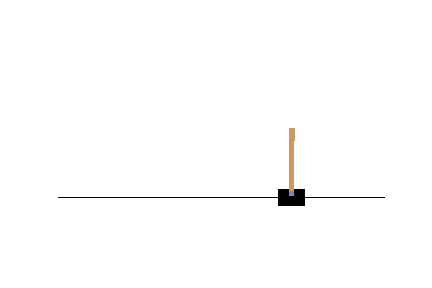
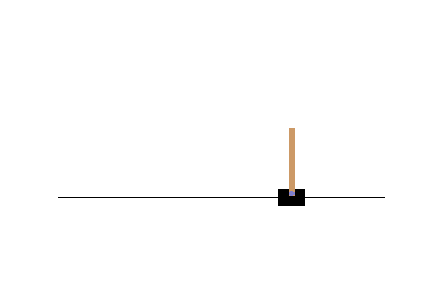
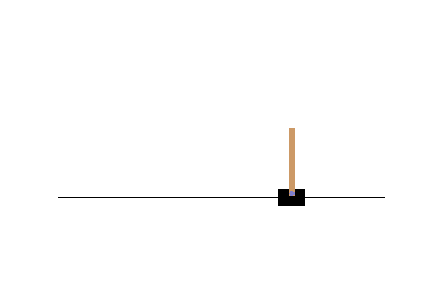
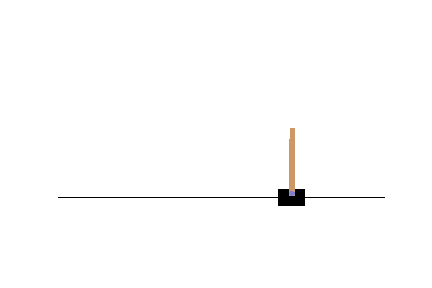
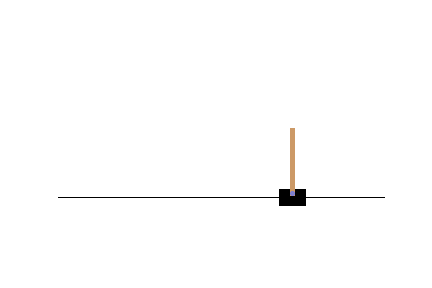
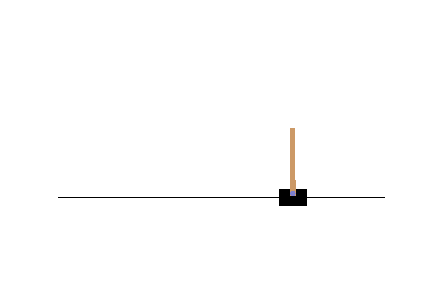
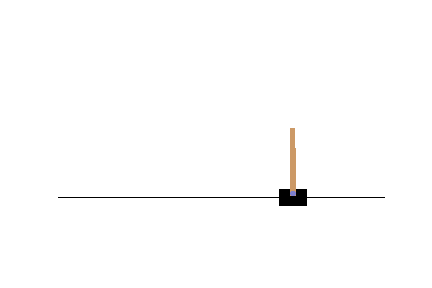
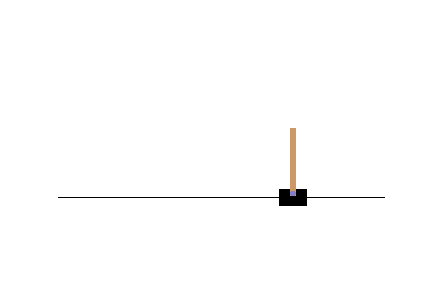
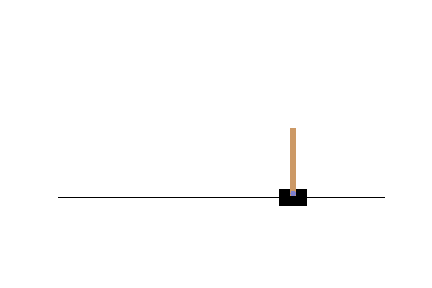
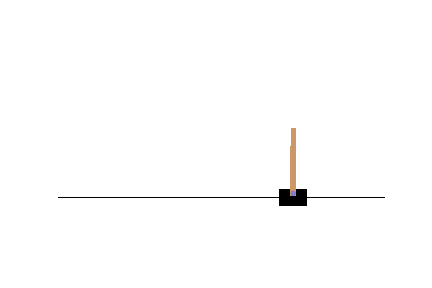
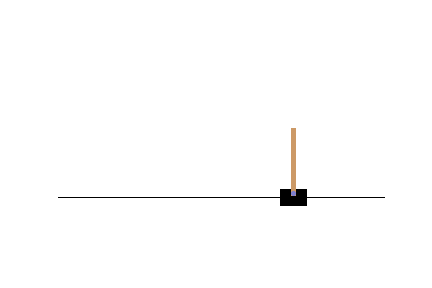
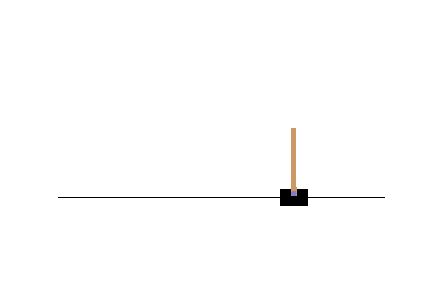
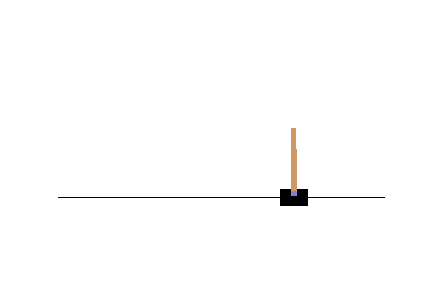
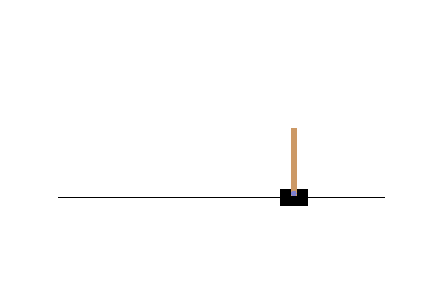
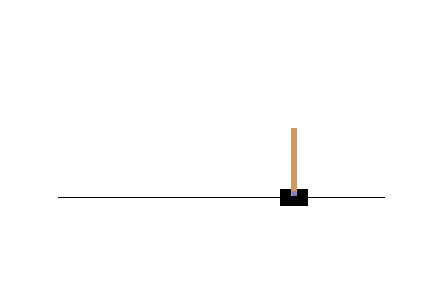
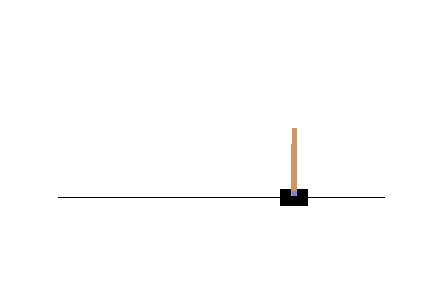
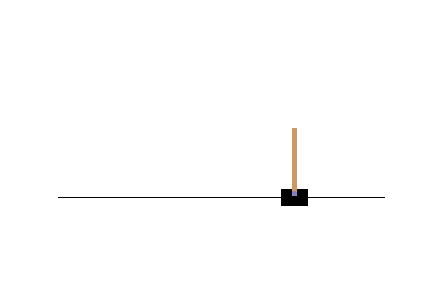
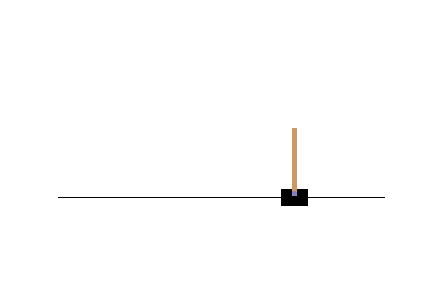
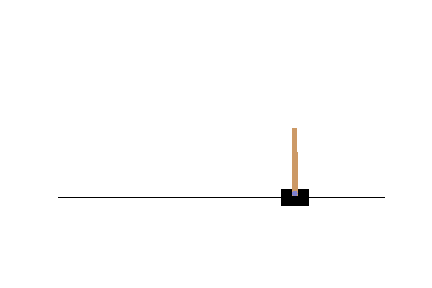
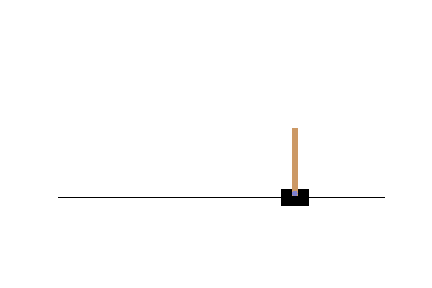
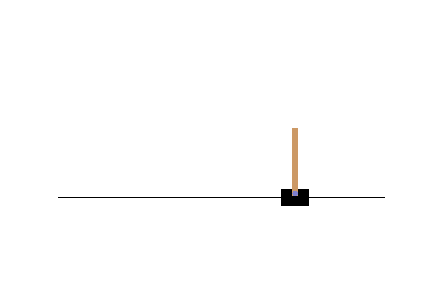
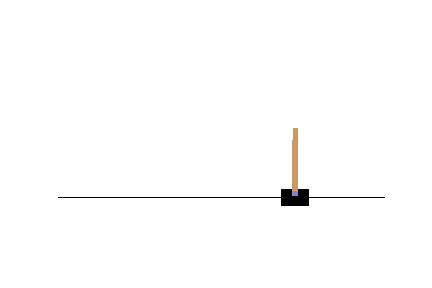
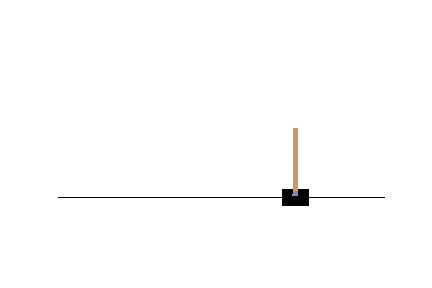
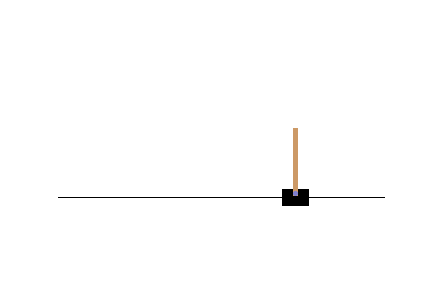
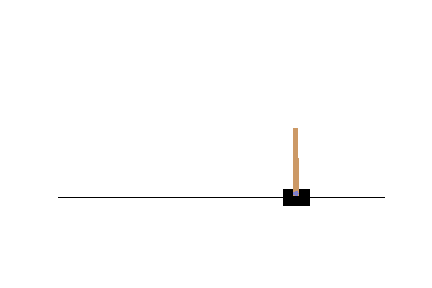
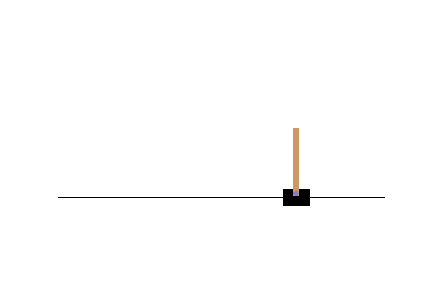
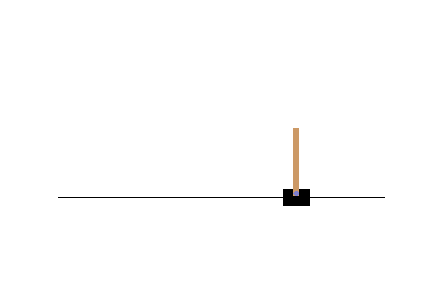
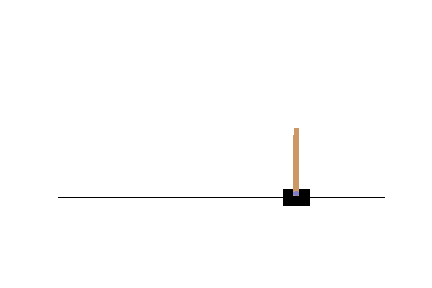
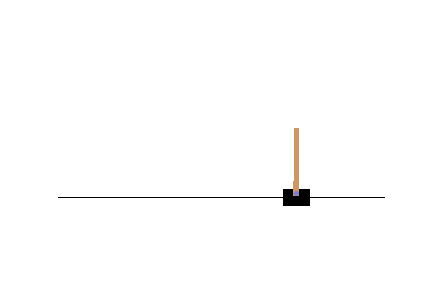
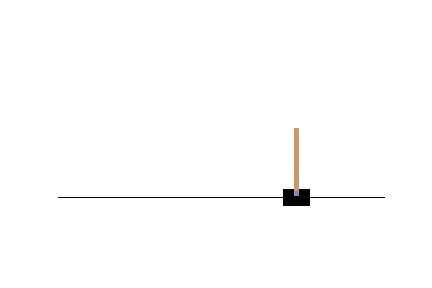
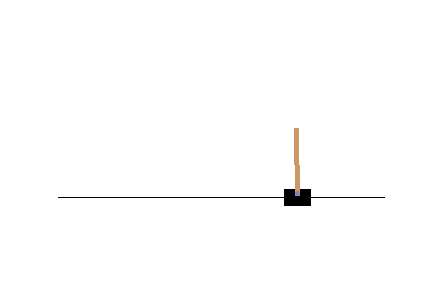
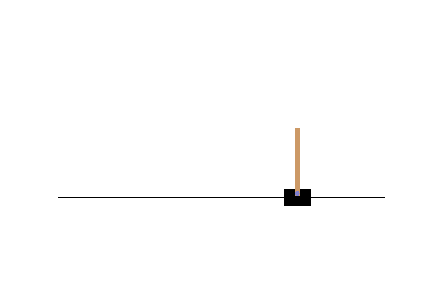
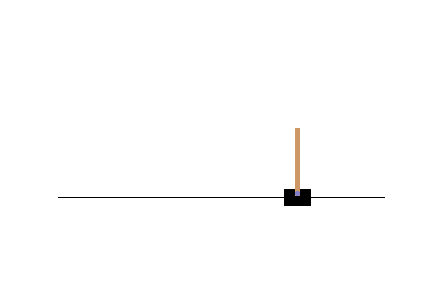
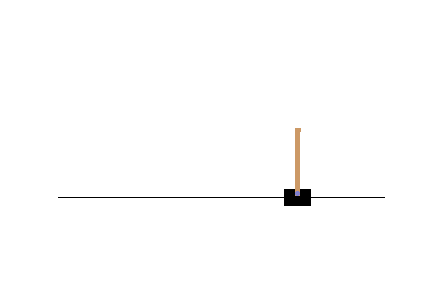
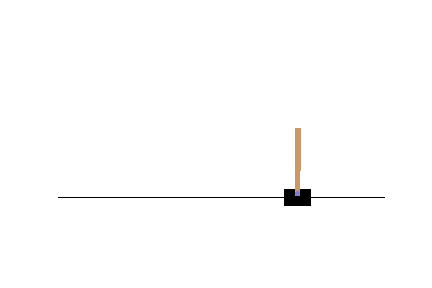
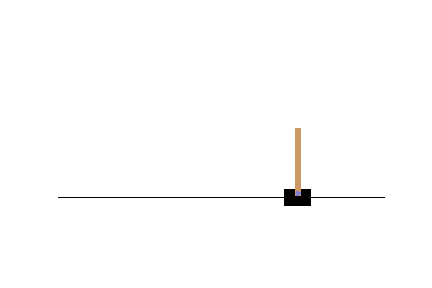
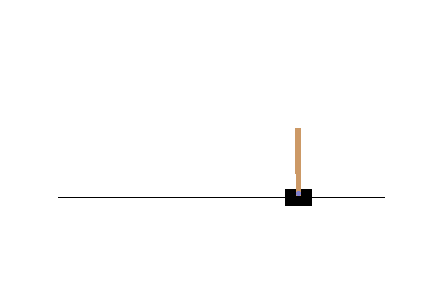
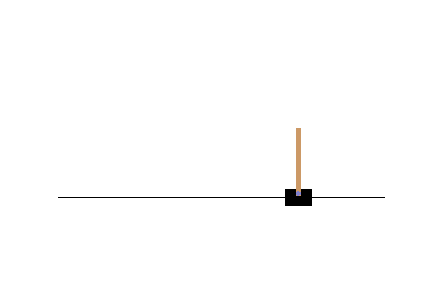
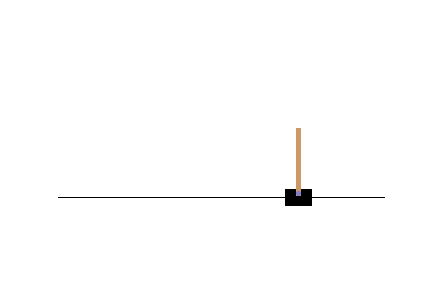
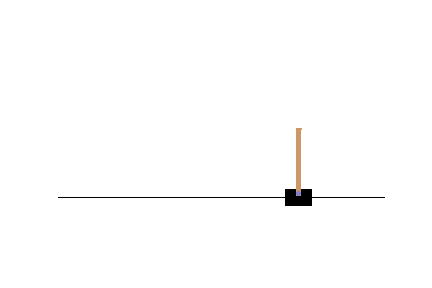
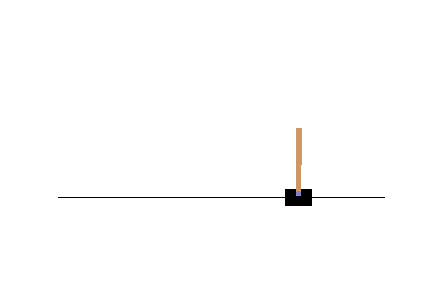
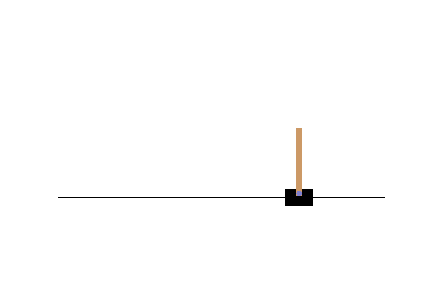
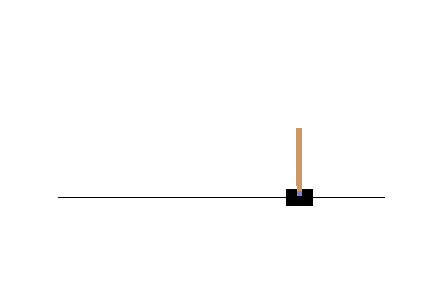
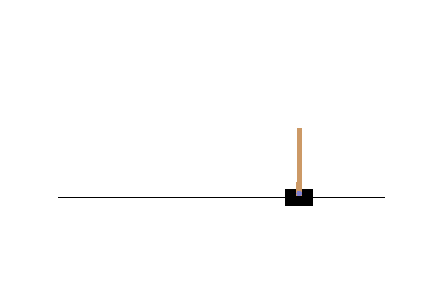
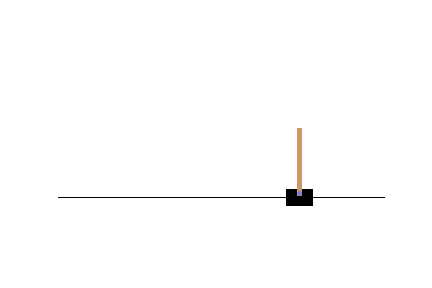
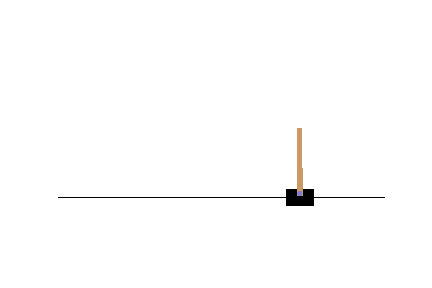
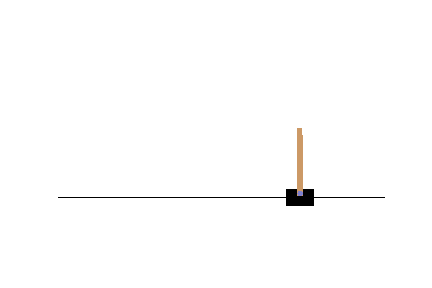
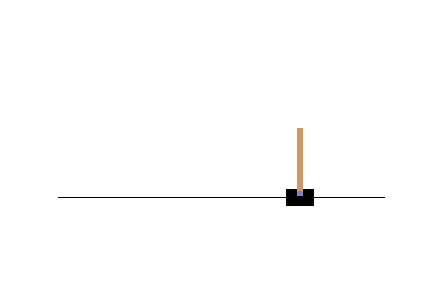
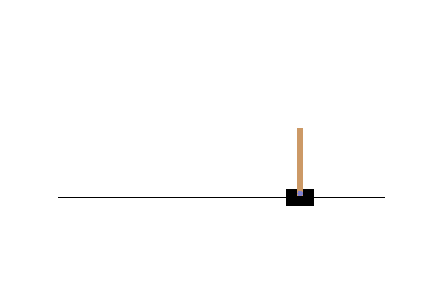
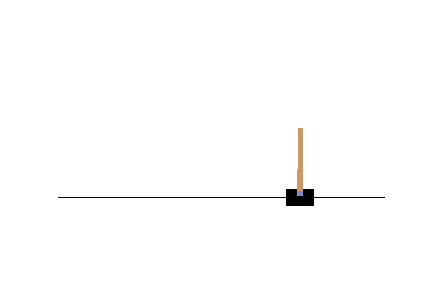
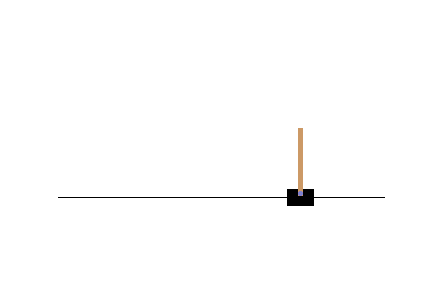
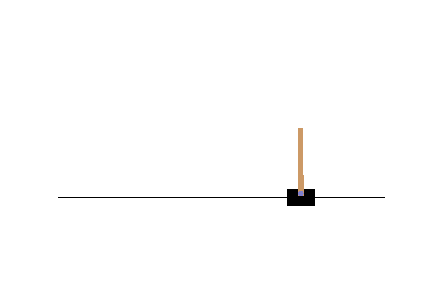
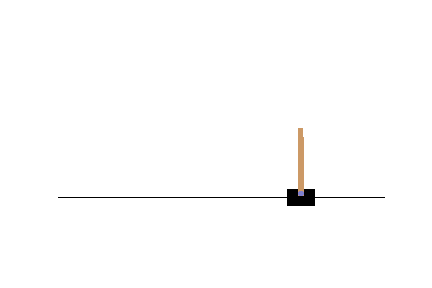
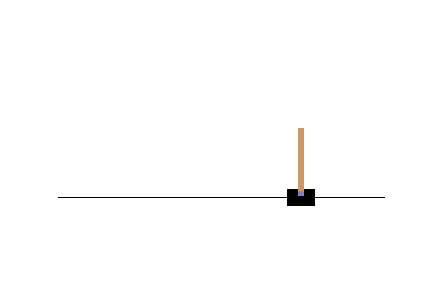
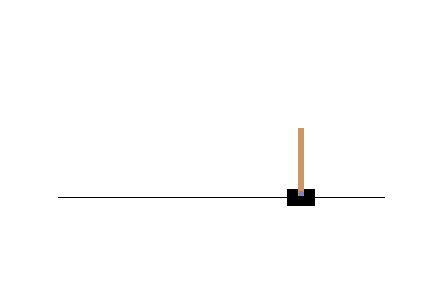
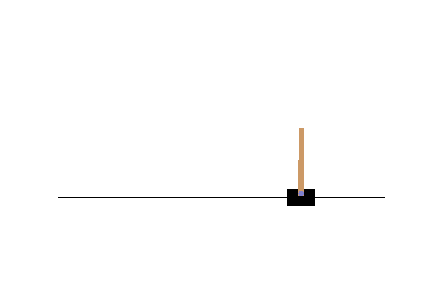
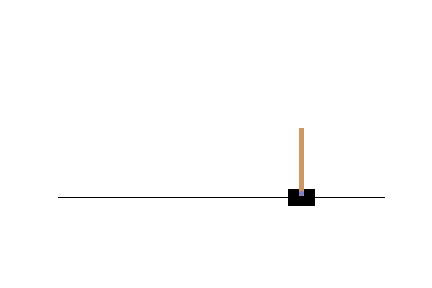
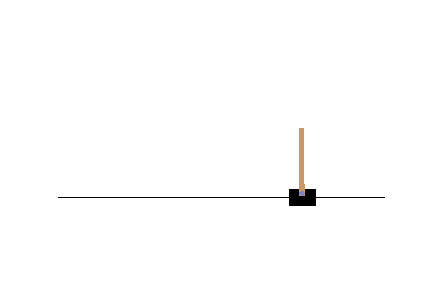
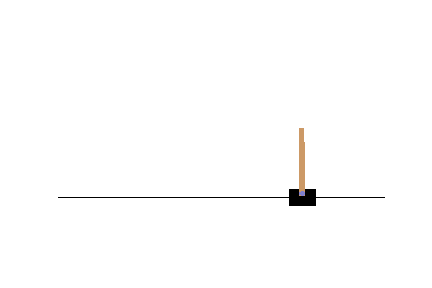
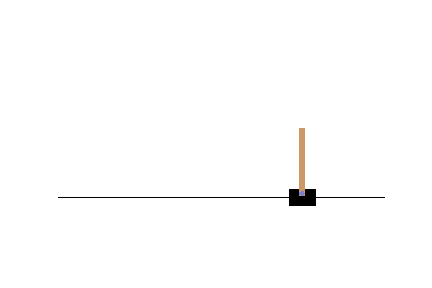
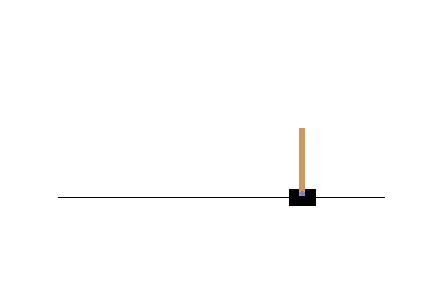
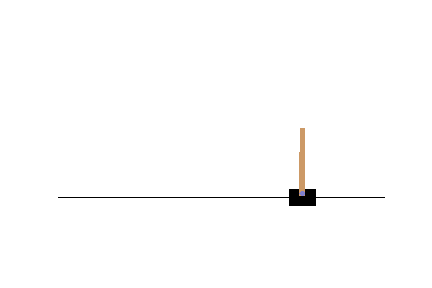
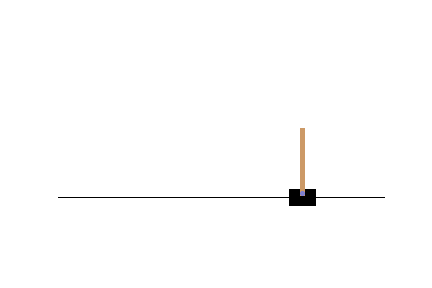
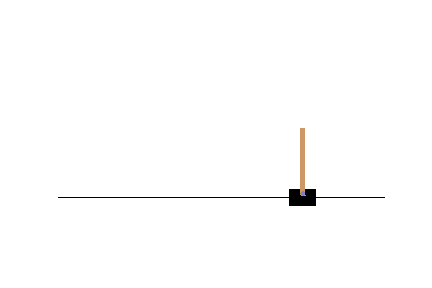
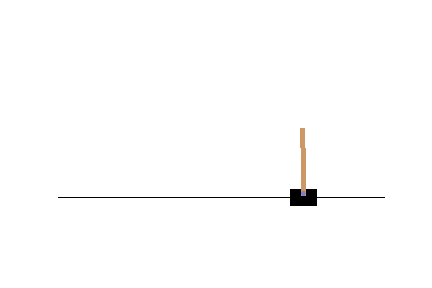
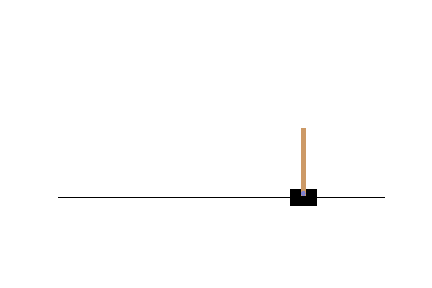
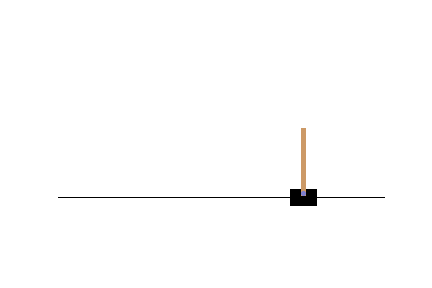
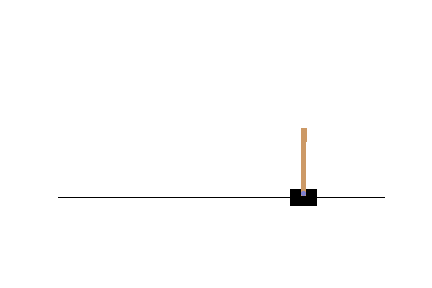
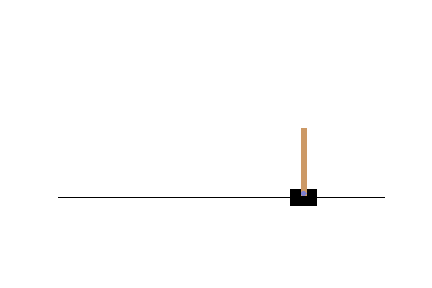
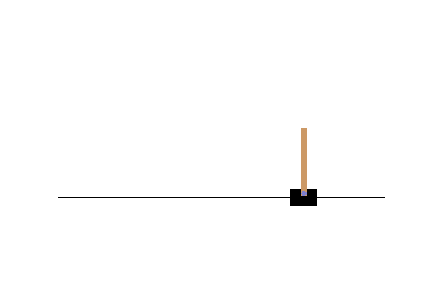
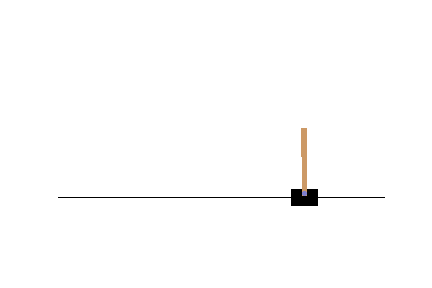
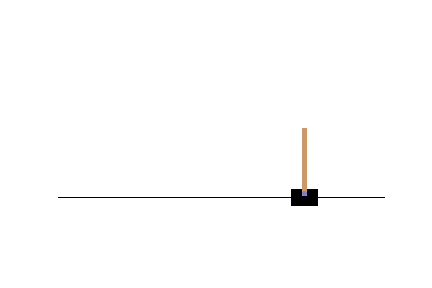
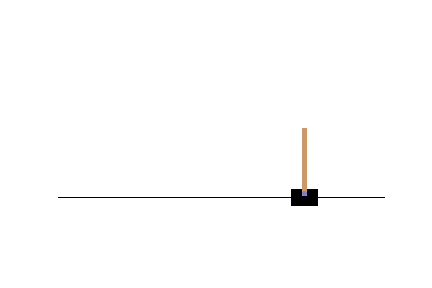
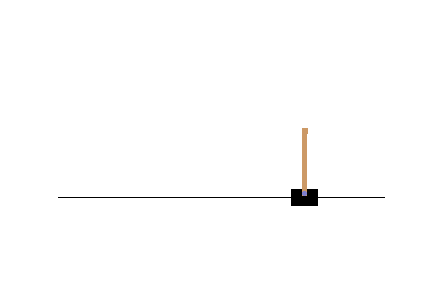
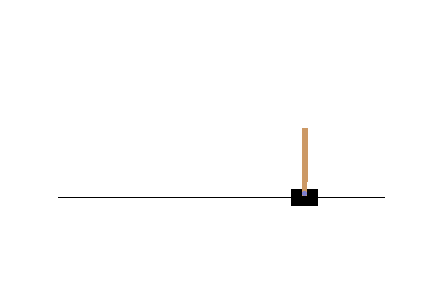
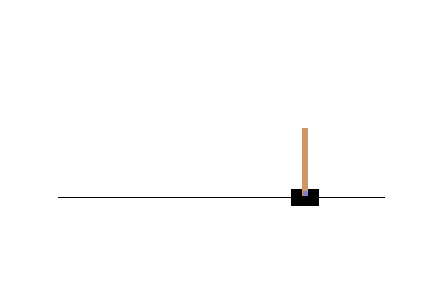
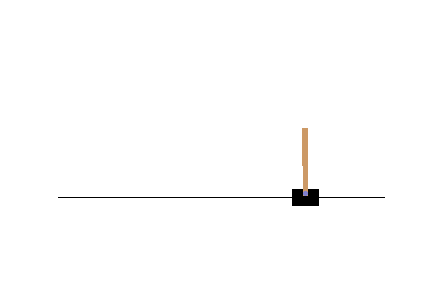
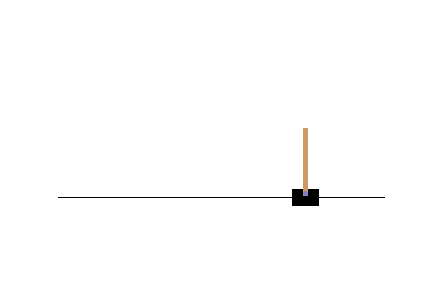
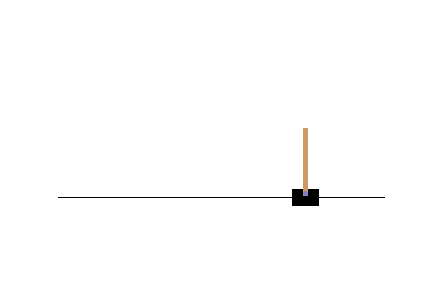
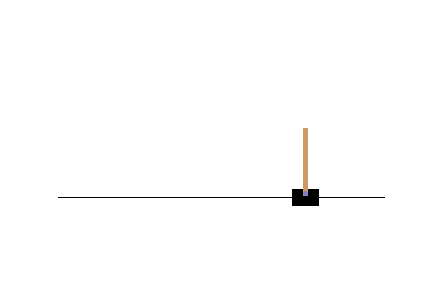
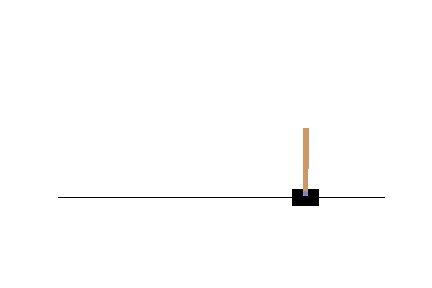
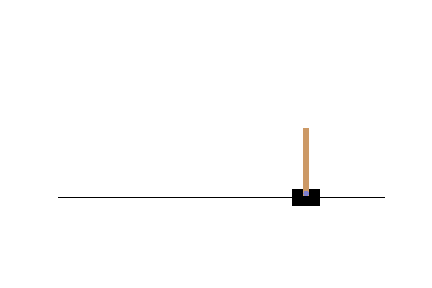
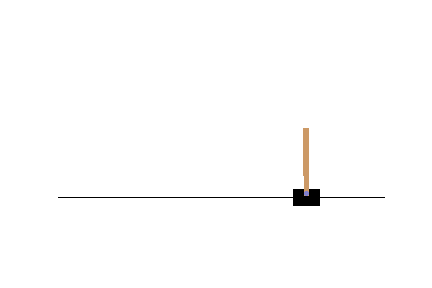
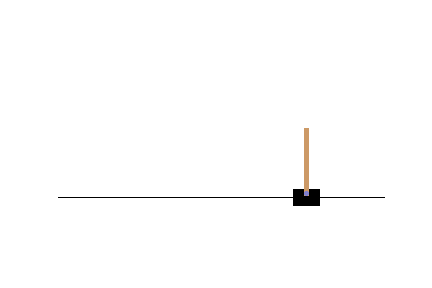
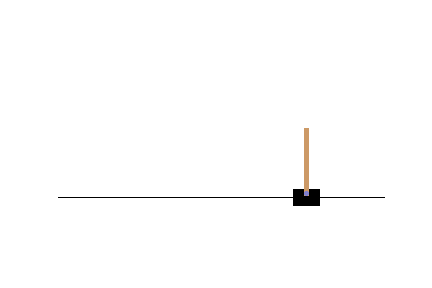
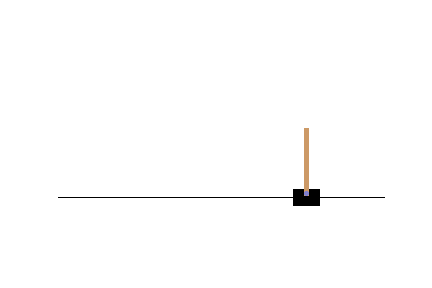
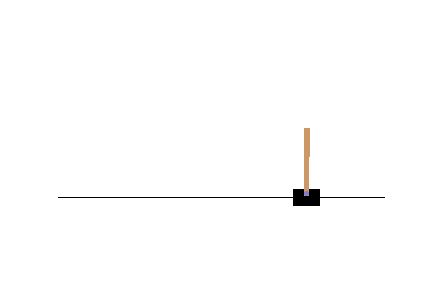
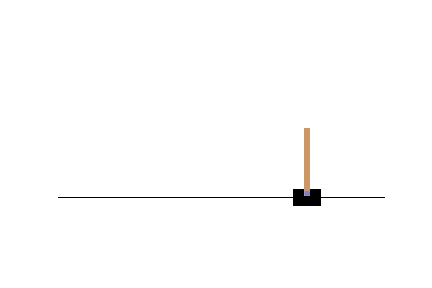
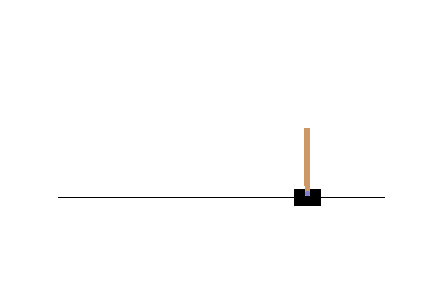
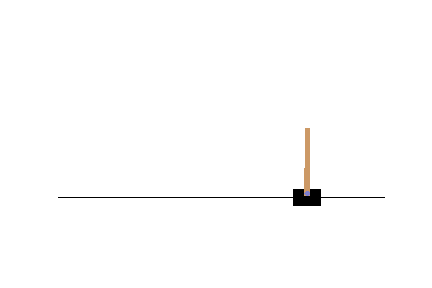
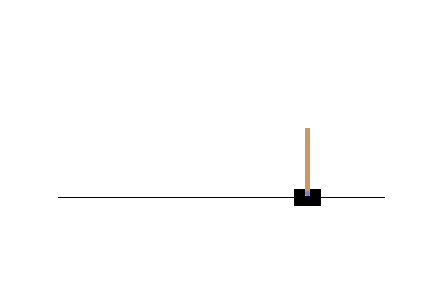
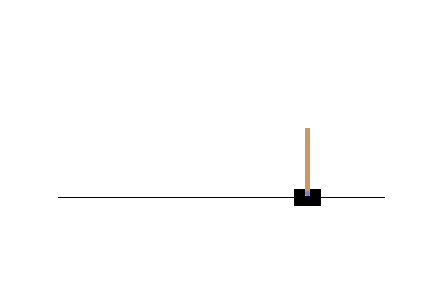
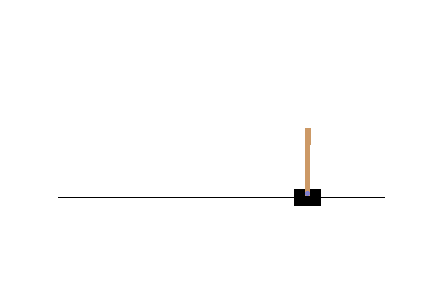
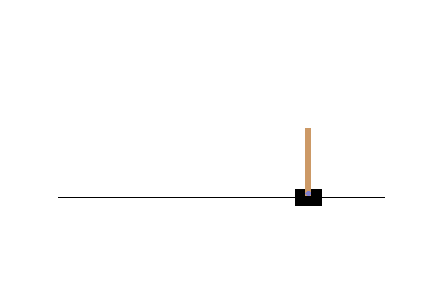
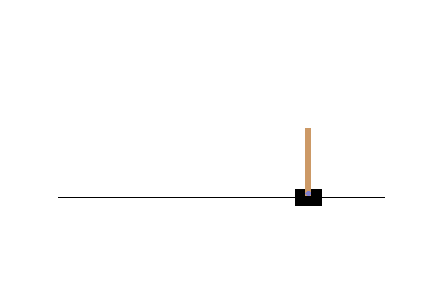
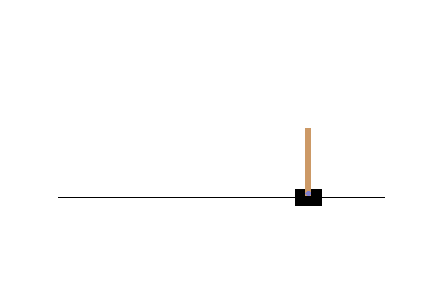
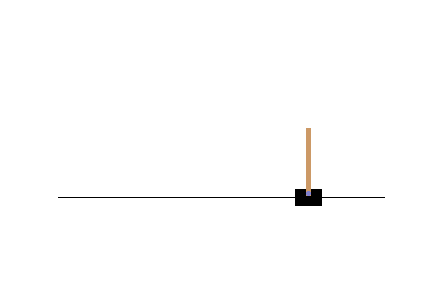
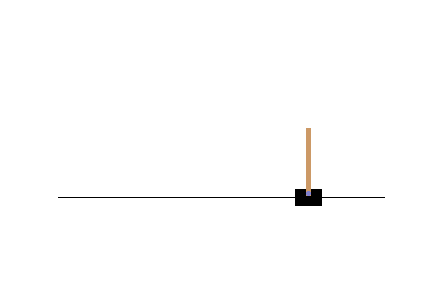
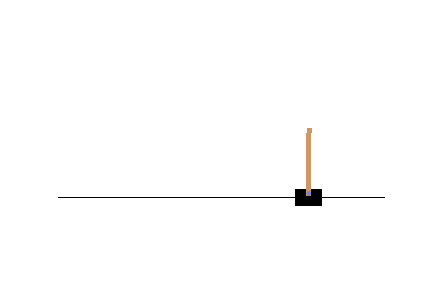
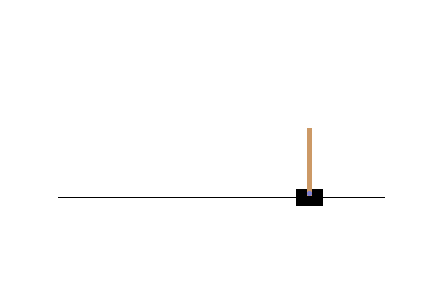
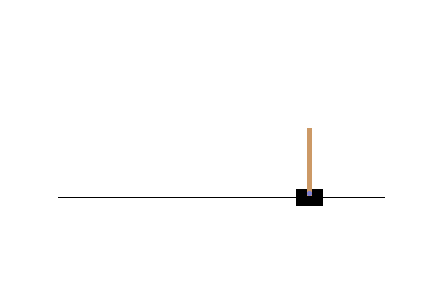
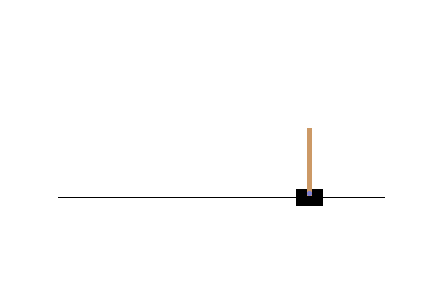
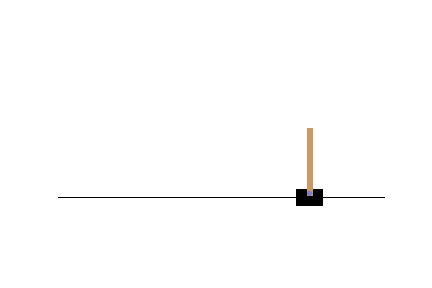
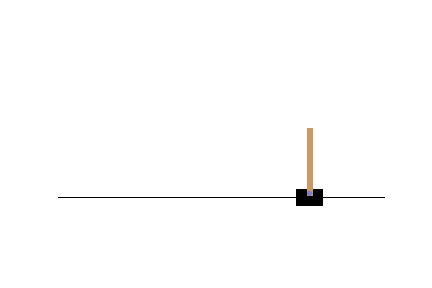
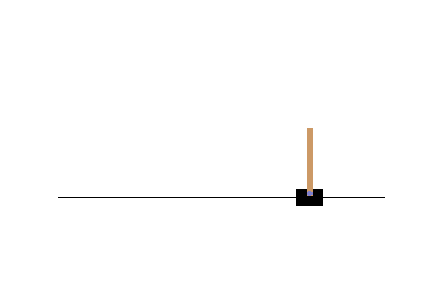
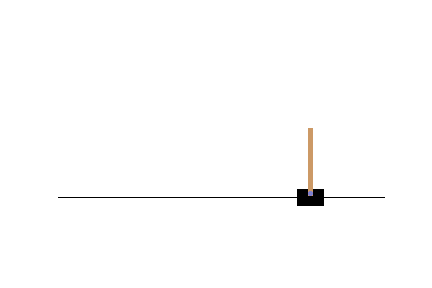
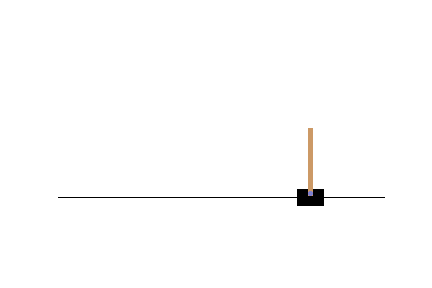
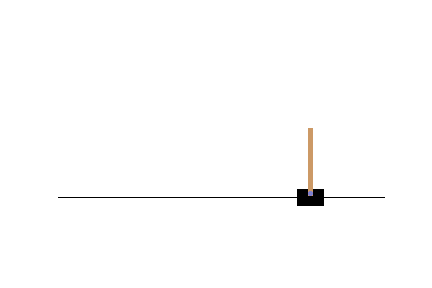
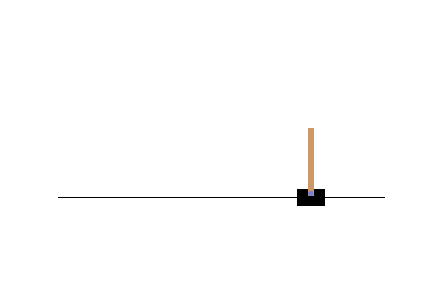
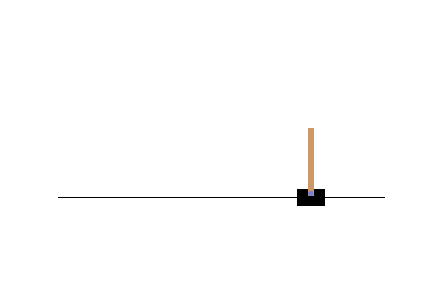
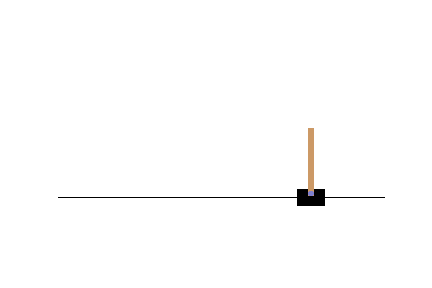
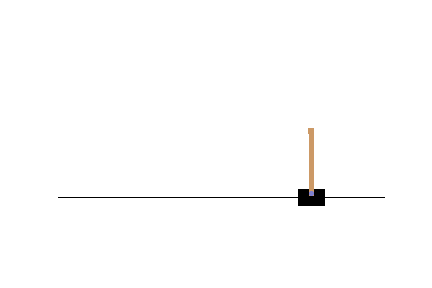
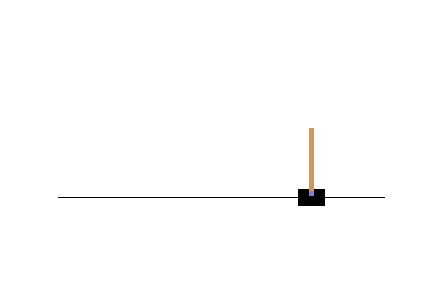
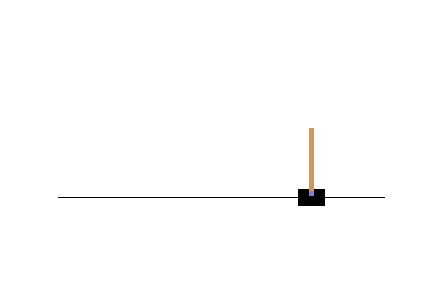
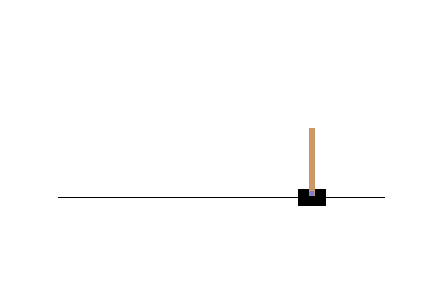
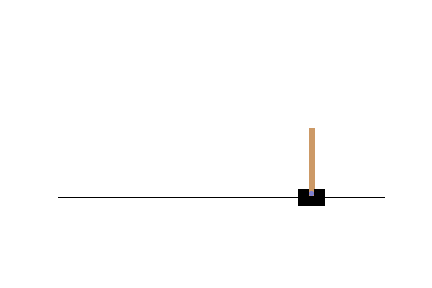
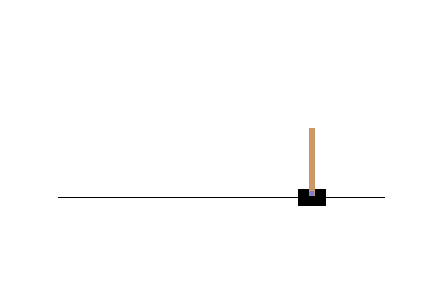
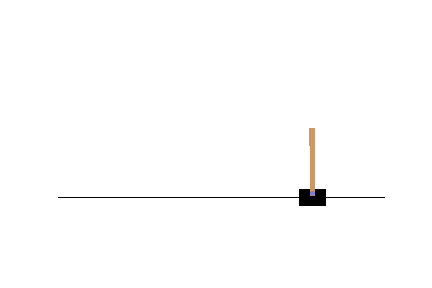
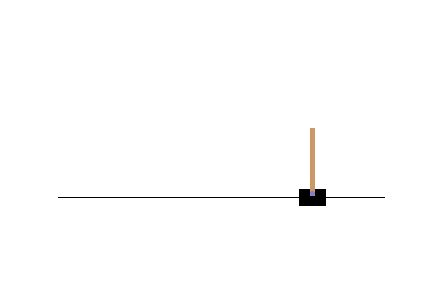
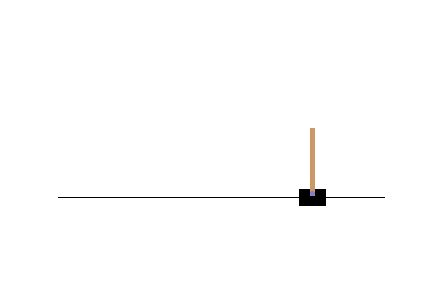
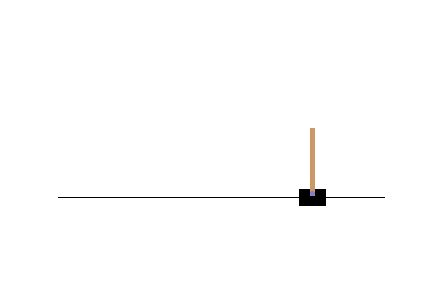
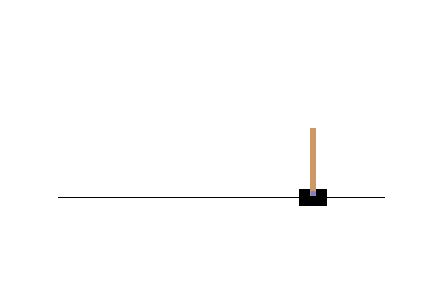

In [6]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# PPO Agent with Gaussian policy

## CLIPPE LOSS
### $L^{CLIP} = \frac{1}{N}\sum_{i} \min(r_i\cdot G_i,\text{clip}(r_i,1-\epsilon,1+\epsilon)\cdot G_{i}) $
### Return : $G_i = \sum_{k=0} \gamma^{k}R_{i+1+k}$
### Ratio : $r_i = \frac{\pi_{new}(a_i|s_i)}{\pi_{old}(a_i|s_i)} = \exp(\log(\pi_{new}(a_{i}|s_{i})) - \log(\pi_{old}(a_{i}|s_{i})))$

### If $\pi(\cdot|s) = \mathcal{N}( \mu(s), \Sigma)$ where $\Sigma$ is a diagonal matrix, i.e., $\Sigma = [(\sigma^{j})^2]$, then
### $\log(\pi(a|s)) = \sum_{j=0}^{D} \left[- \frac{1}{2}\left(\frac{a - \mu^{j}(s)}{\sigma}\right)^{2} - \log(\sigma^{j}) - \frac{1}{2}\log(2\pi)\right]$
### Note : the covariance matrix is state independent !! (often used in Open AI codes)

In [7]:
class PPOAgent_gaussian(object):
    def __init__(self, obs_dim, act_dim, clip_range=0.2,
                 epochs=10, lr=3e-5, hdim=64, max_std=1.0,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.clip_range = clip_range
        
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.max_std = max_std
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._kl_entropy()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.socres_ph = tf.placeholder(tf.float32, (None,), 'scores')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
        # place holder for old parameters
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_std')
        self.old_mean_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_means')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        
        # MEAN FUNCTION
        self.mean = 
        
        # UNI-VARIATE
        self.logits_std = 
        self.std = self.max_std*tf.ones_like(self.mean)*tf.sigmoid(self.logits_std) # IMPORTANT TRICK
        
        # SAMPLE OPERATION
        self.sample_action = self.mean + tf.random_normal(tf.shape(self.mean),seed=self.seed)*self.std
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER
        y = self.act_ph 
        mu = self.mean
        sigma = self.std
        
        self.logp = 
        
        # PROBABILITY WITH OLD (PREVIOUS) PARAMETER
        old_mu_ph = self.old_mean_ph
        old_sigma_ph = self.old_std_ph
                
        self.logp_old = 
        
    def _kl_entropy(self):

        mean, std = self.mean, self.std
        old_mean, old_std = self.old_mean_ph, self.old_std_ph
 
        log_std_old = tf.log(old_std)
        log_std_new = tf.log(std)
        frac_std_old_new = old_std/std

        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(log_std_new - log_std_old + 0.5*tf.square(frac_std_old_new) + 0.5*tf.square((mean - old_mean)/std)- 0.5,axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = tf.reduce_sum(log_std_new + 0.5 + 0.5*np.log(2*np.pi),axis=1)
        self.entropy = tf.reduce_mean(entropy)
        
    def _loss_train_op(self):
        
        # Proximal Policy Optimization CLIPPED LOSS FUNCTION
        ratio = tf.exp(self.logp - self.logp_old) 
        clipped_ratio = tf.clip_by_value(ratio,clip_value_min=1-self.clip_range,clip_value_max=1+self.clip_range) 
        self.loss = -tf.reduce_mean(tf.minimum(self.socres_ph*ratio,self.socres_ph*clipped_ratio))
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        obs = obs.squeeze()
        feed_dict = {self.obs_ph: [obs]}
        sampled_action = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action
    
    def control(self, obs): # COMPUTE MEAN
        obs = obs.squeeze()
        feed_dict = {self.obs_ph: [obs]}
        best_action = self.sess.run(self.mean,feed_dict=feed_dict)
        return best_action        
    
    def update(self, observes, actions, scores, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_means_np, old_std_np = self.sess.run([self.mean, self.std],{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        for e in range(self.epochs):
            observes, actions, scores, old_means_np, old_std_np = shuffle(observes, actions, scores, old_means_np, old_std_np, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end,:],
                     self.socres_ph: scores[start:end],
                     self.old_std_ph: old_std_np[start:end,:],
                     self.old_mean_ph: old_means_np[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
        feed_dict = {self.obs_ph: observes,
                 self.act_ph: actions,
                 self.socres_ph: scores,
                 self.old_std_ph: old_std_np,
                 self.old_mean_ph: old_means_np,
                 self.lr_ph: self.lr}             
        loss, kl, entropy = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
        return loss, kl, entropy
    
    def close_sess(self):
        self.sess.close()

# Helper Function for Training 

In [8]:
def run_episode(env, agent, animate=False, evaluation=False): # Run policy and collect (state, action, reward) pairs
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        if evaluation:
            action = agent.control(obs).reshape((1, -1)).astype(np.float32)
        else:
            action = agent.get_action(obs).reshape((1, -1)).astype(np.float32)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.concatenate(actions), np.array(rewards, dtype=np.float32), infos)

def run_policy(env, agent, episodes, evaluation=False): # collect trajectories. if 'evaluation' is ture, then only mean value of policy distribution is used without sampling.
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, agent, evaluation=evaluation)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

def build_train_set(trajectories):
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    returns = np.concatenate([t['returns'] for t in trajectories])
    
    return observes, actions, returns

def compute_returns(trajectories, gamma=0.995): # Add value estimation for each trajectories
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        returns = np.zeros_like(rewards)
        g = 0
        for t in reversed(range(len(rewards))):
            g = rewards[t] + gamma*g
            returns[t] = g
        trajectory['returns'] = returns

# Define Environment and Agent

In [9]:
env = gym.make('MountainCarContinuous-v0')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_space = env.observation_space
act_space= env.action_space

print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("Dimension:{}".format(obs_space.shape[0]))
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

print('Observation space')
print(type(act_space))
print(act_space.shape)
print("Dimension:{}".format(act_space.shape[0]))
print("High: {}".format(act_space.high))
print("Low: {}".format(act_space.low))
print()

obs_dim = obs_space.shape[0]
act_dim = act_space.shape[0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space
<class 'gym.spaces.box.Box'>
(2,)
Dimension:2
High: [0.6  0.07]
Low: [-1.2  -0.07]

Observation space
<class 'gym.spaces.box.Box'>
(1,)
Dimension:1
High: [1.]
Low: [-1.]



# Training

In [10]:
agent = PPOAgent_gaussian(obs_dim, act_dim, epochs=10,
                          hdim=64, lr=3e-4, max_std=1.0,
                          clip_range=0.3, seed=seed)

avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)

episode_size = 1
batch_size = 64
nupdates = 600

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episode_size)
    compute_returns(trajectories)
    observes, actions, returns = build_train_set(trajectories)

    pol_loss, kl, entropy = agent.update(observes, actions, returns, batch_size=batch_size)

    avg_loss_list.append(pol_loss)
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%100) == 0:
        print('[{}/{}] return : {:.3f},  policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(
            update, nupdates, np.mean(avg_return_list), np.mean(avg_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > 90): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

[0/600] return : -25.002,  policy loss : 3.946, policy kl : 0.00000, policy entropy : 0.723
[100/600] return : -30.737,  policy loss : 4.906, policy kl : 0.00044, policy entropy : 0.781
[200/600] return : -33.851,  policy loss : 5.386, policy kl : 0.00017, policy entropy : 0.869
[300/600] return : 87.632,  policy loss : -51.512, policy kl : 0.00525, policy entropy : 0.528
[346/600] return : 90.412, policy loss : -54.763
The problem is solved with 346 episodes


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 93.64



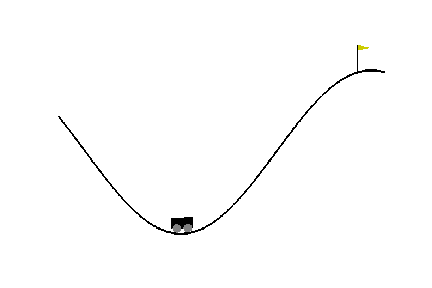
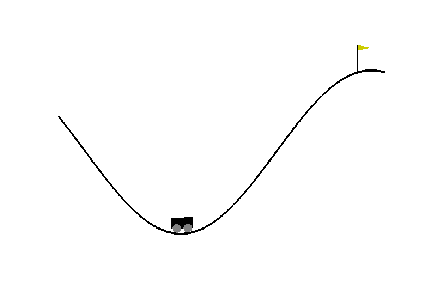
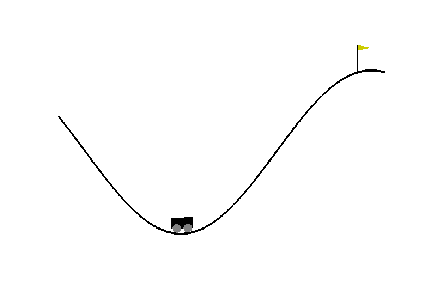
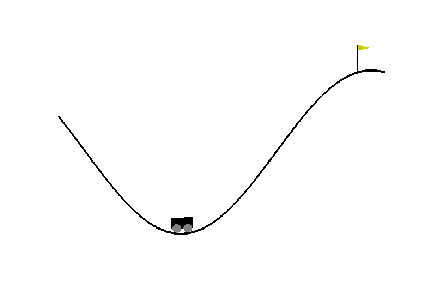
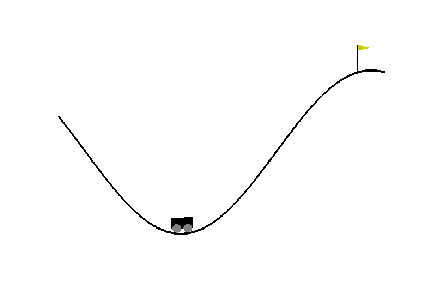
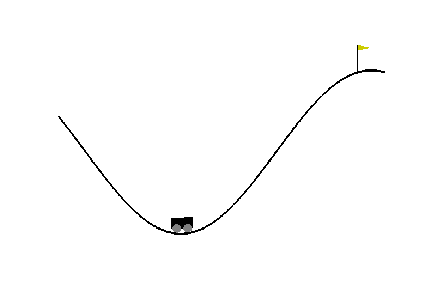
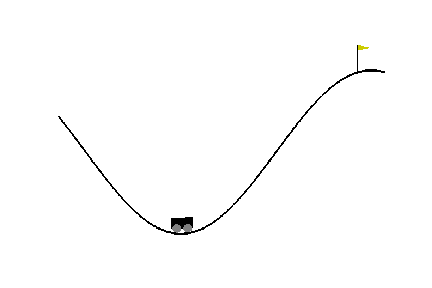
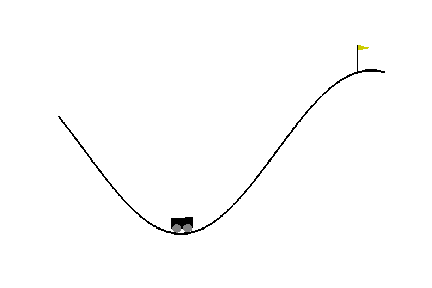
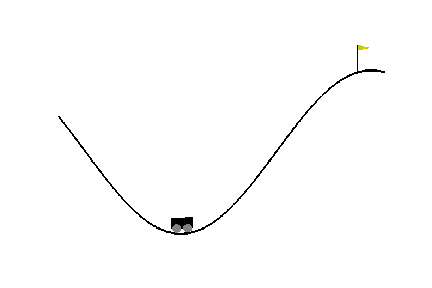
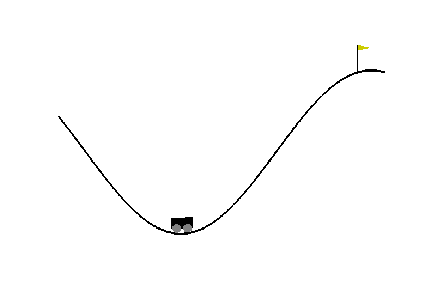
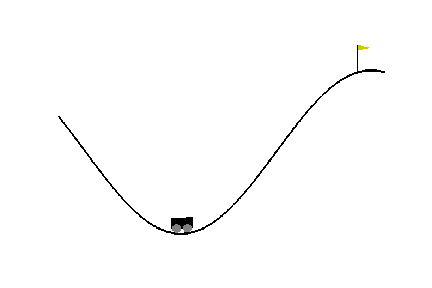
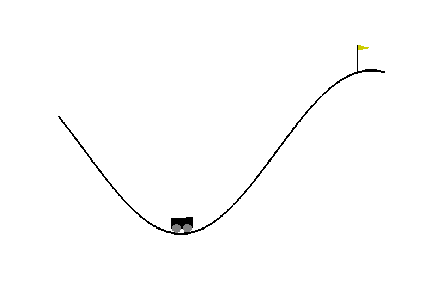
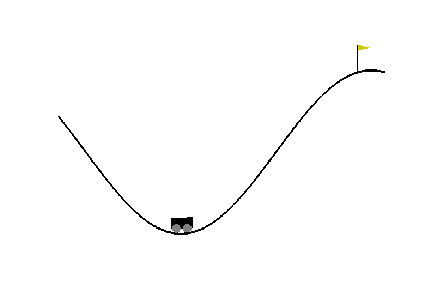
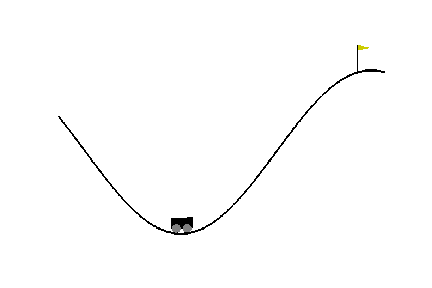
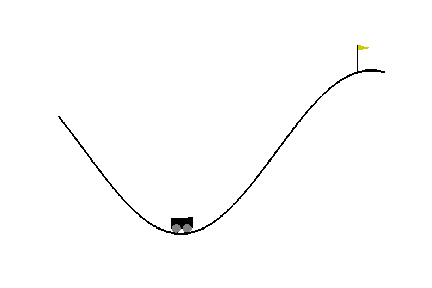
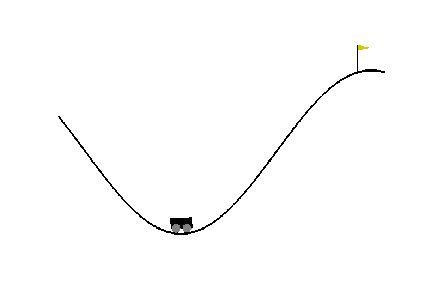
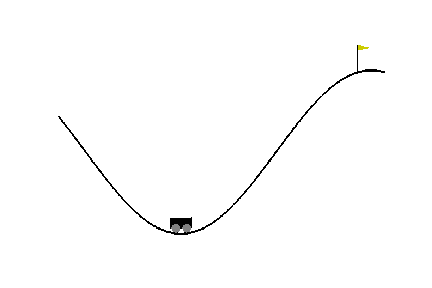
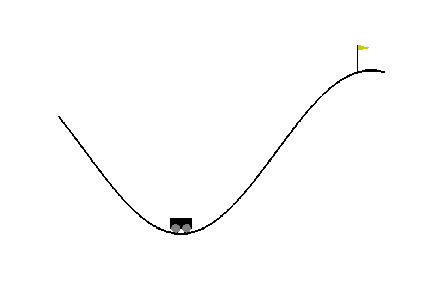
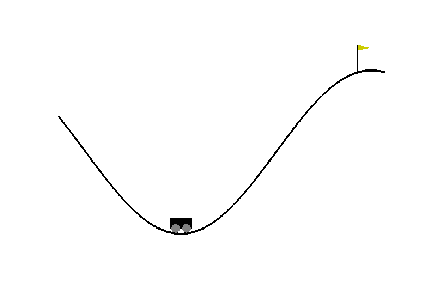
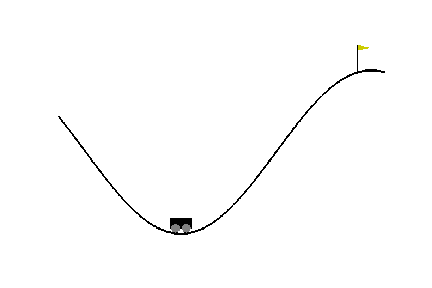
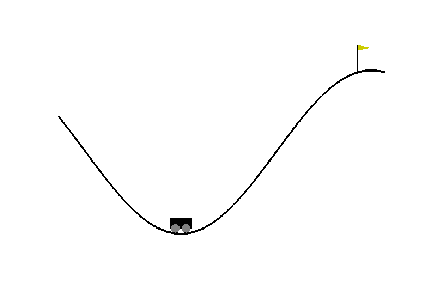
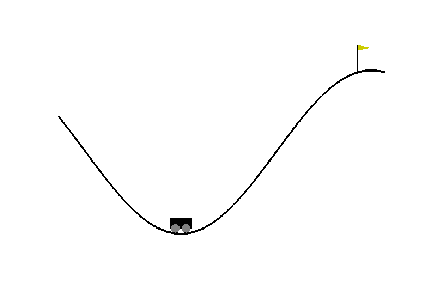
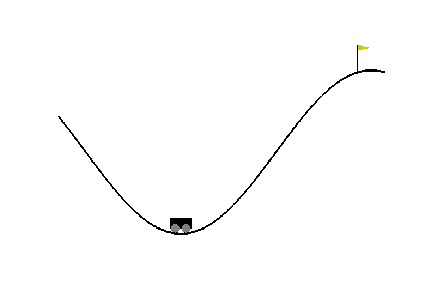
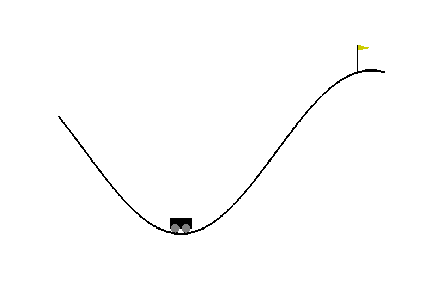
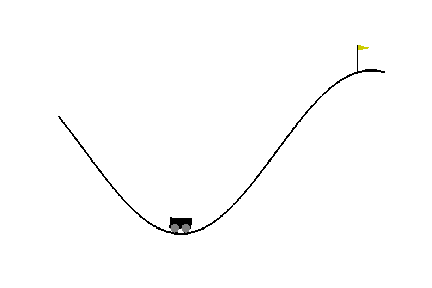
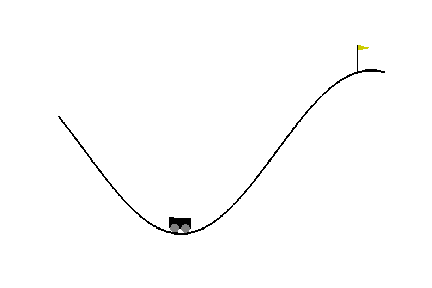
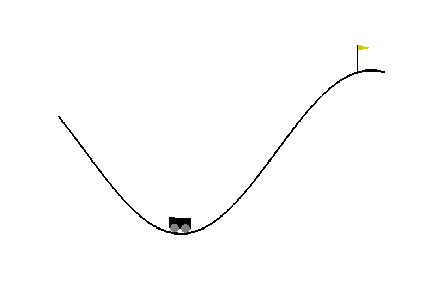
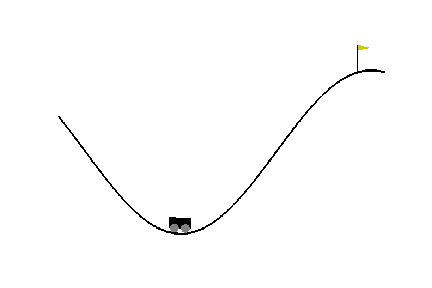
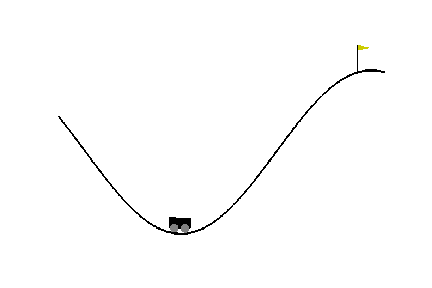
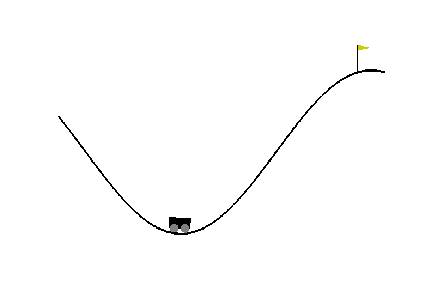
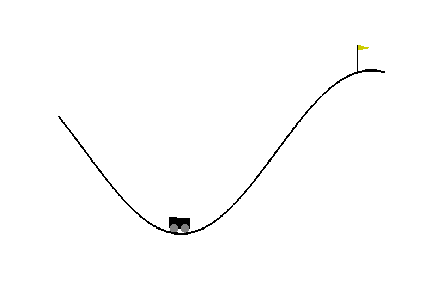
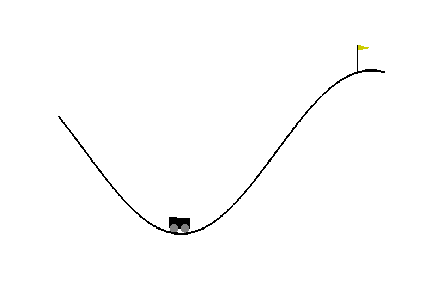
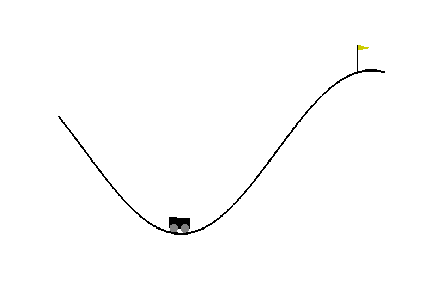
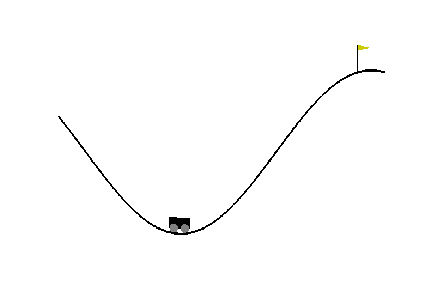
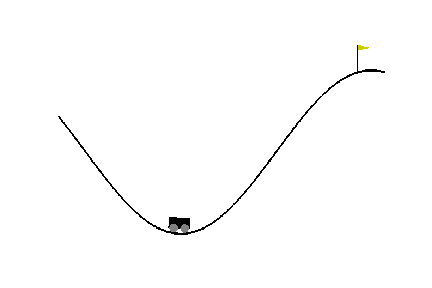
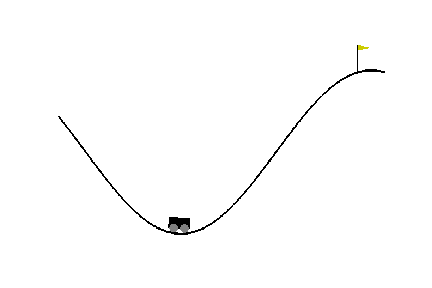
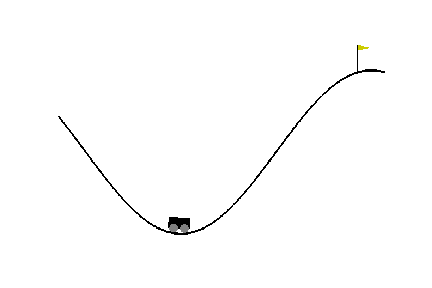
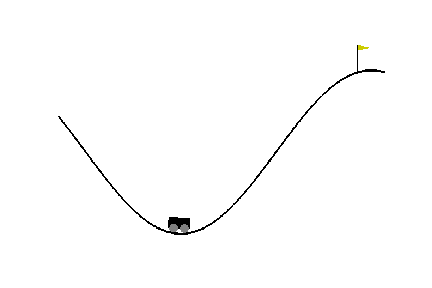
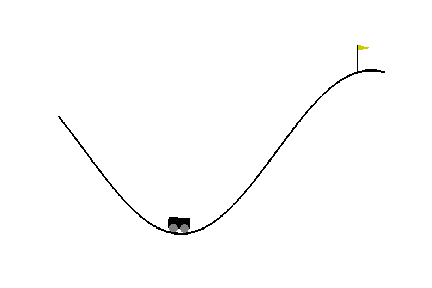
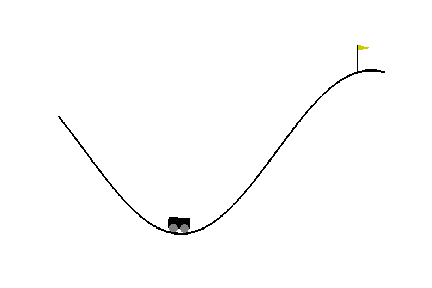
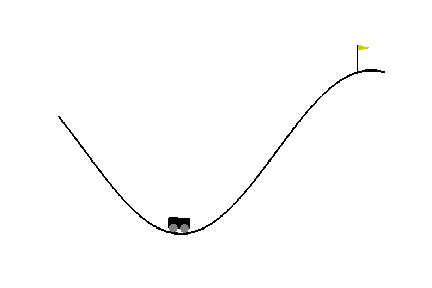
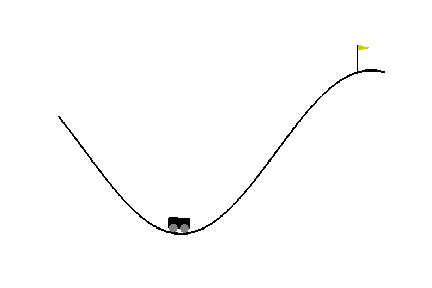
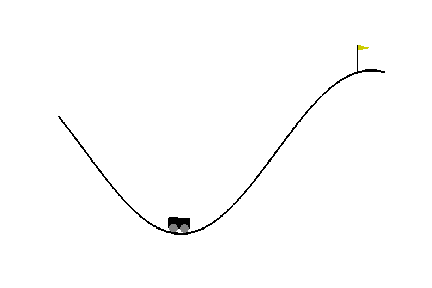
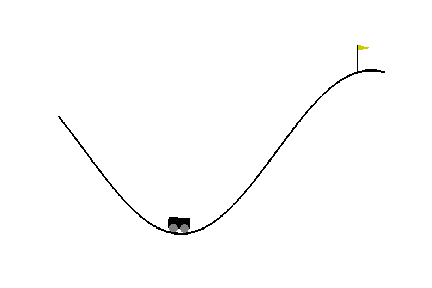
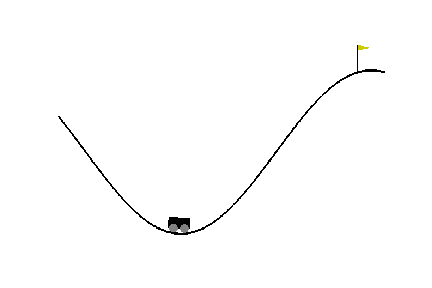
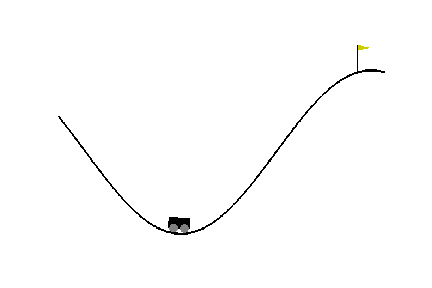
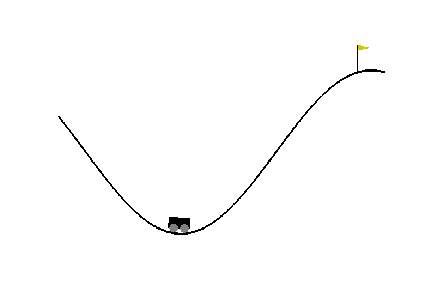
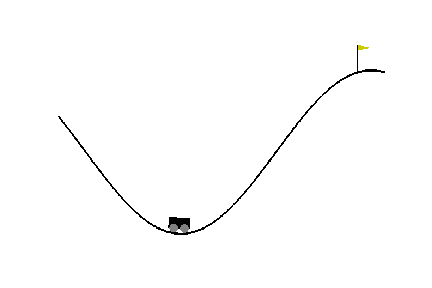
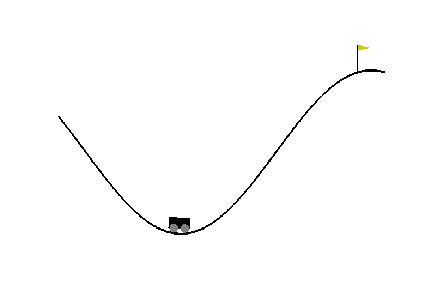
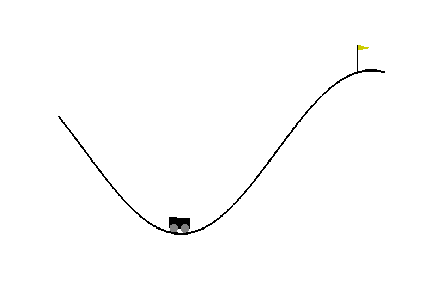
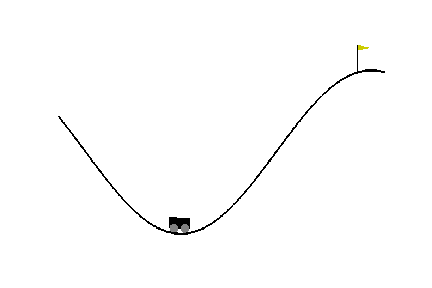
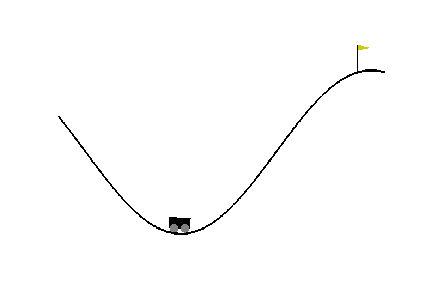
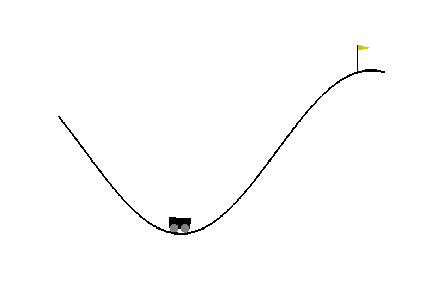
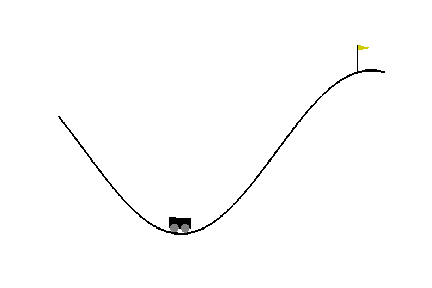
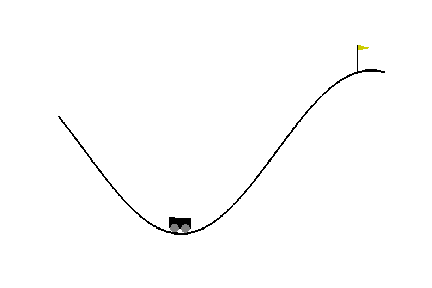
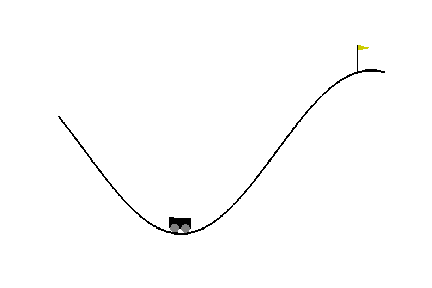
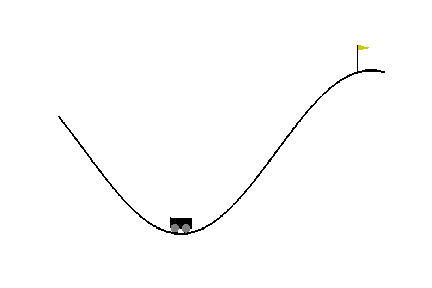
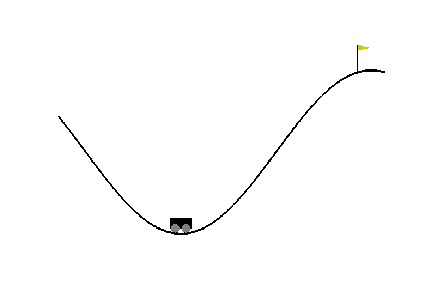
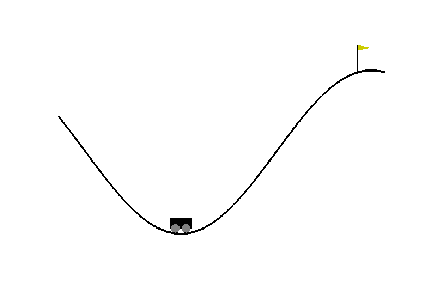
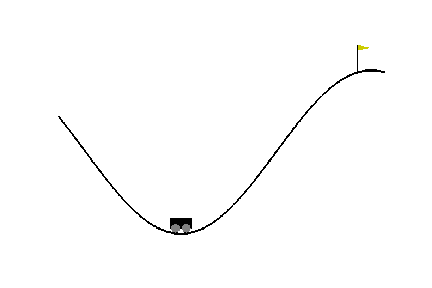
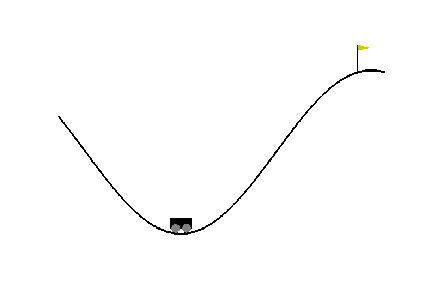
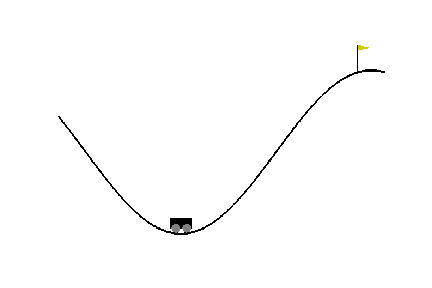
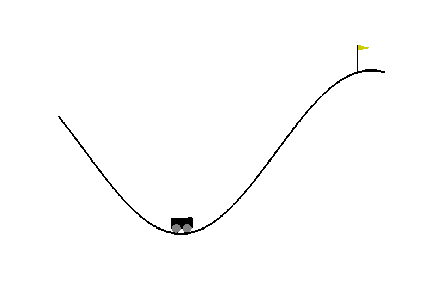
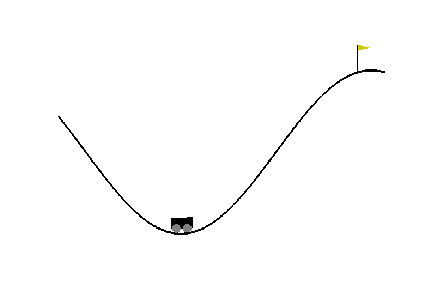
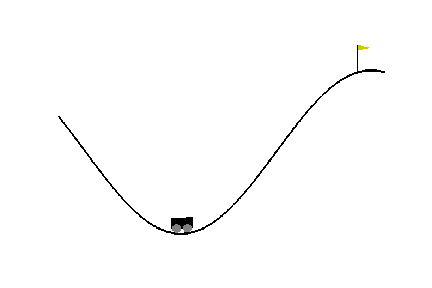
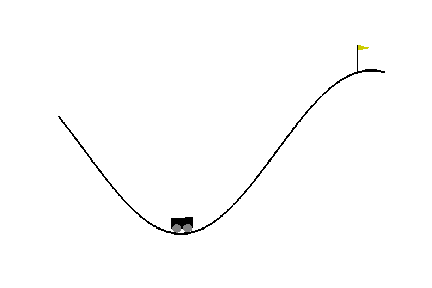
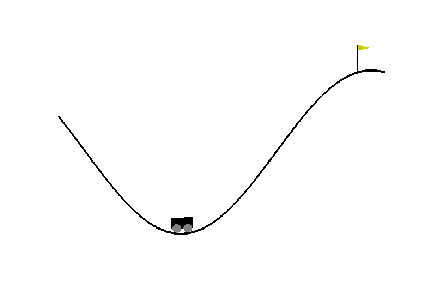
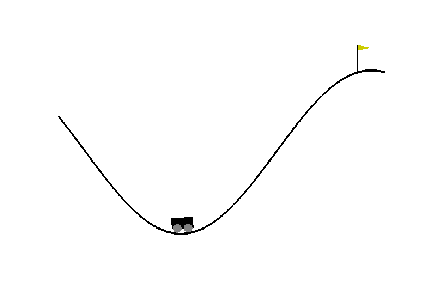
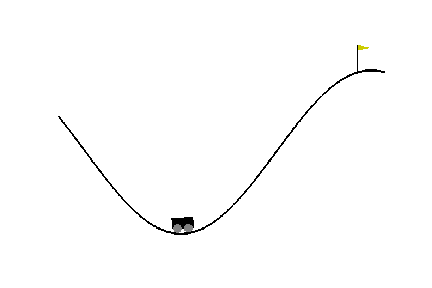
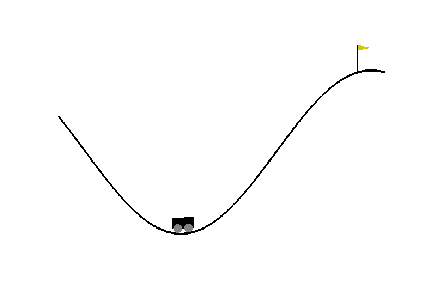
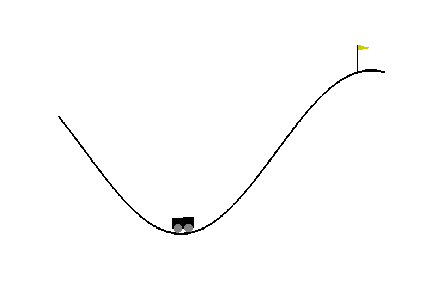
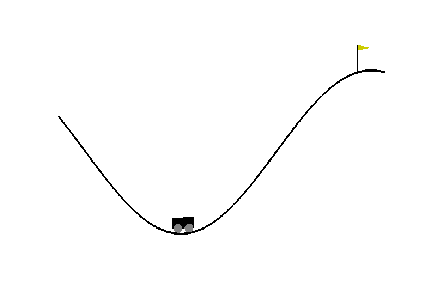
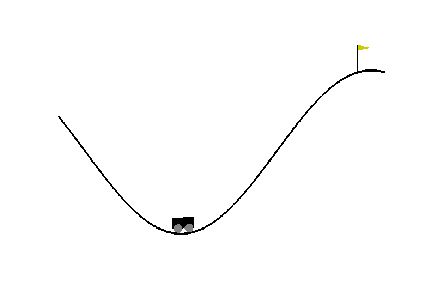
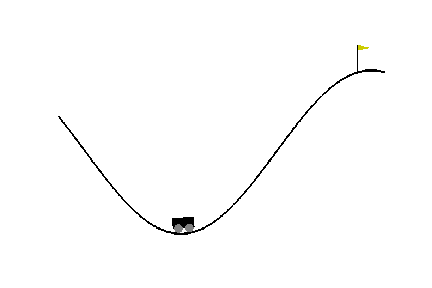
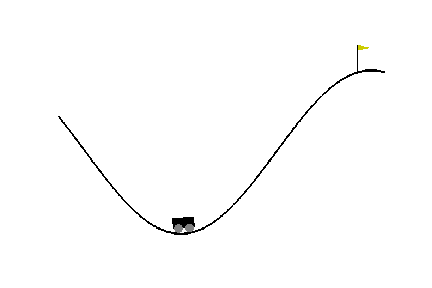
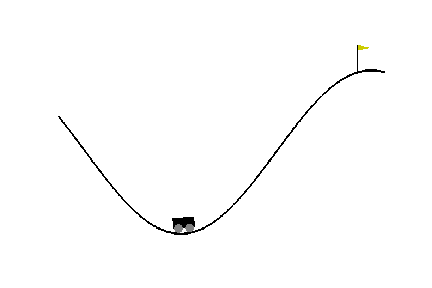
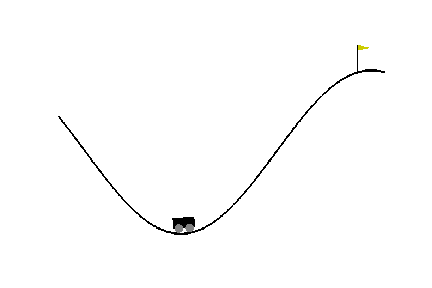
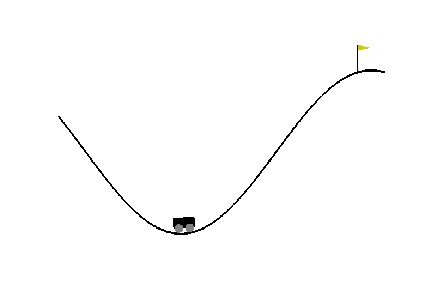
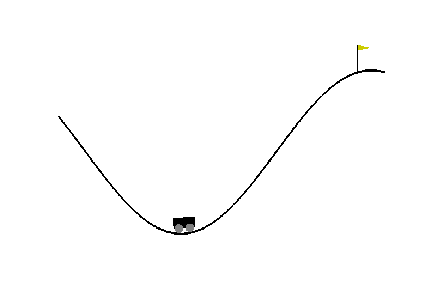
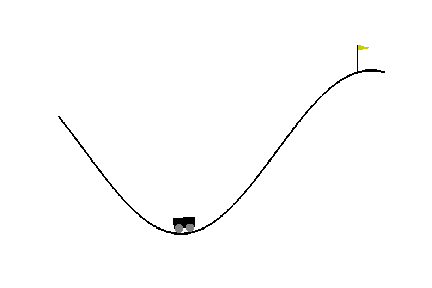
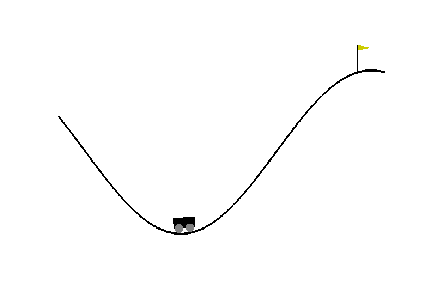
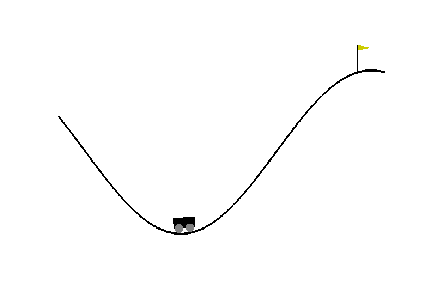
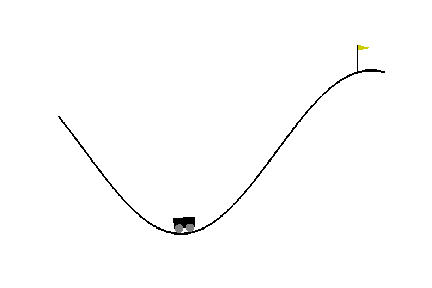
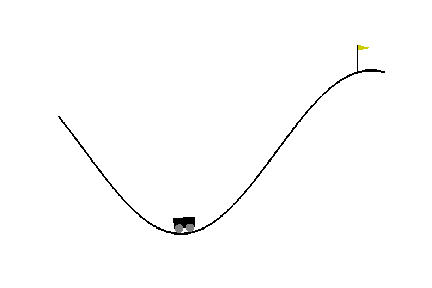
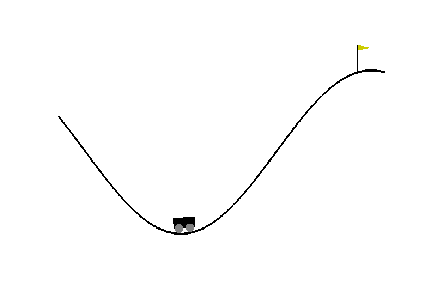
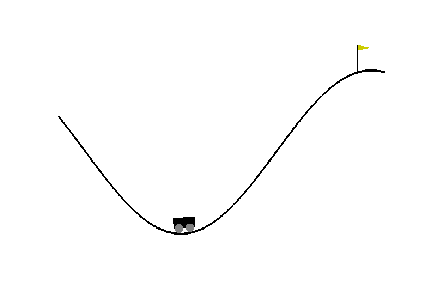
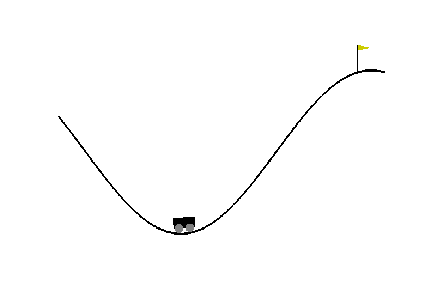
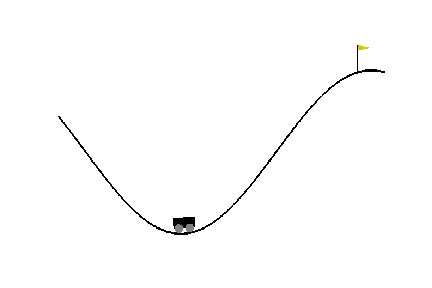
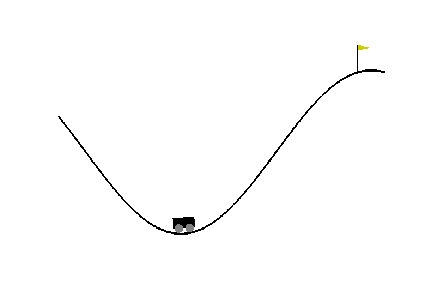
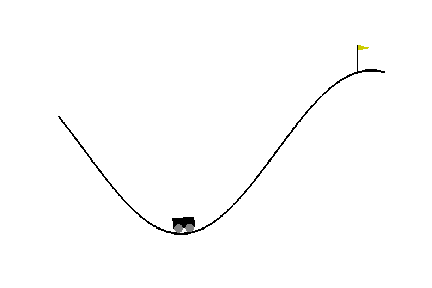
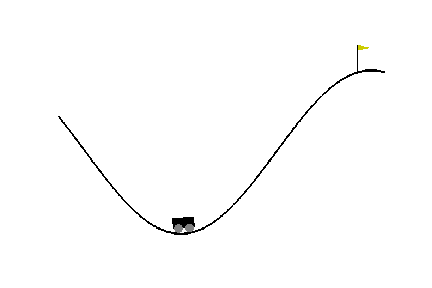
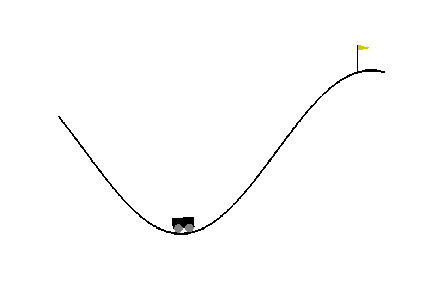
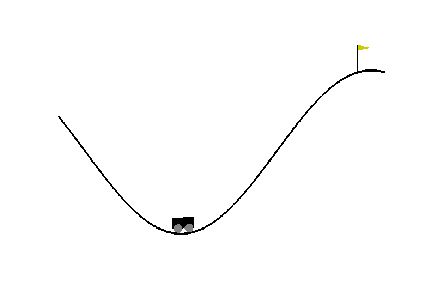
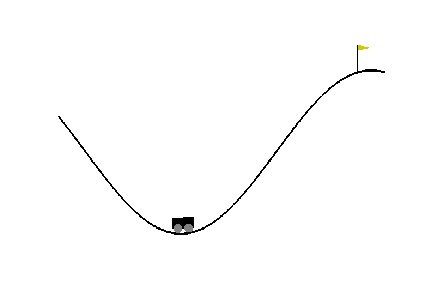
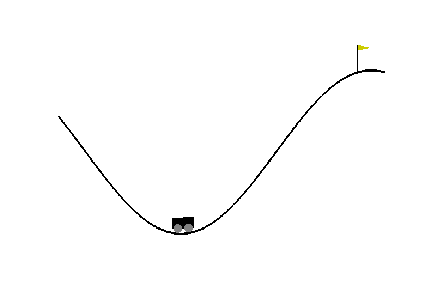
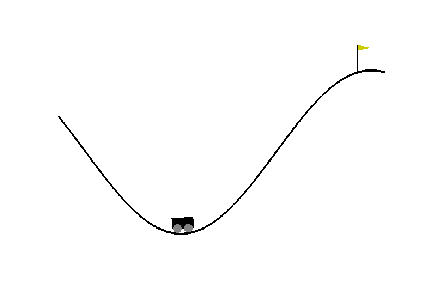
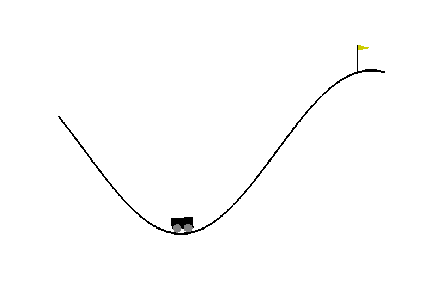
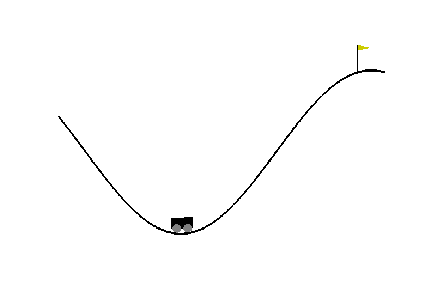
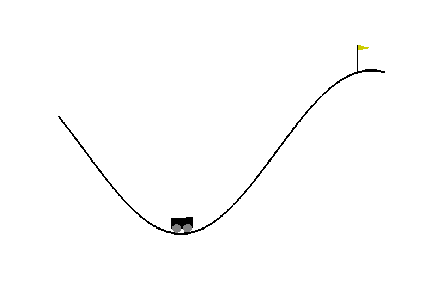
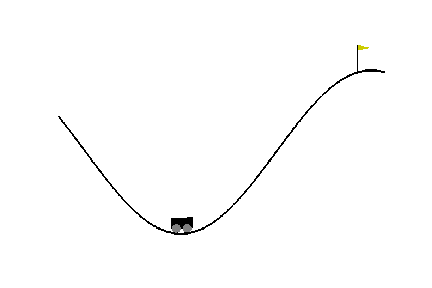
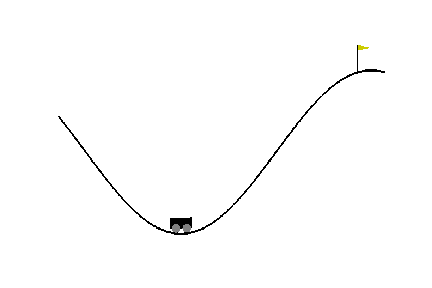
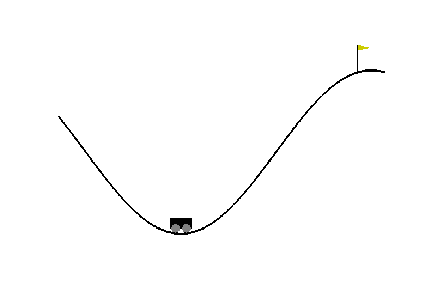
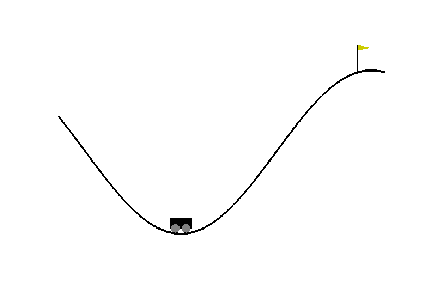
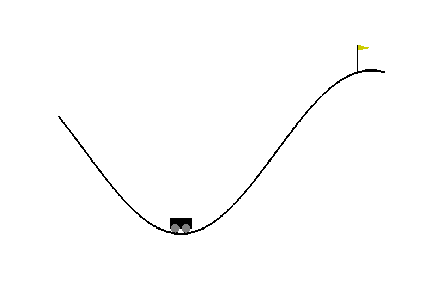
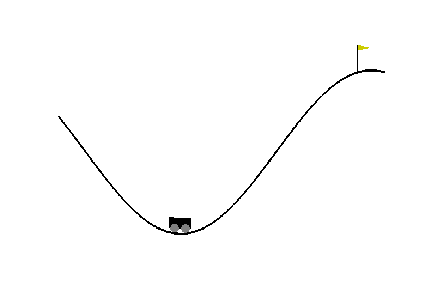
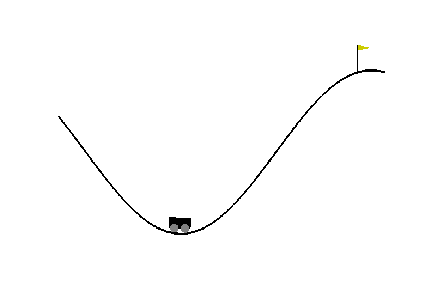
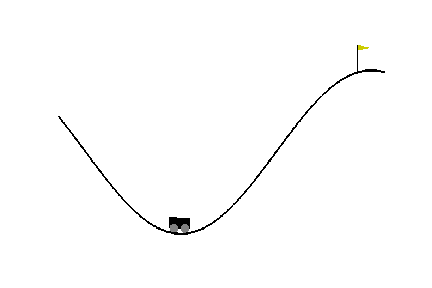
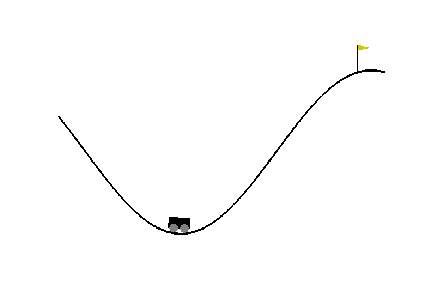
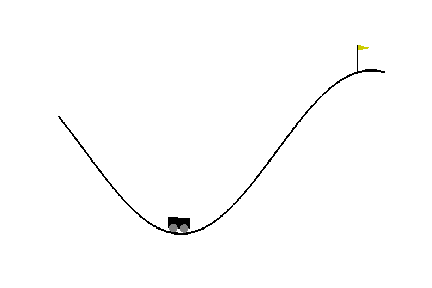
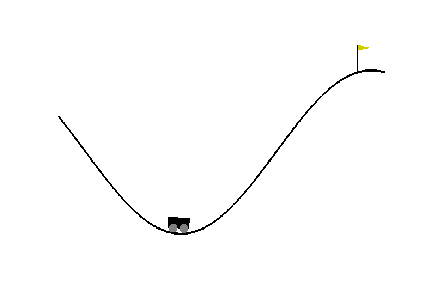
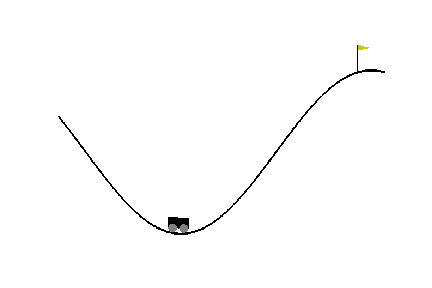
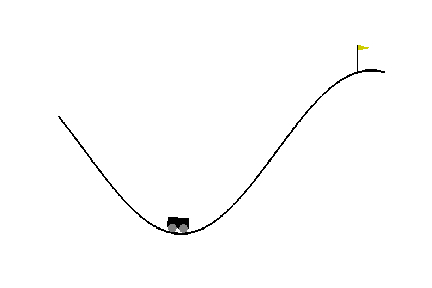
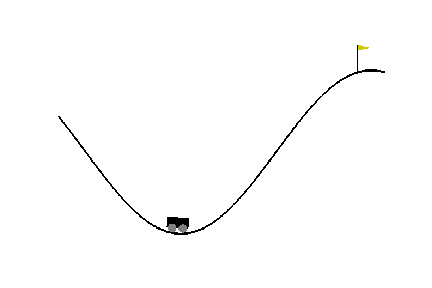
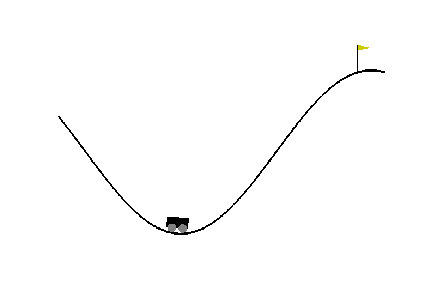
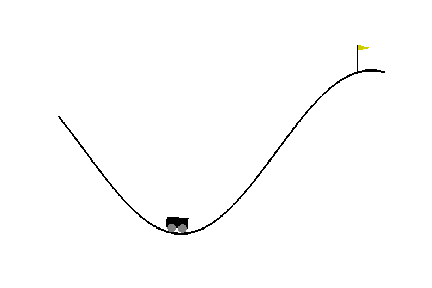
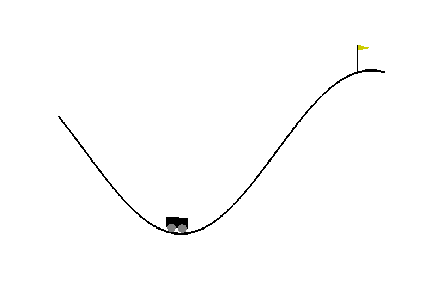
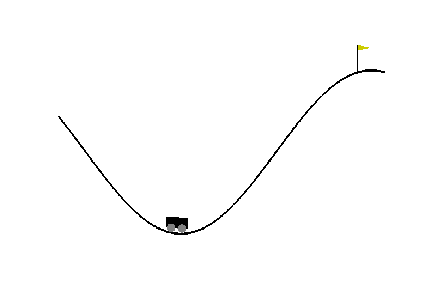
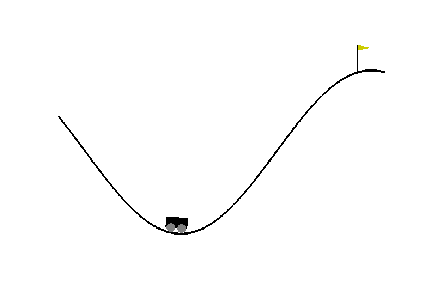
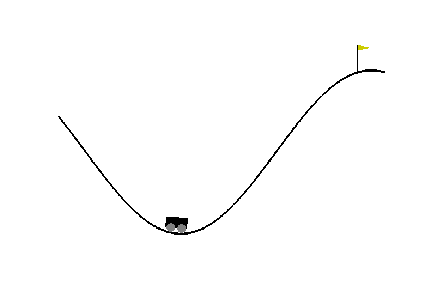
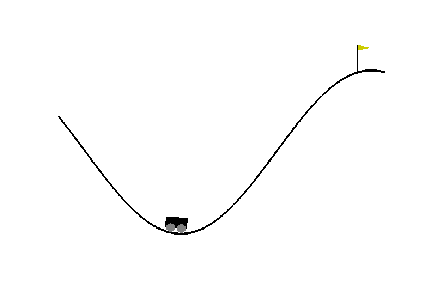
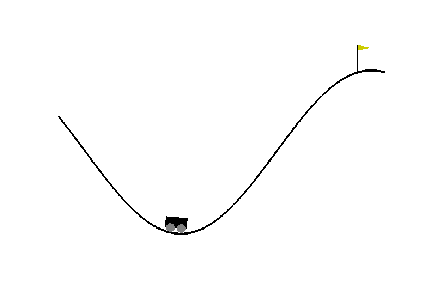
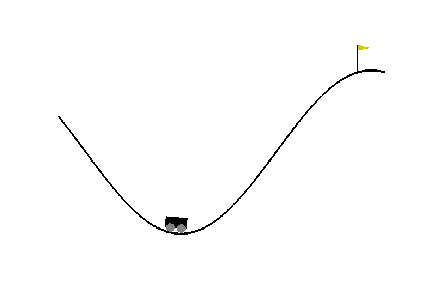
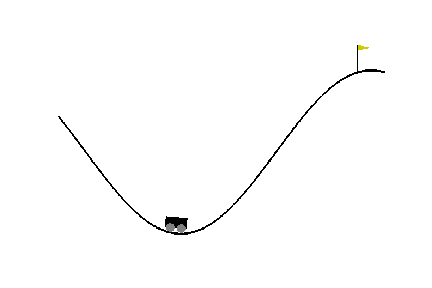
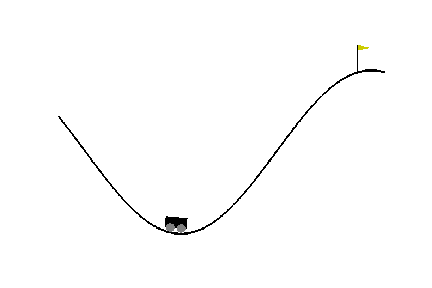
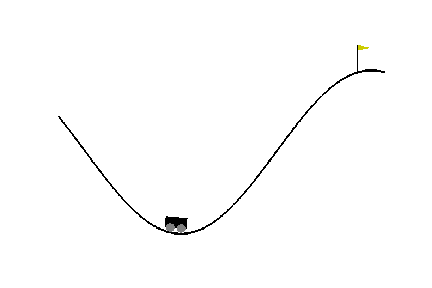
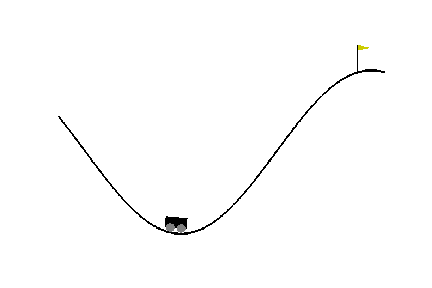
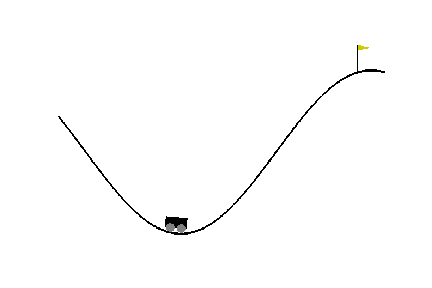
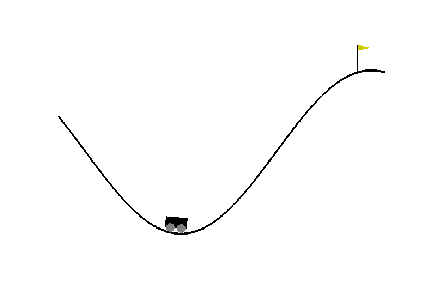
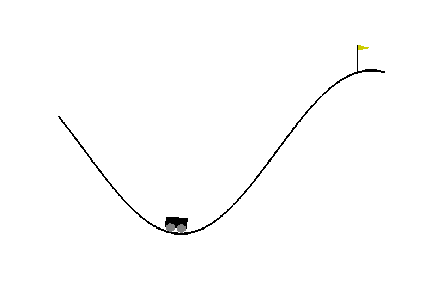
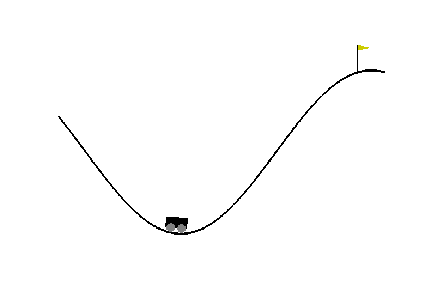
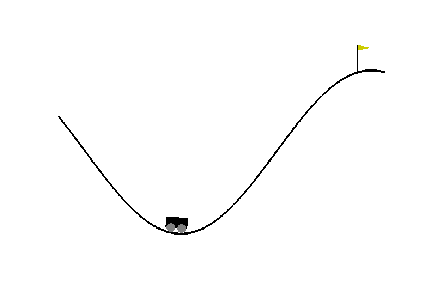
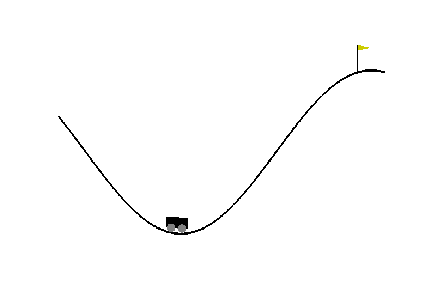
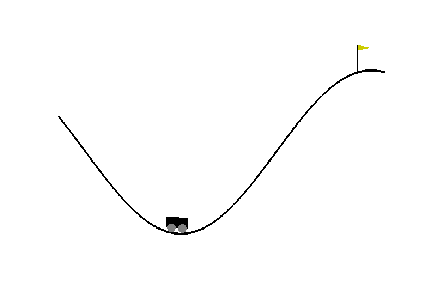
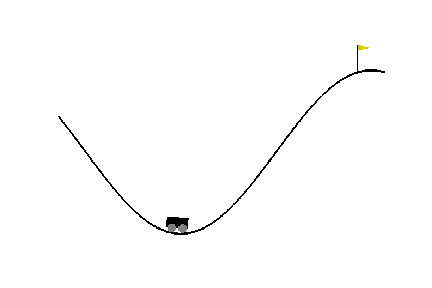
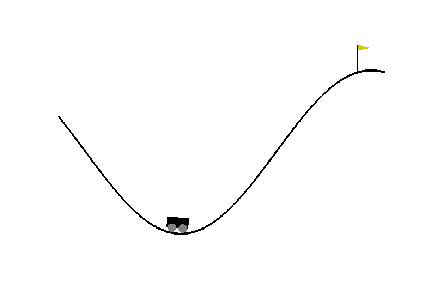
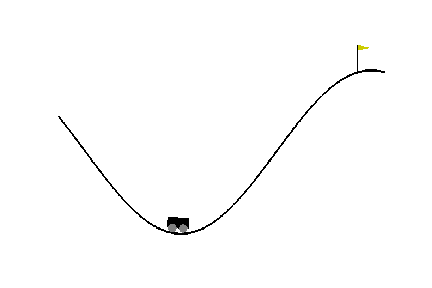
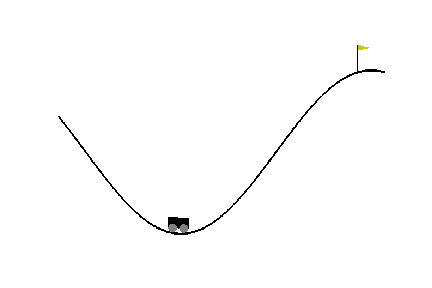
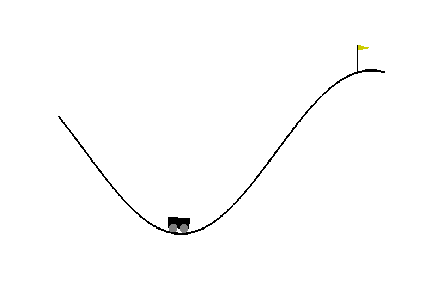
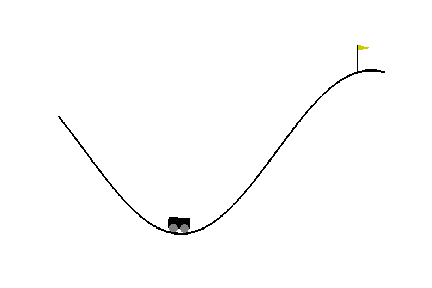
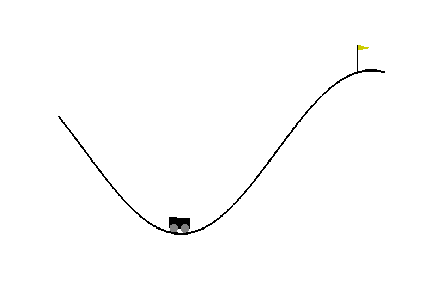
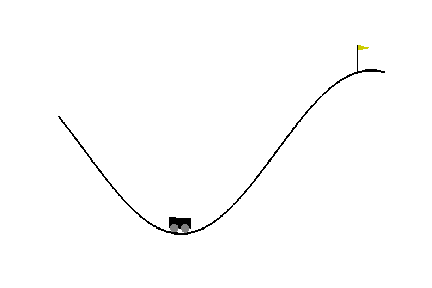
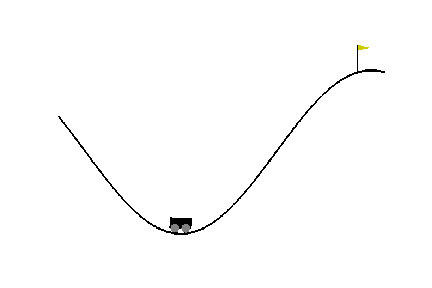
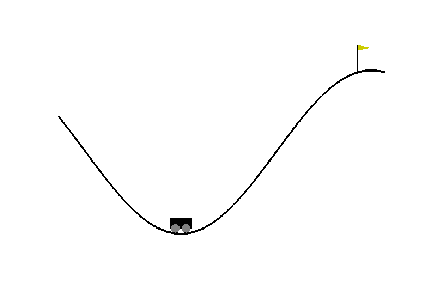
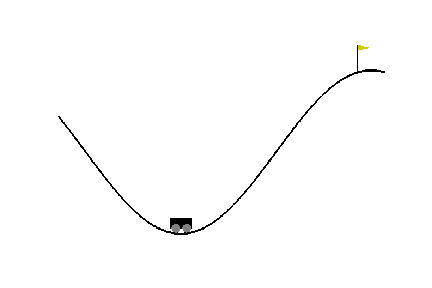
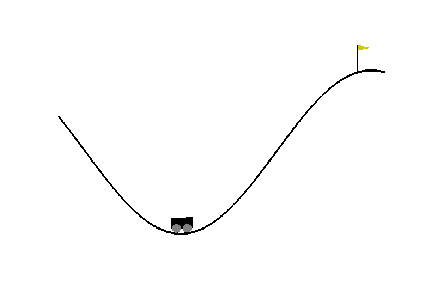
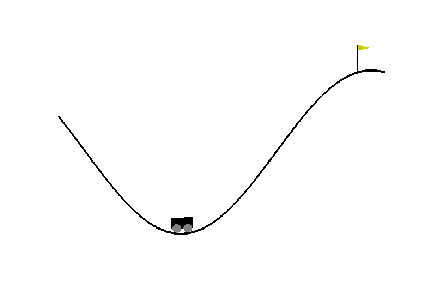
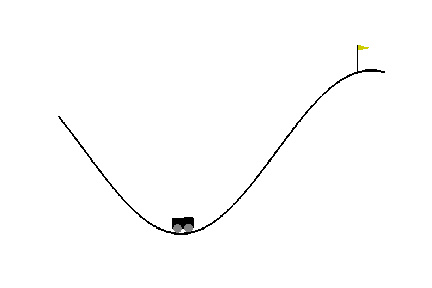
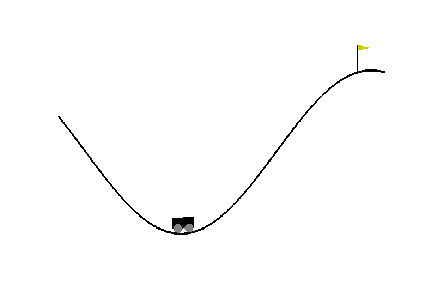
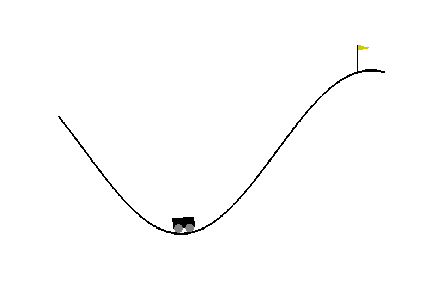
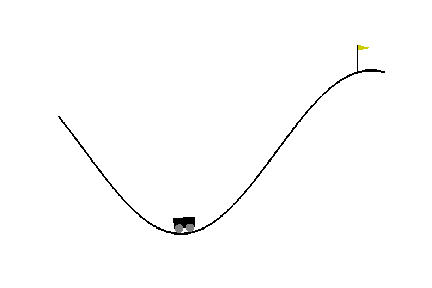
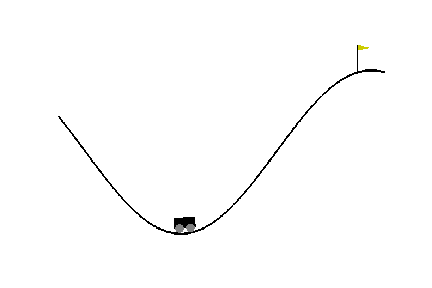
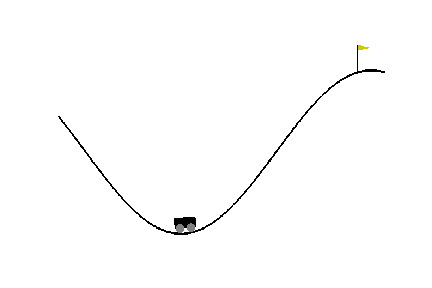
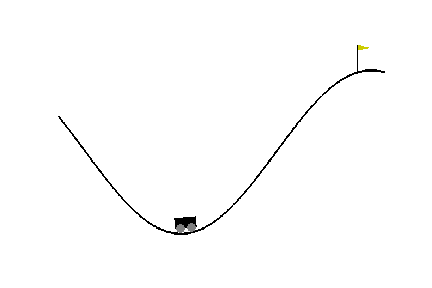
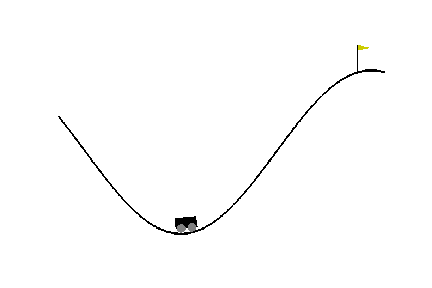
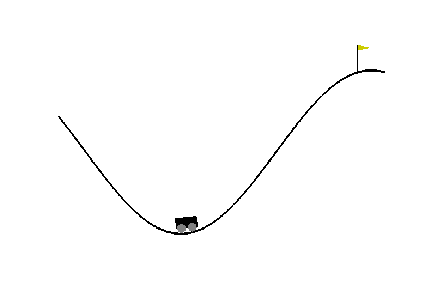
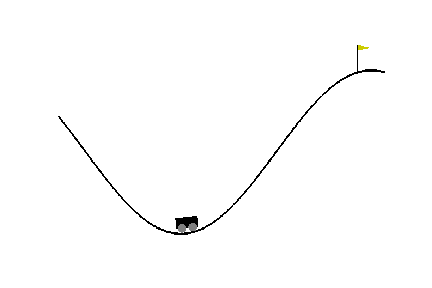
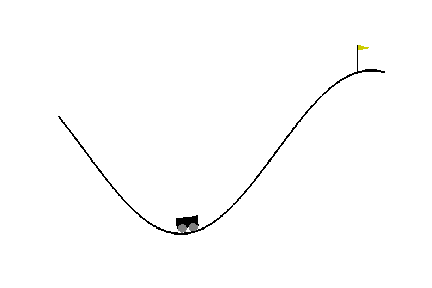
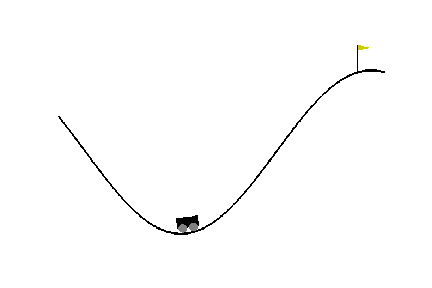
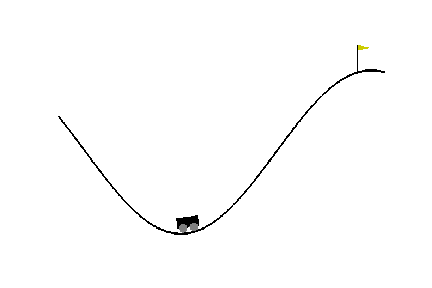
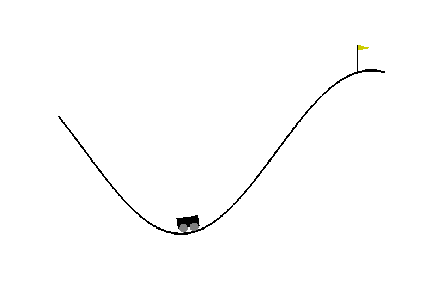
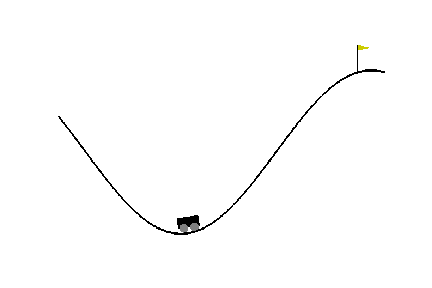
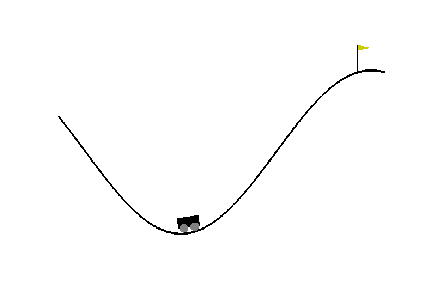
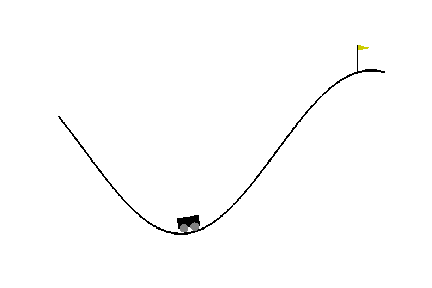
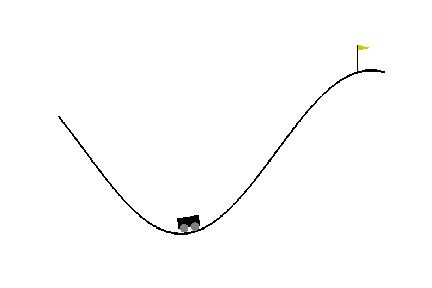
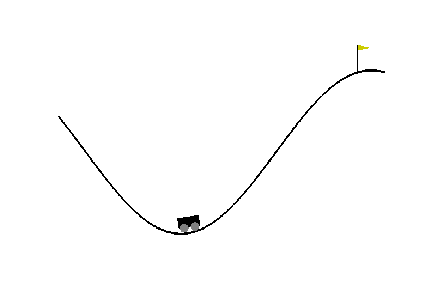
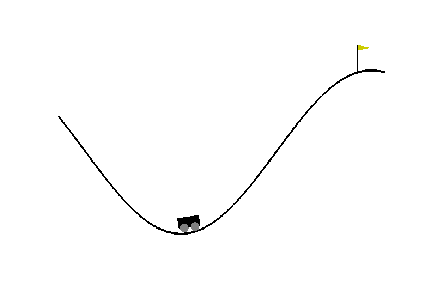
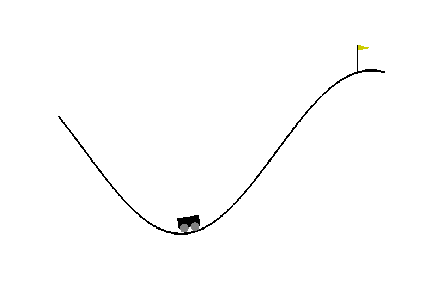
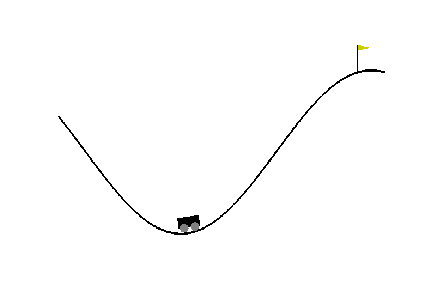
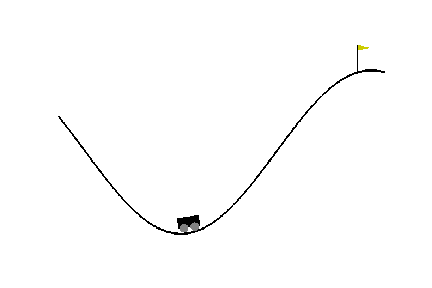
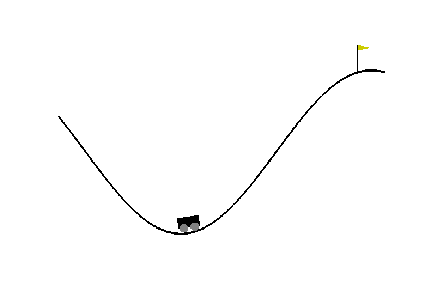
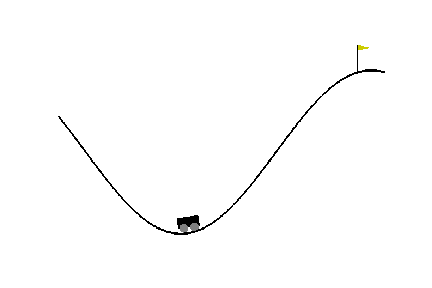
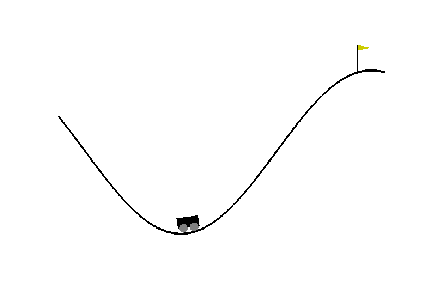
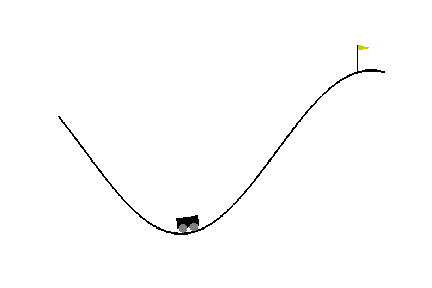
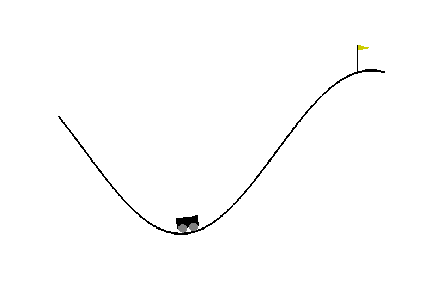
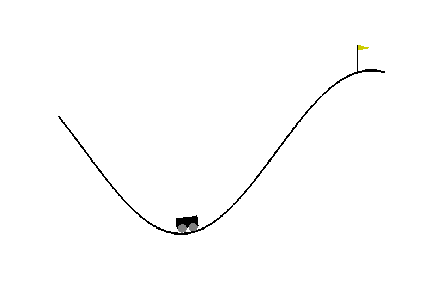
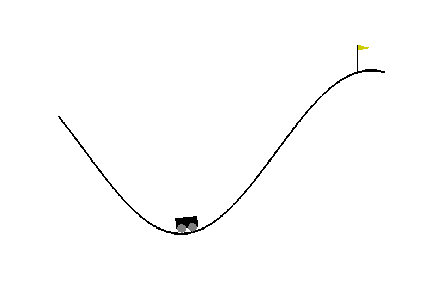
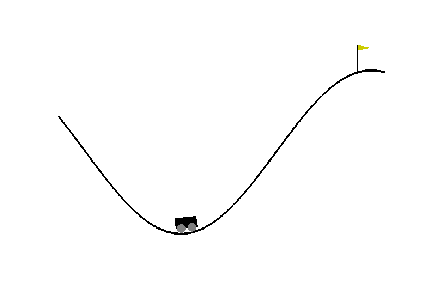
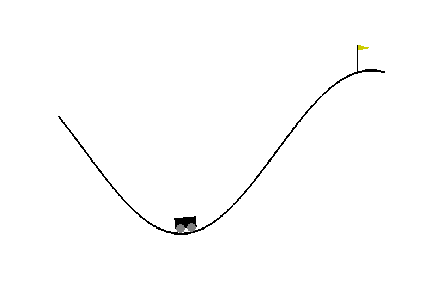
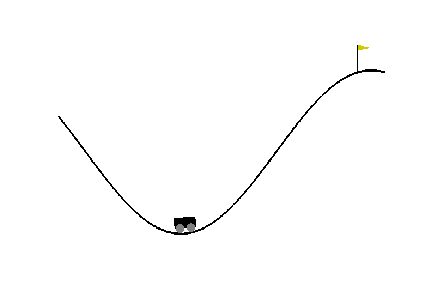
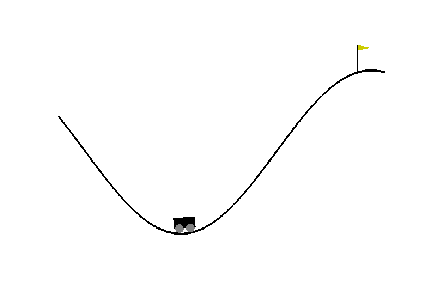
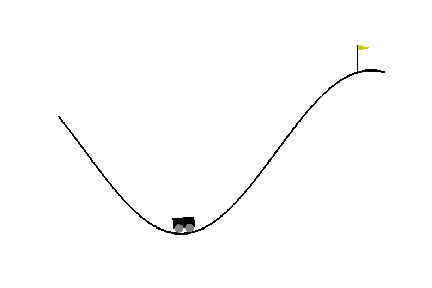
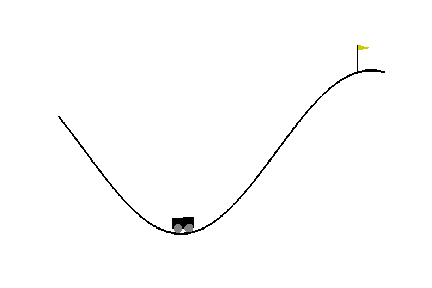
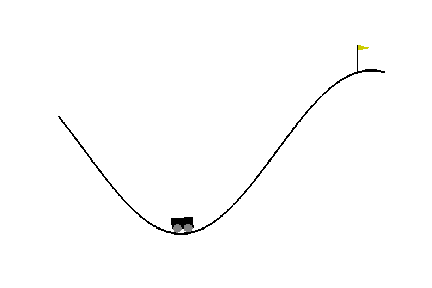
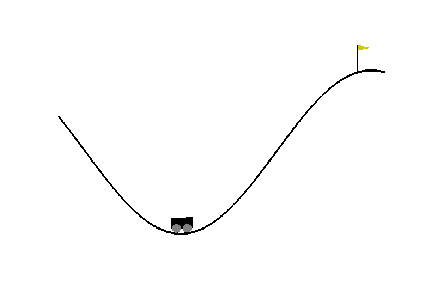
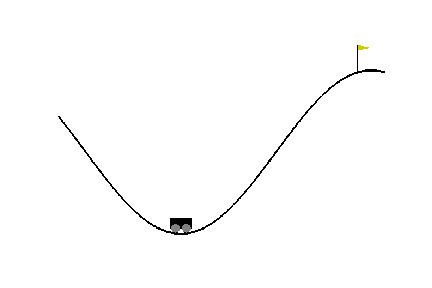
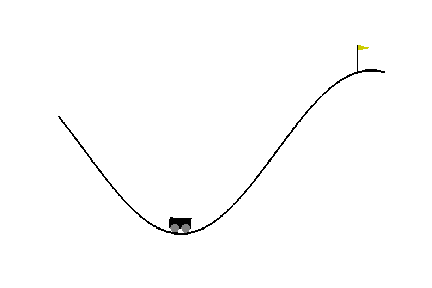
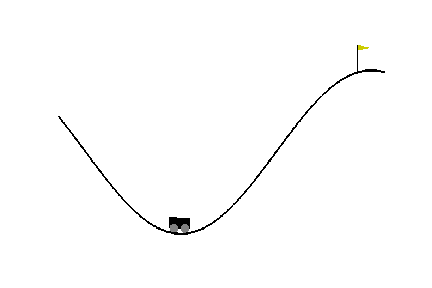
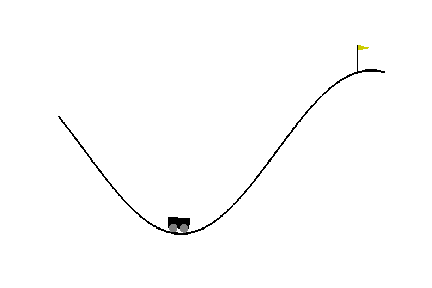
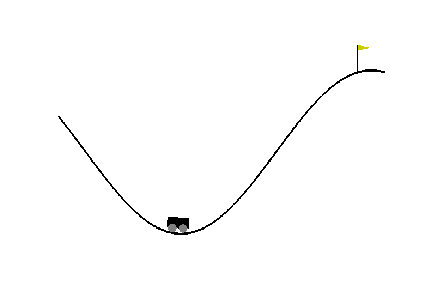
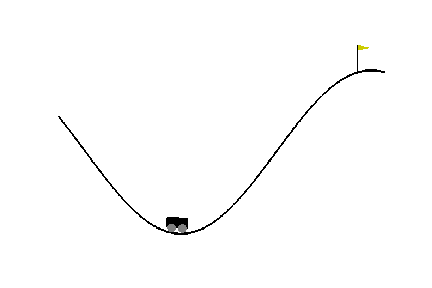
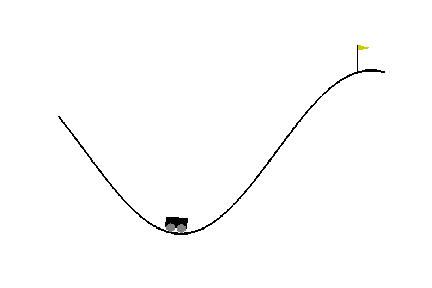
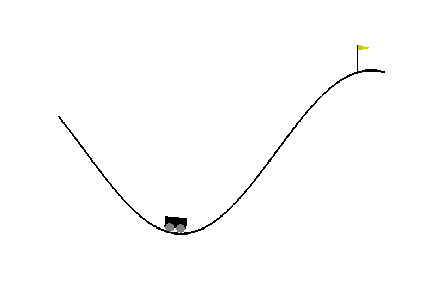
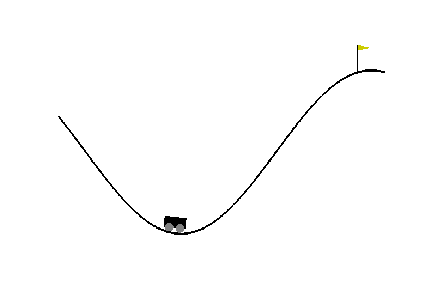
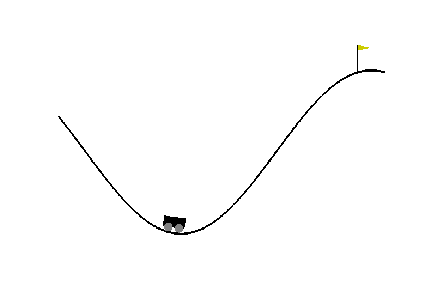
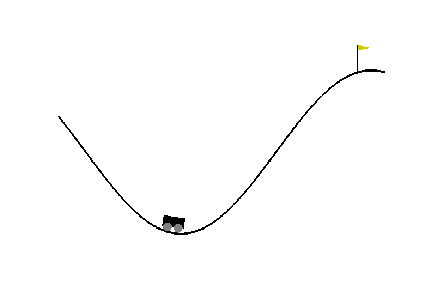
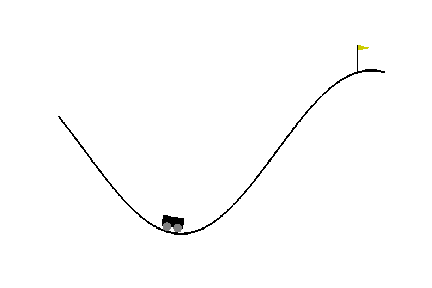
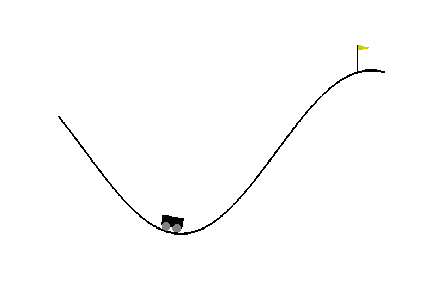
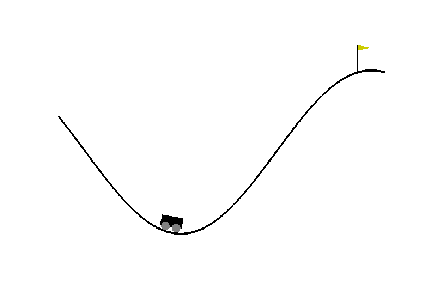
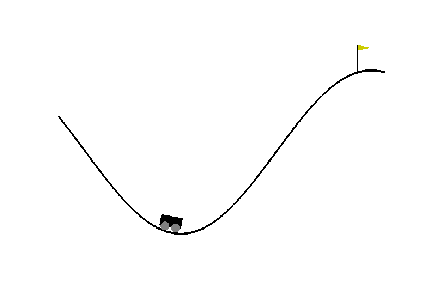
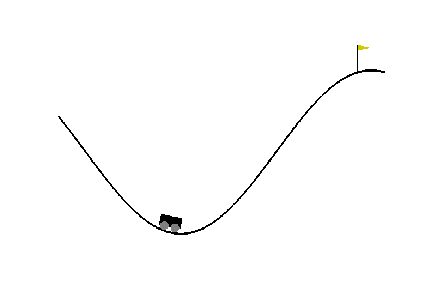
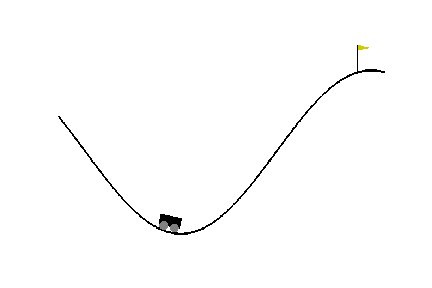
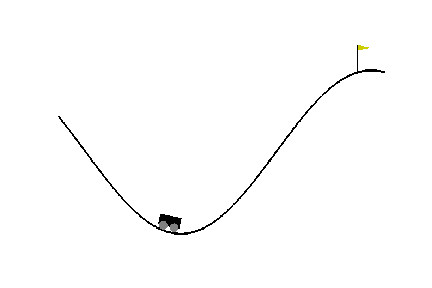
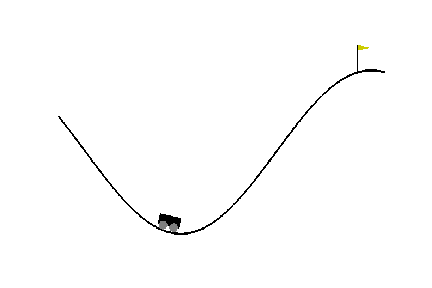
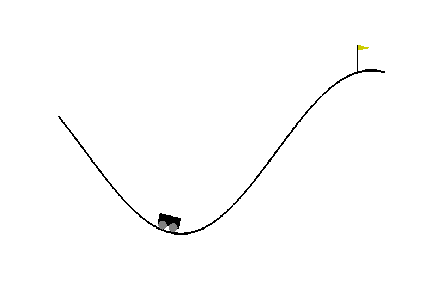
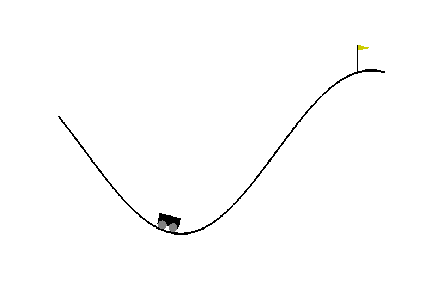
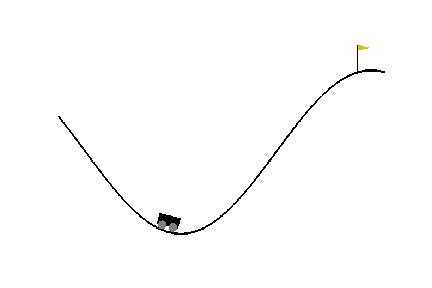
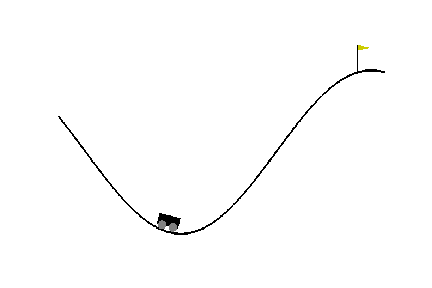
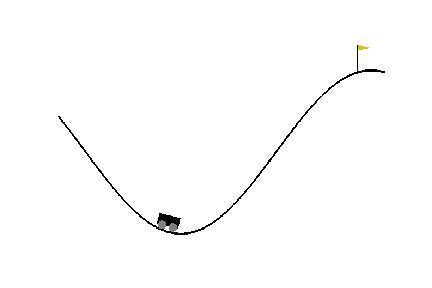
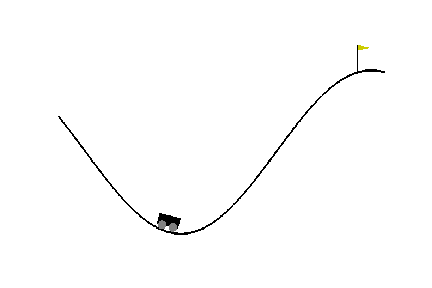
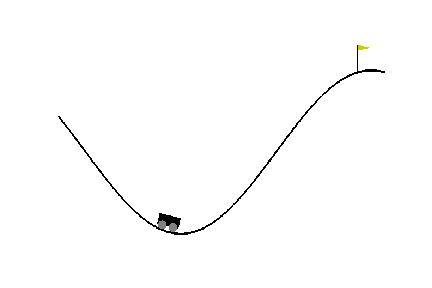
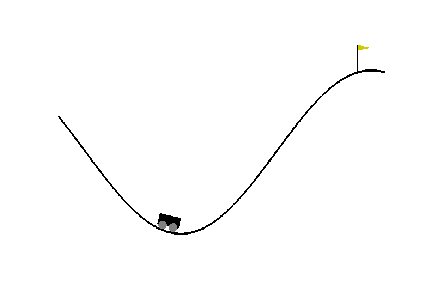
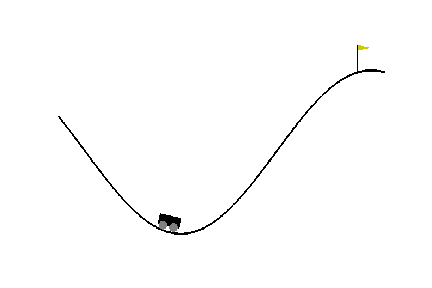
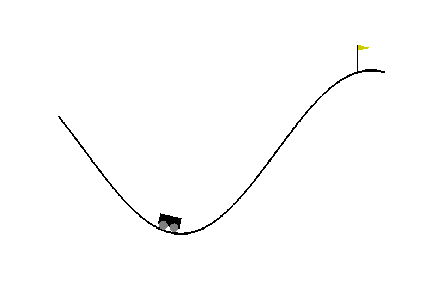
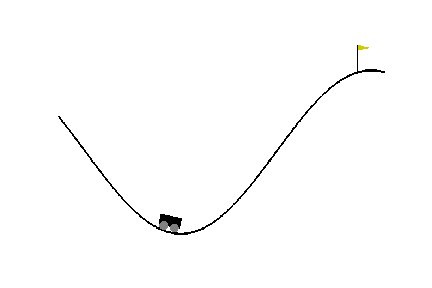
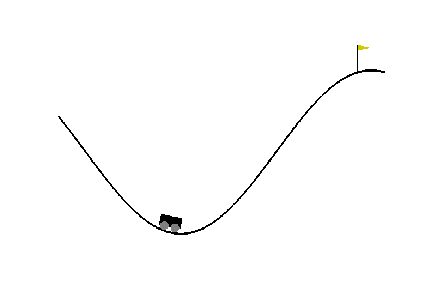
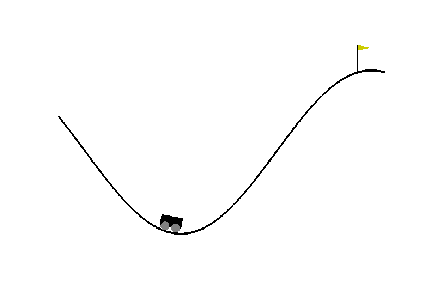
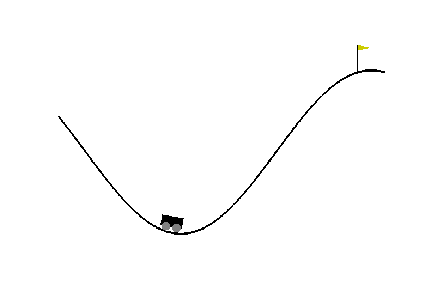
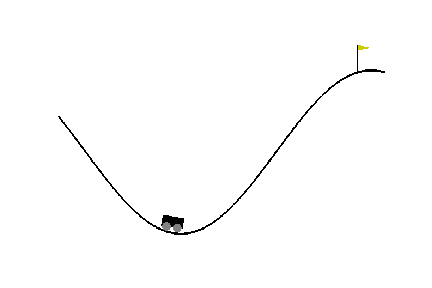
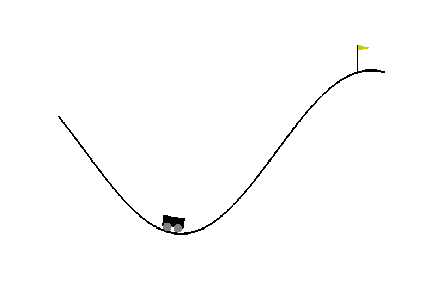
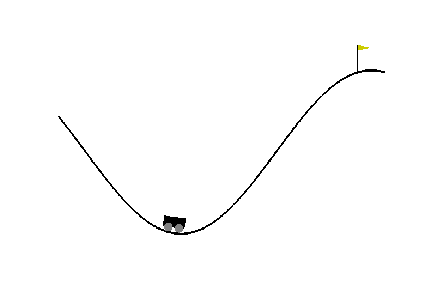
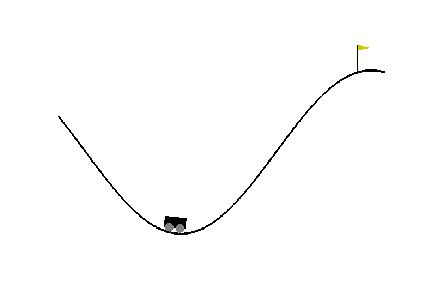
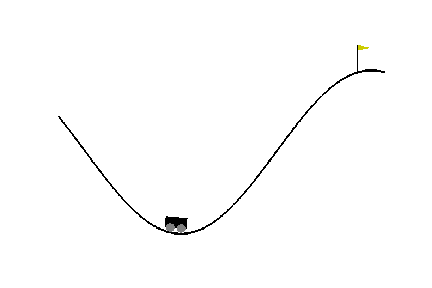
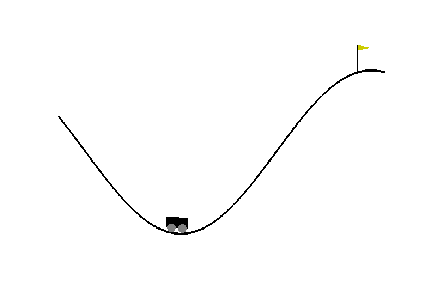
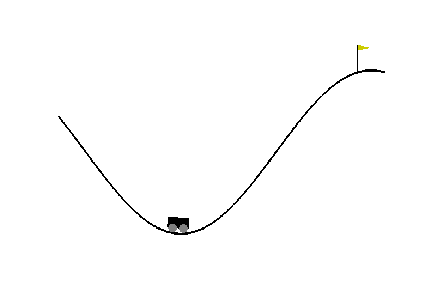
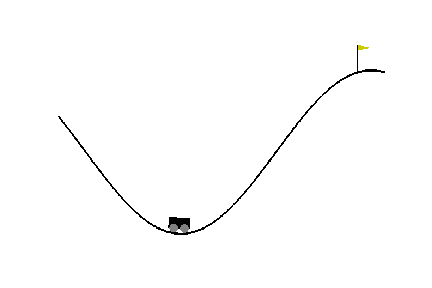
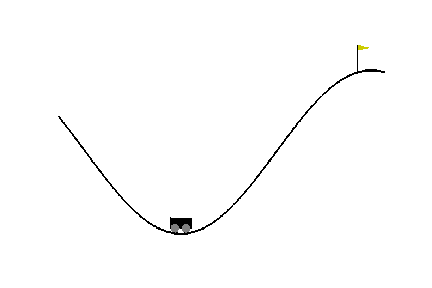
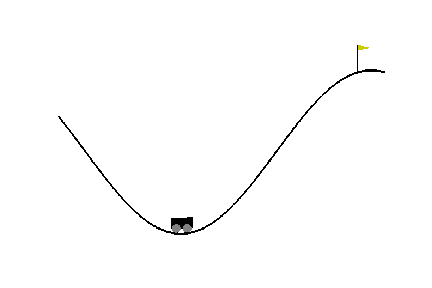
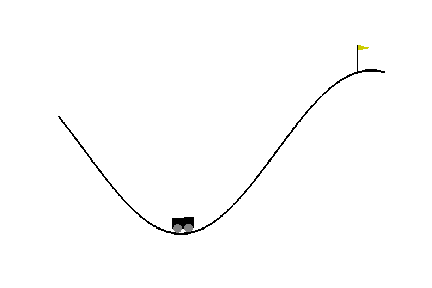
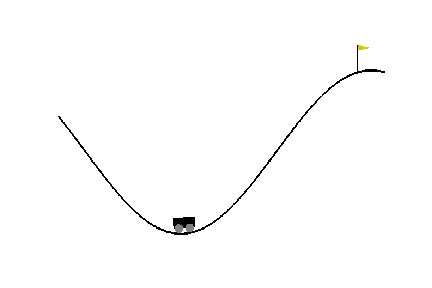
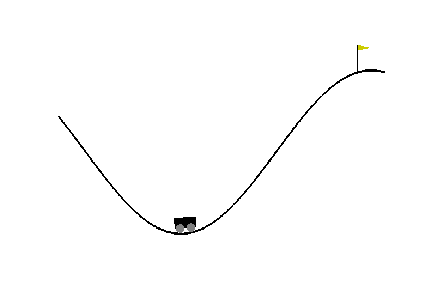
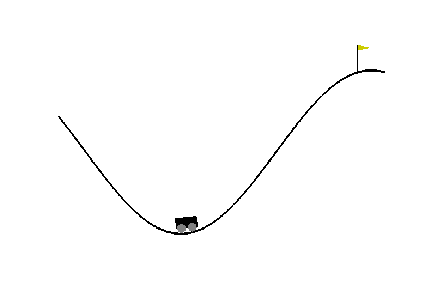
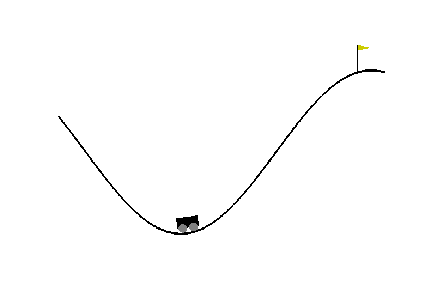
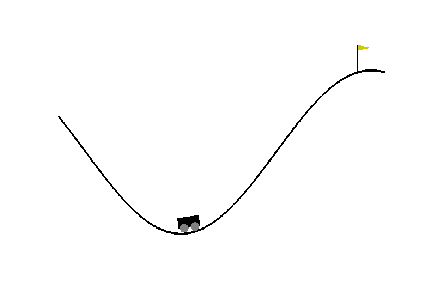
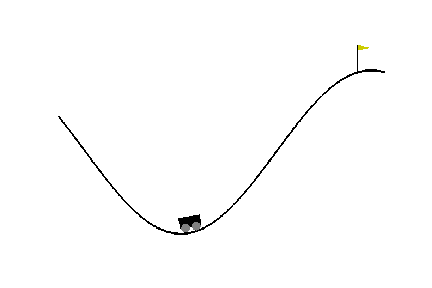
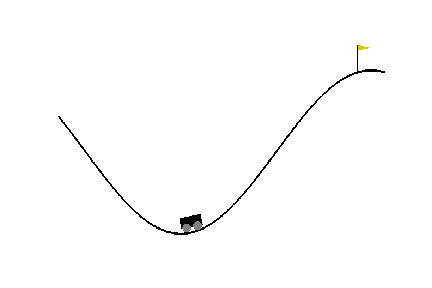
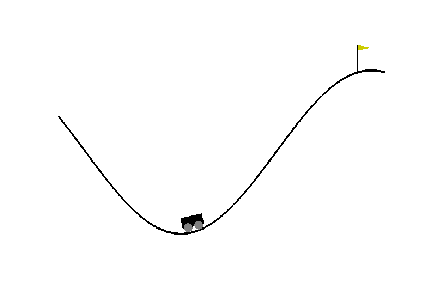
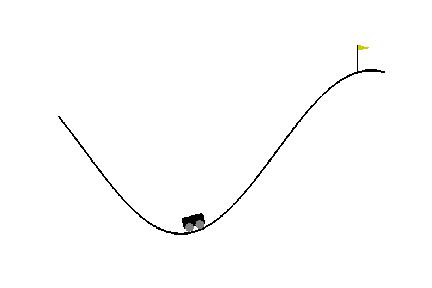
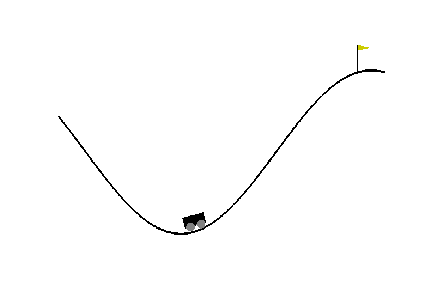
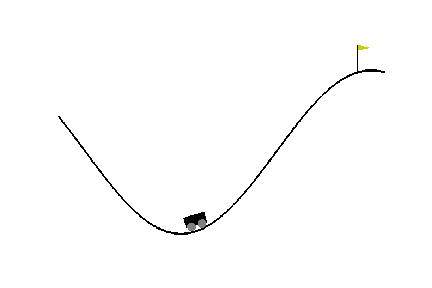
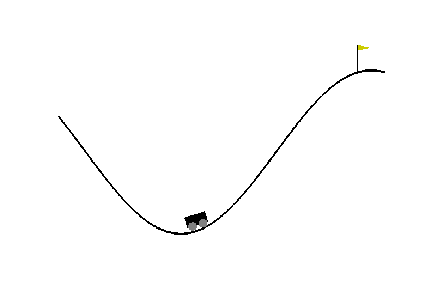
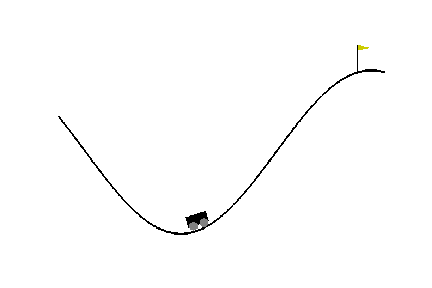
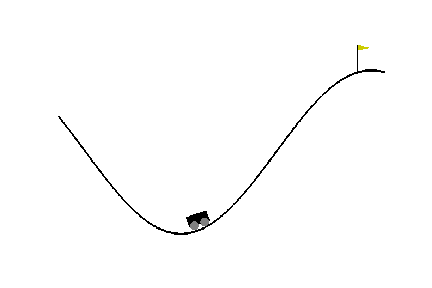
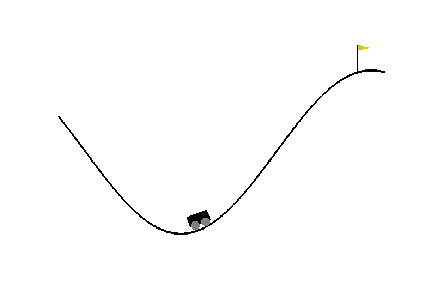
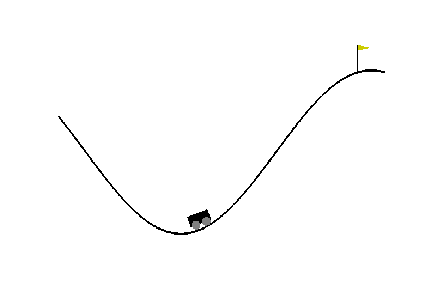
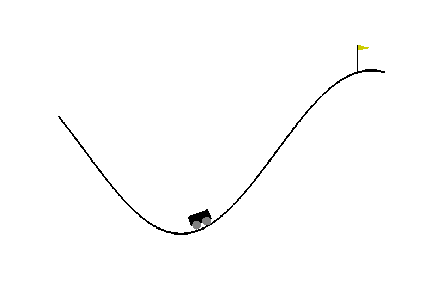
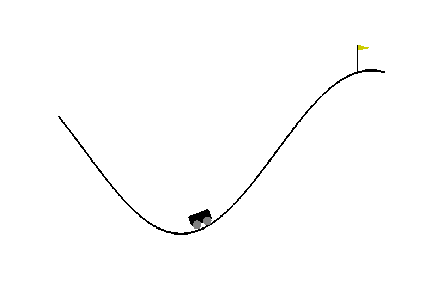
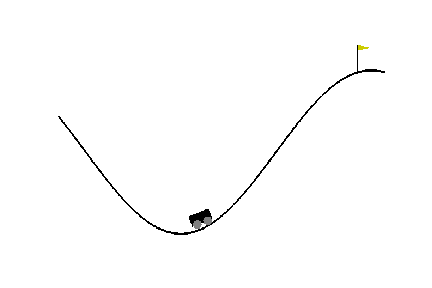
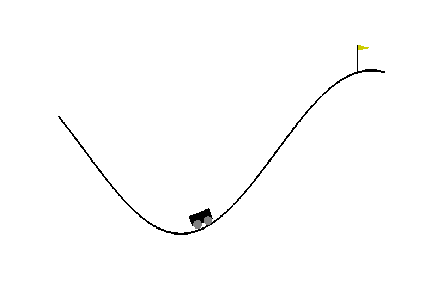
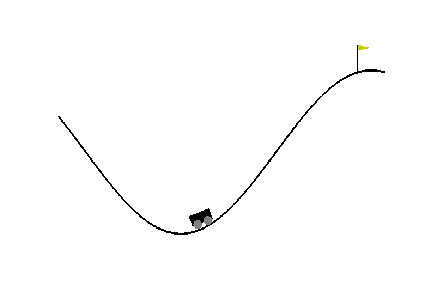
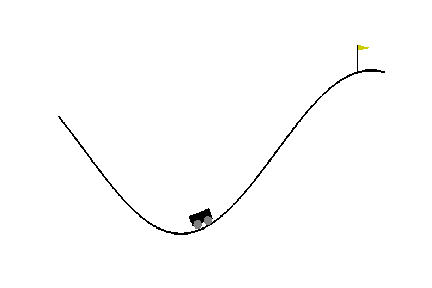
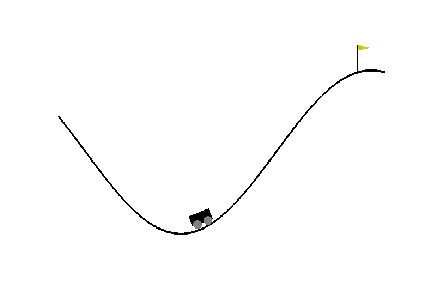
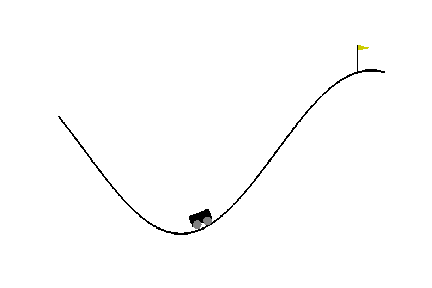
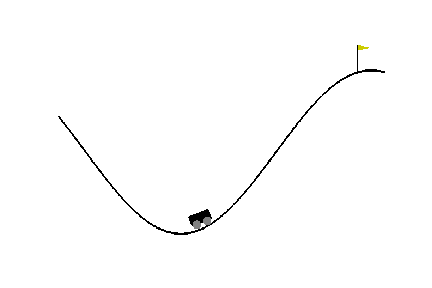
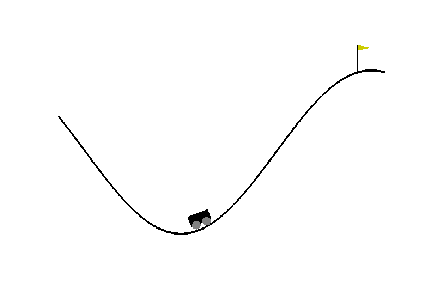
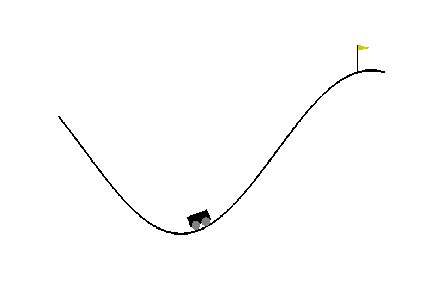
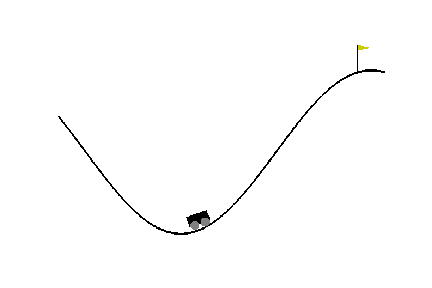
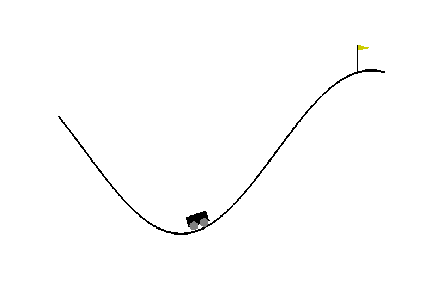
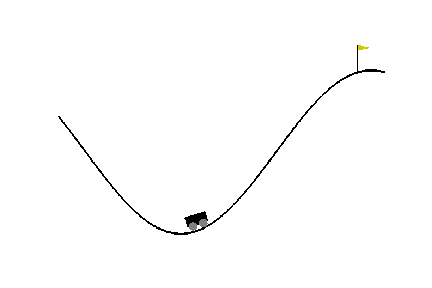
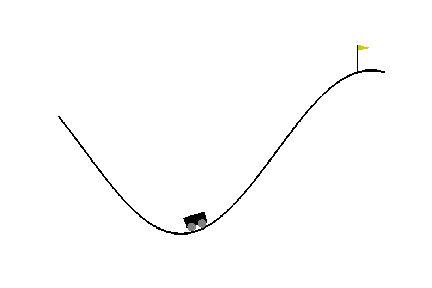
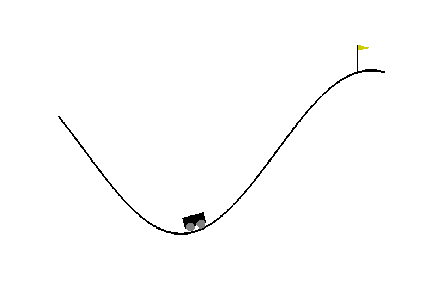
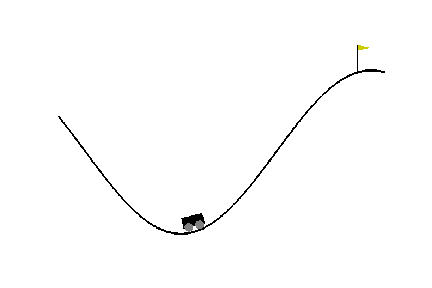
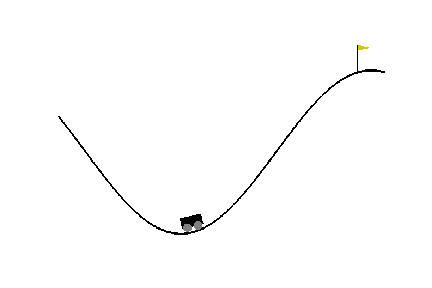
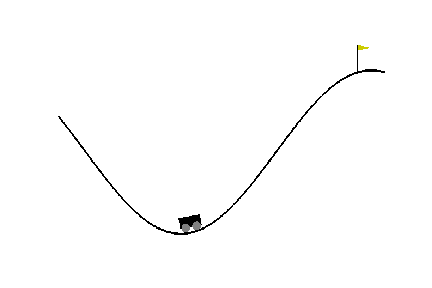
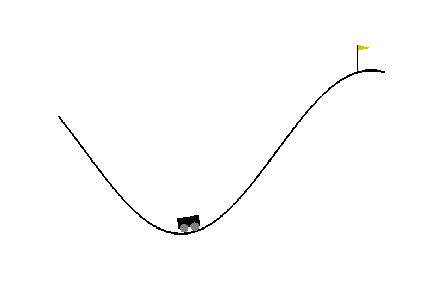
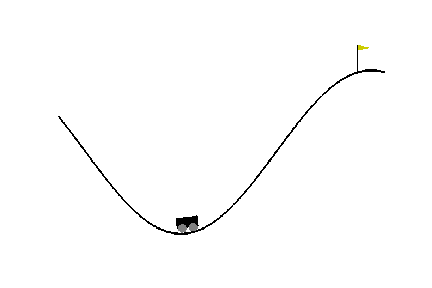
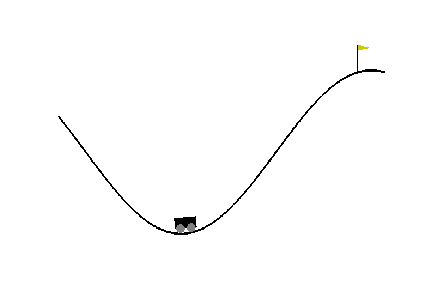
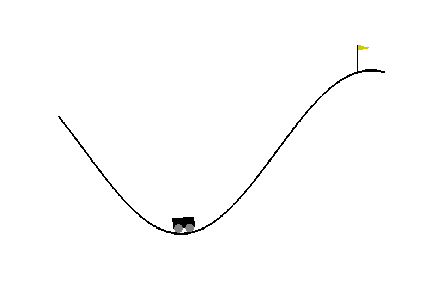
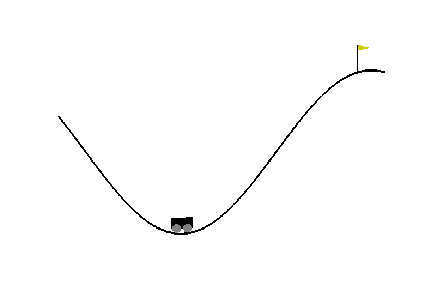
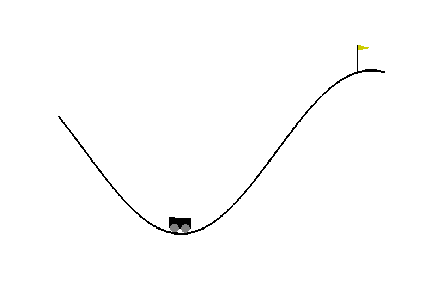
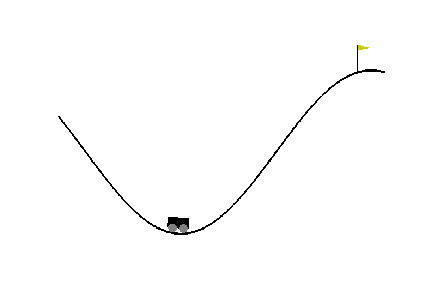
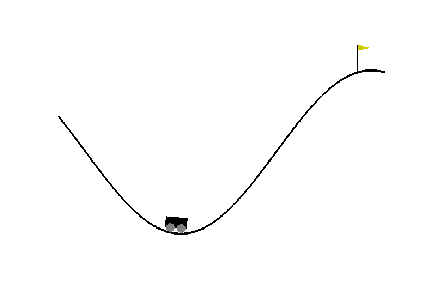
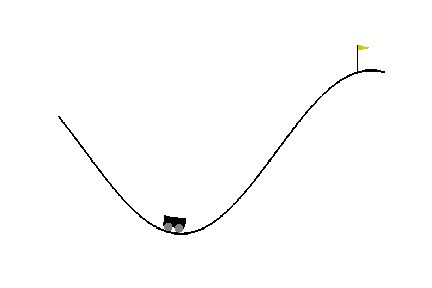
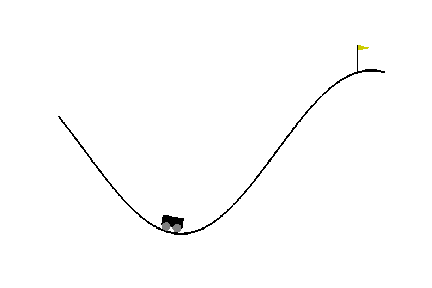
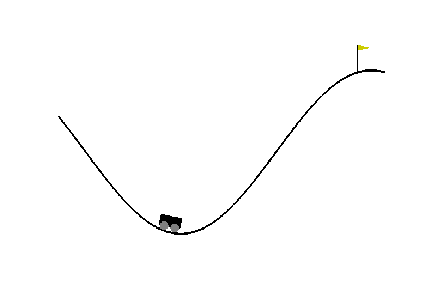
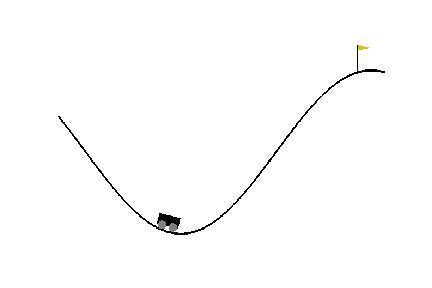
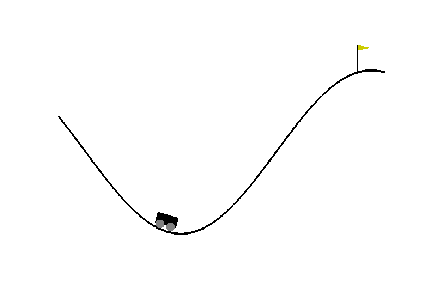
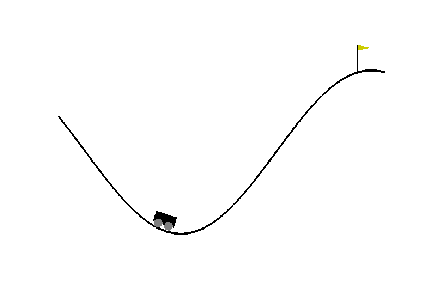
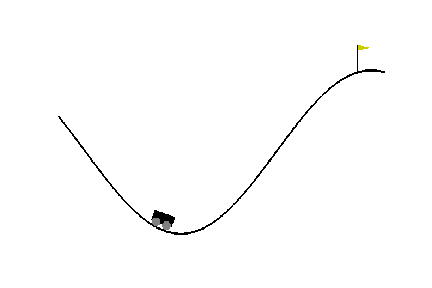
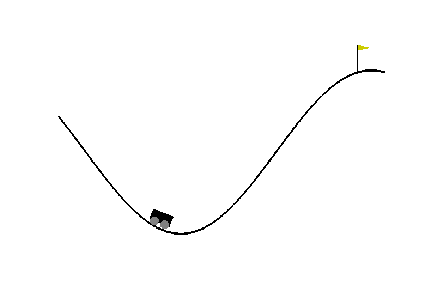
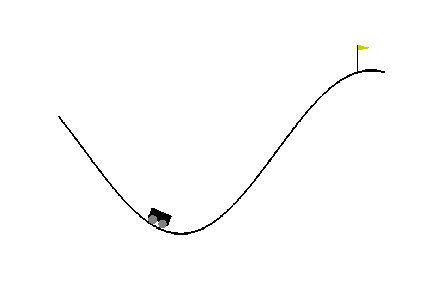
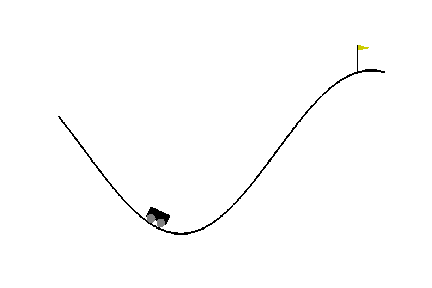
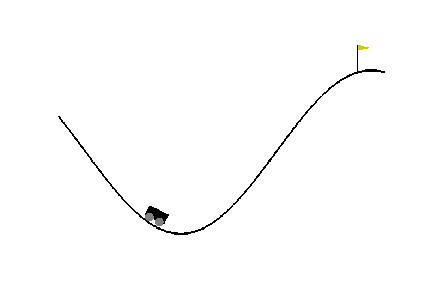
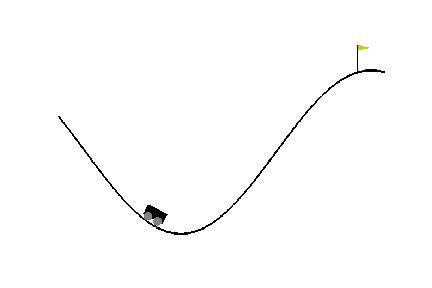
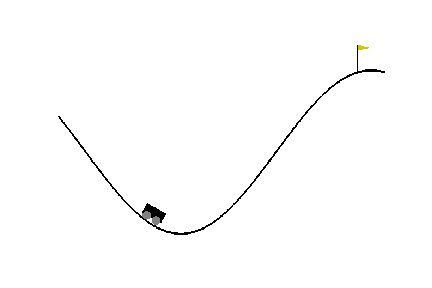
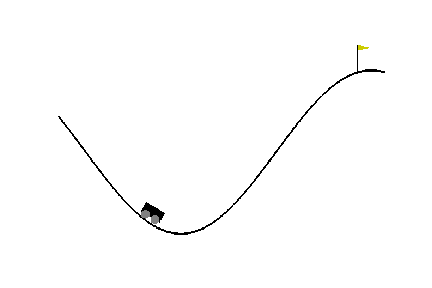
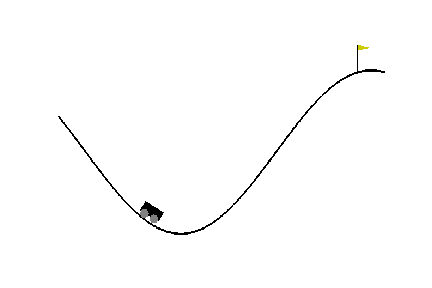
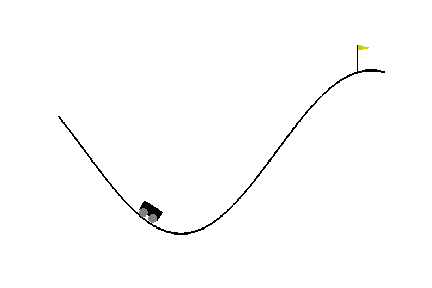
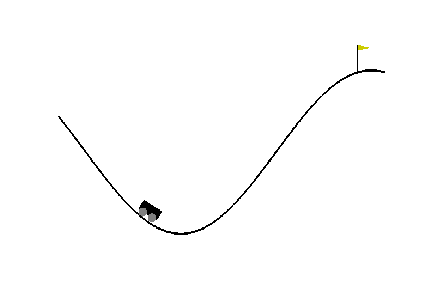
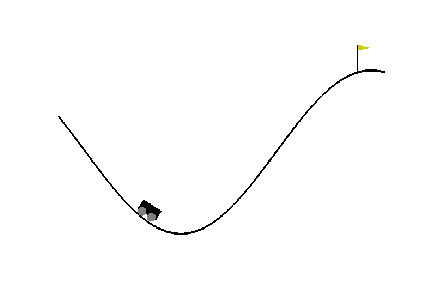
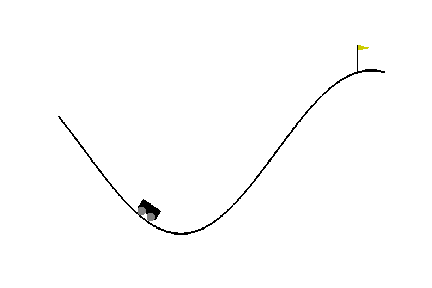
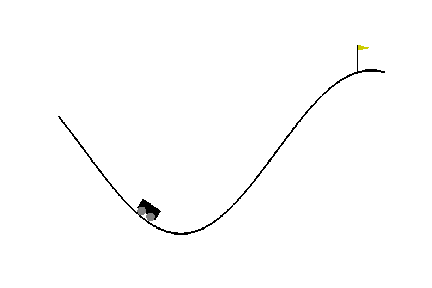
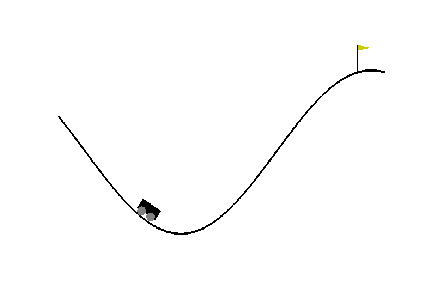
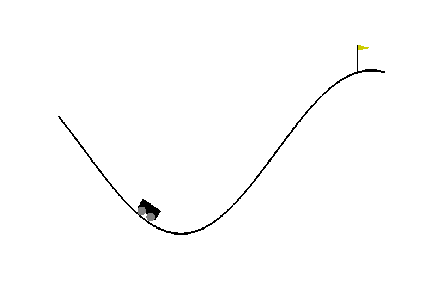
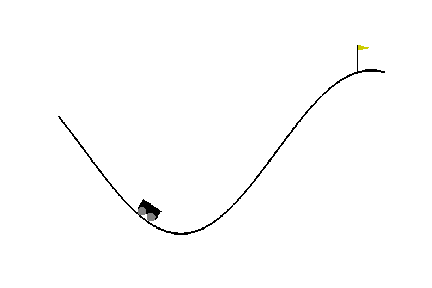
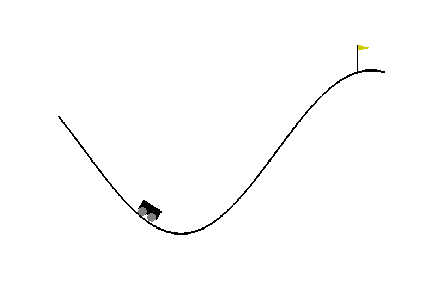
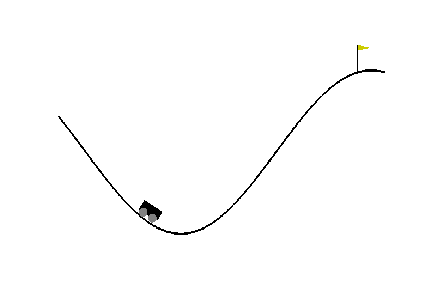
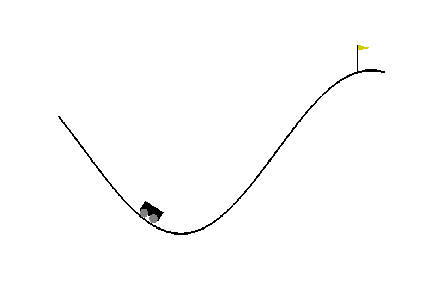
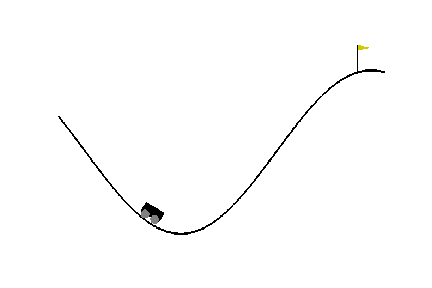
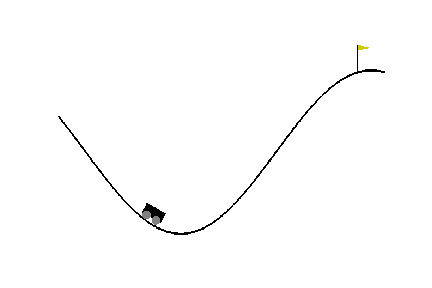
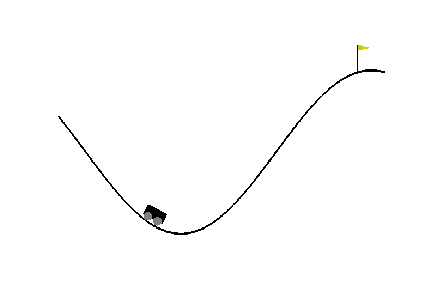
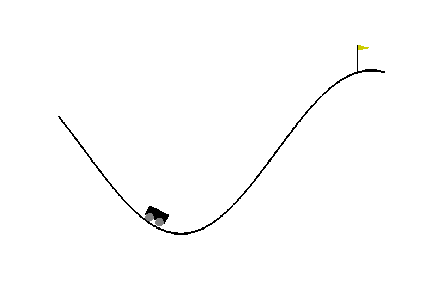
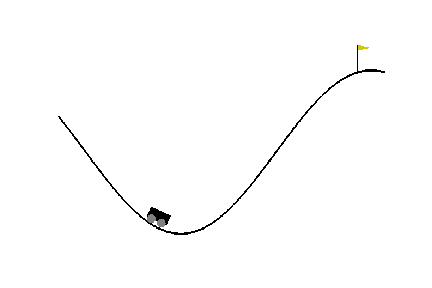
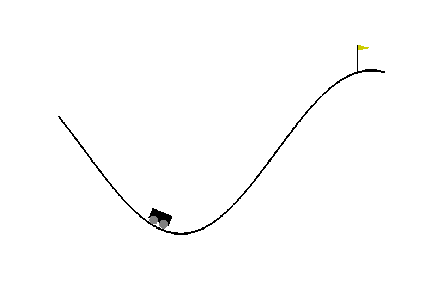
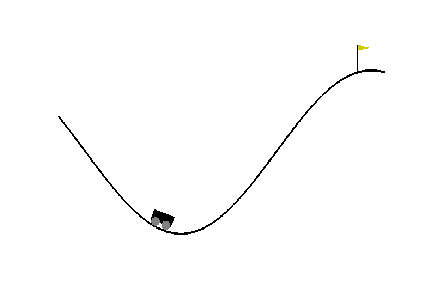
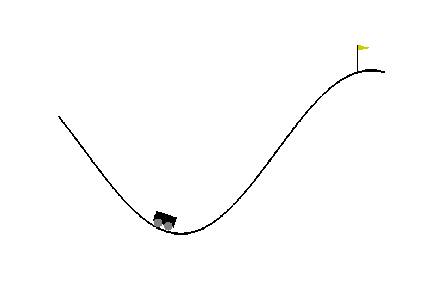
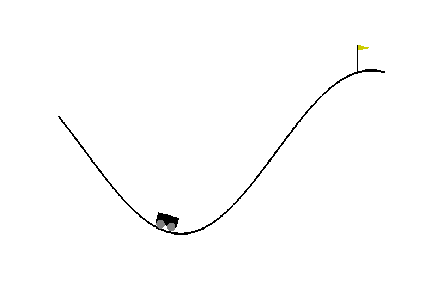
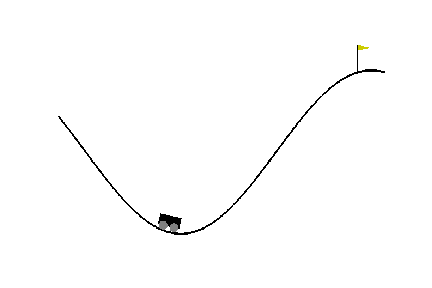
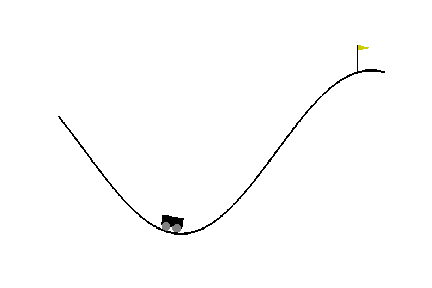
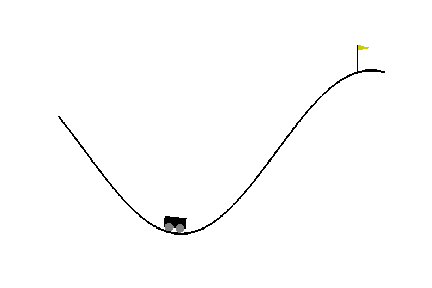
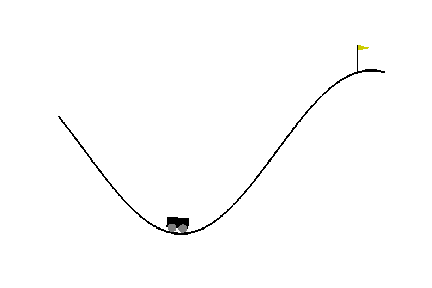
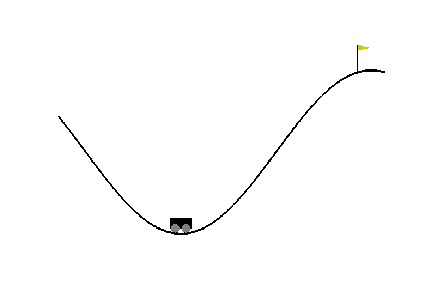
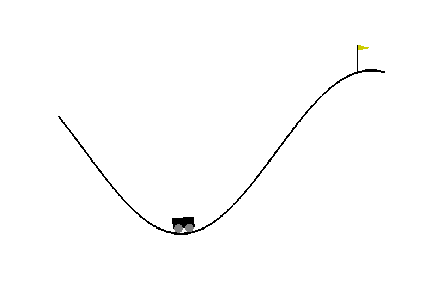
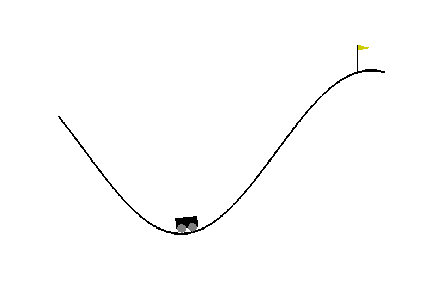
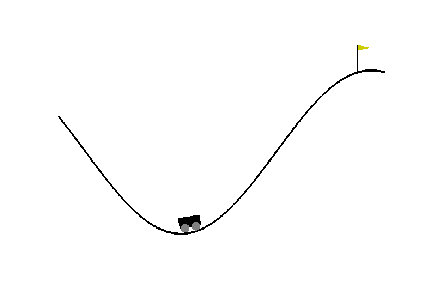
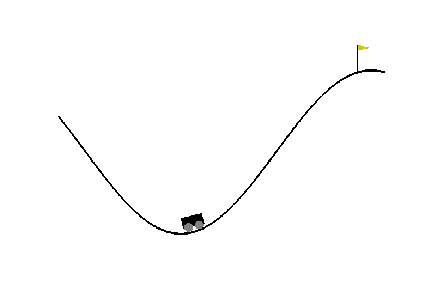
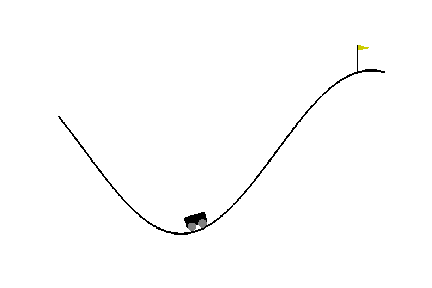
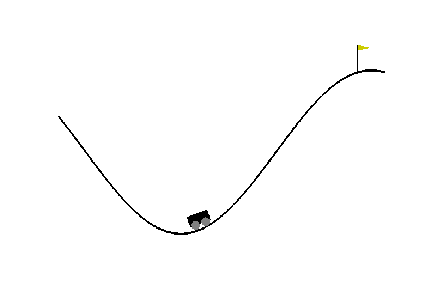
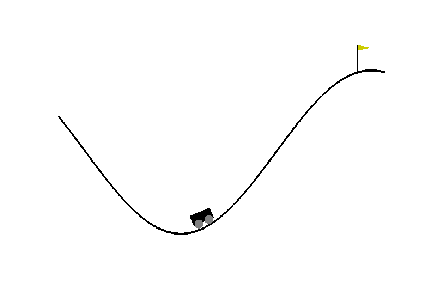
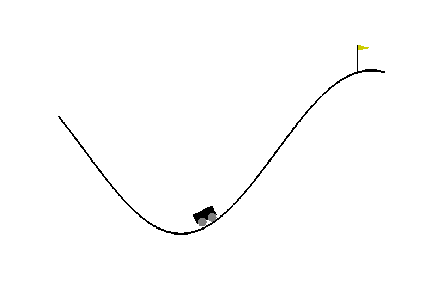
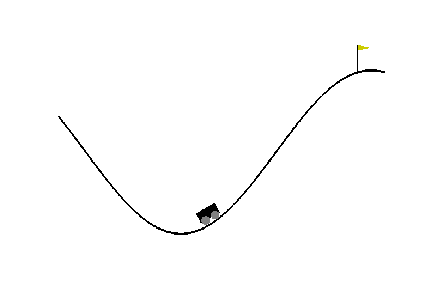
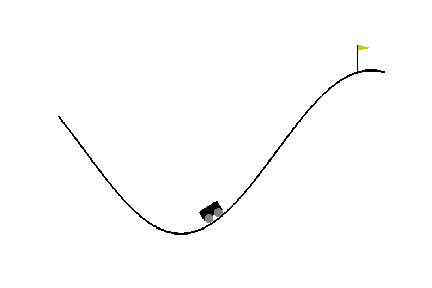
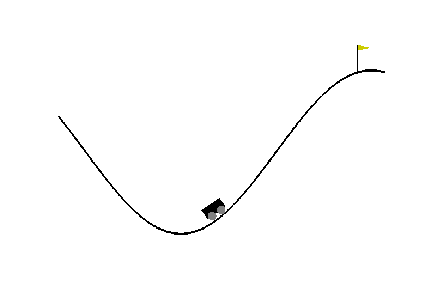
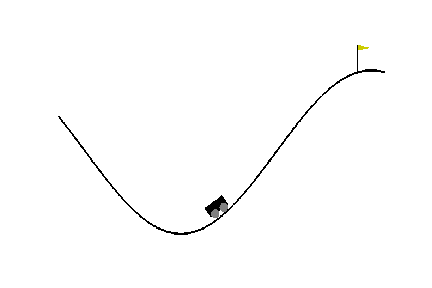
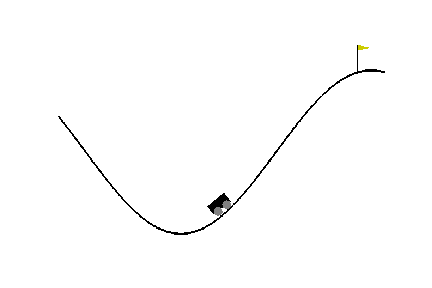
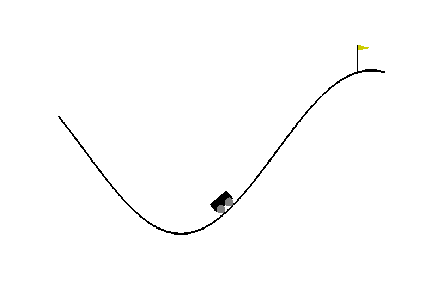
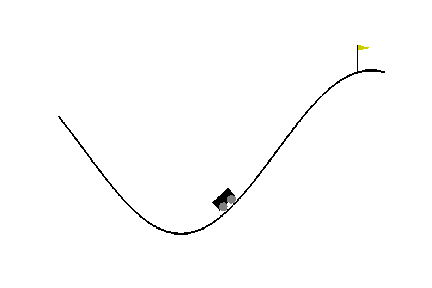
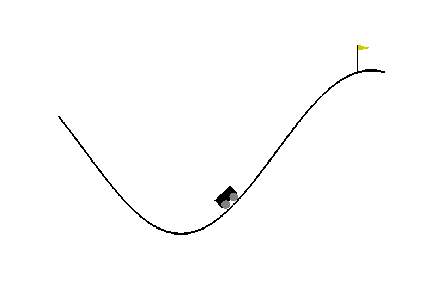
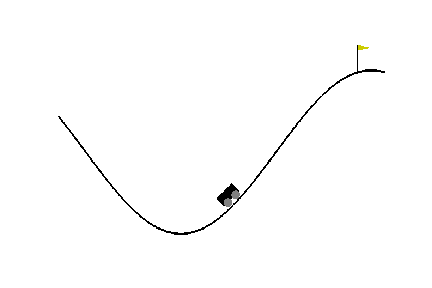
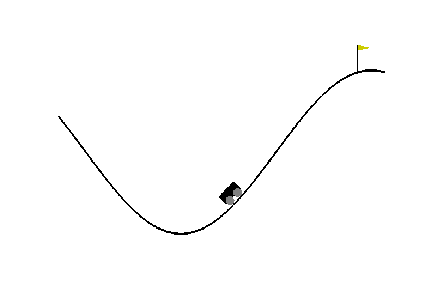
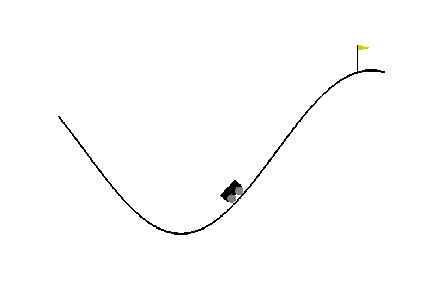
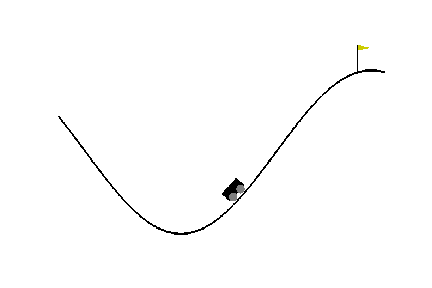
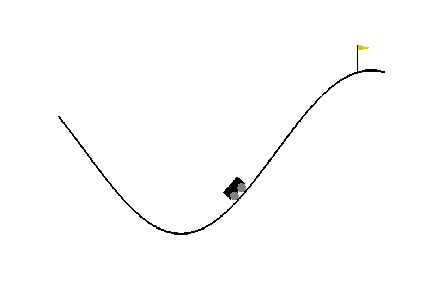
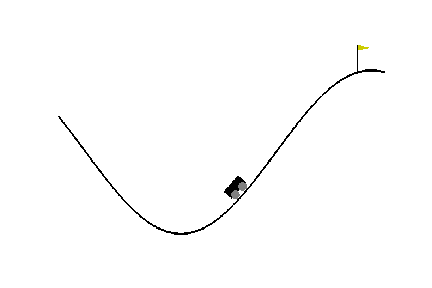
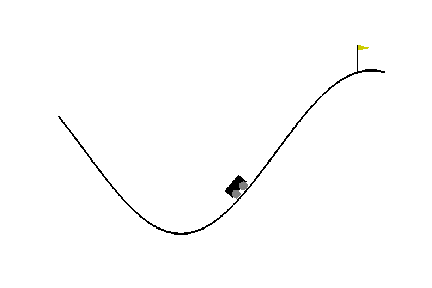
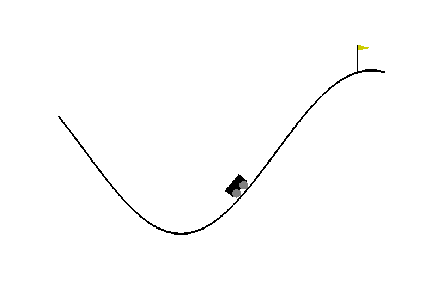
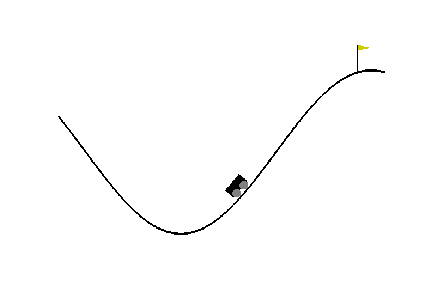
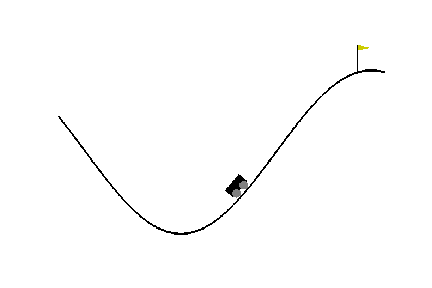
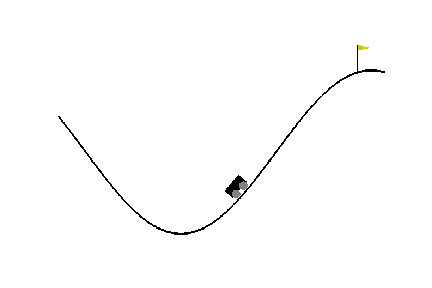
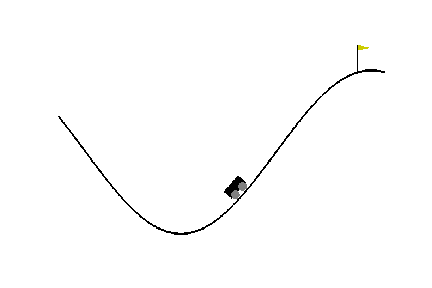
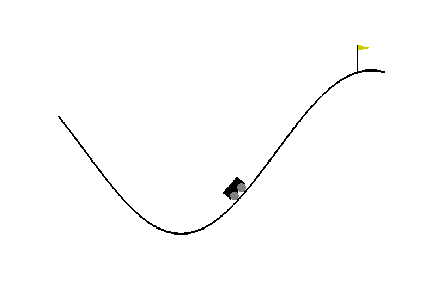
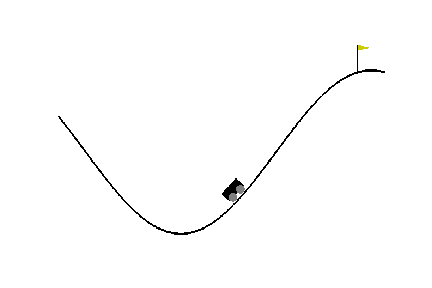
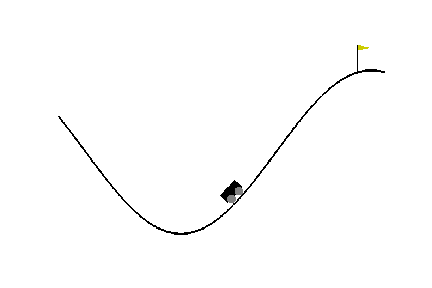
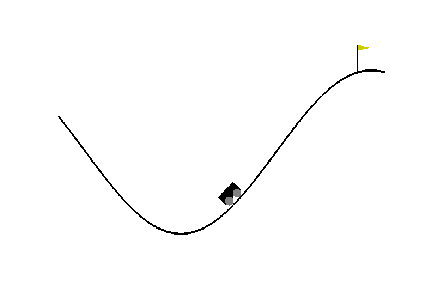
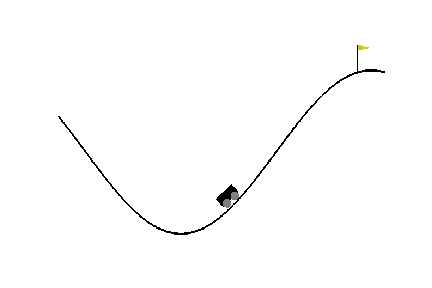
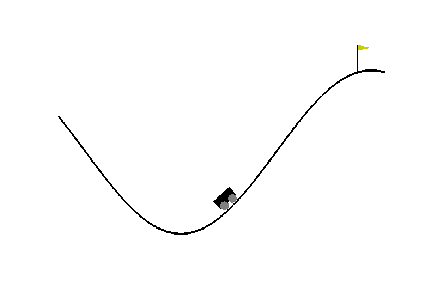
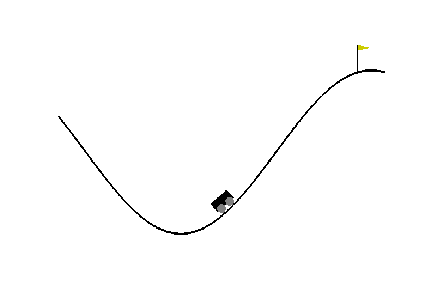
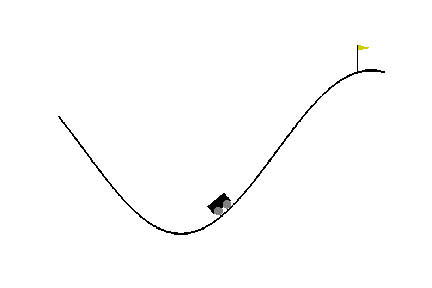
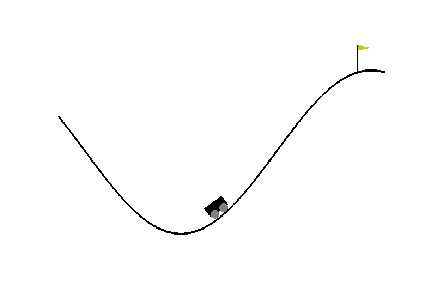
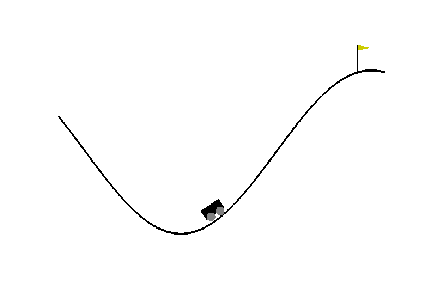
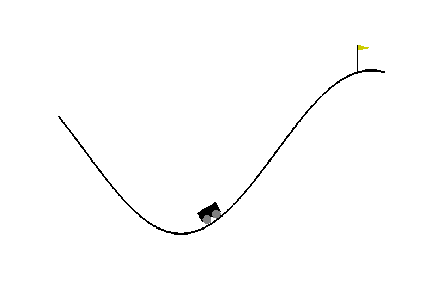
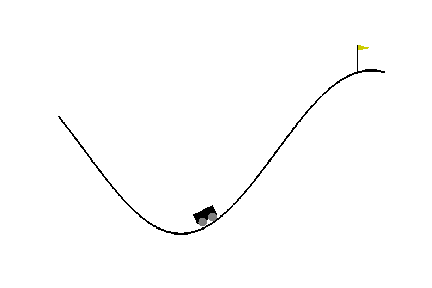
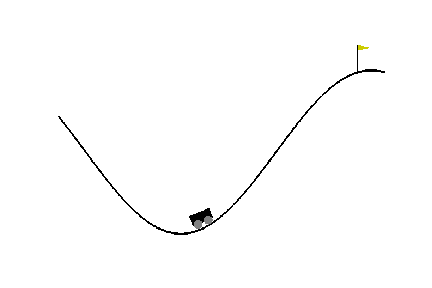
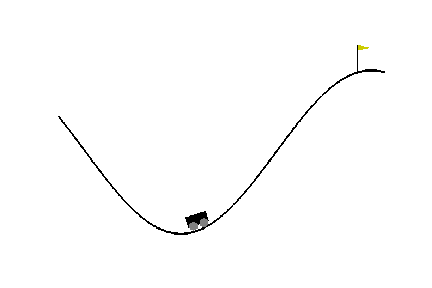
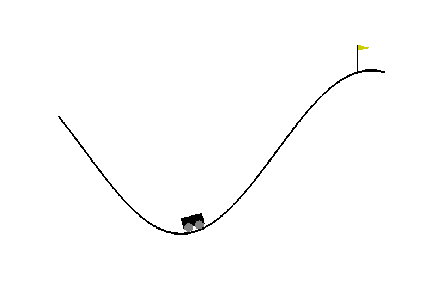
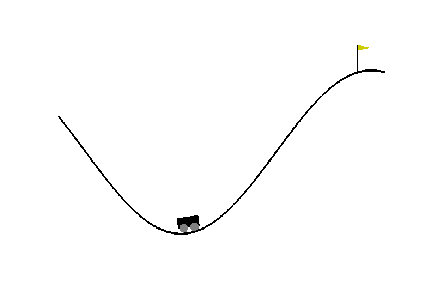
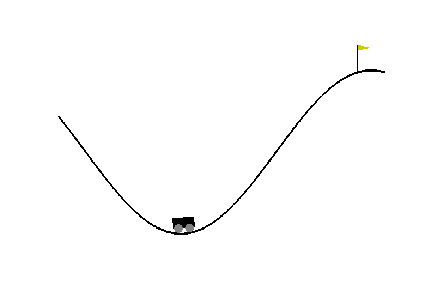
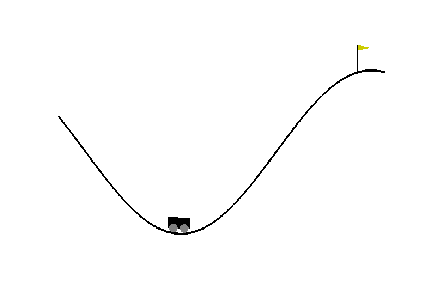
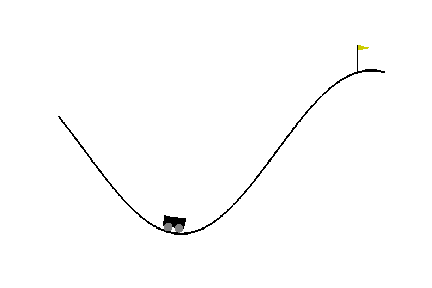
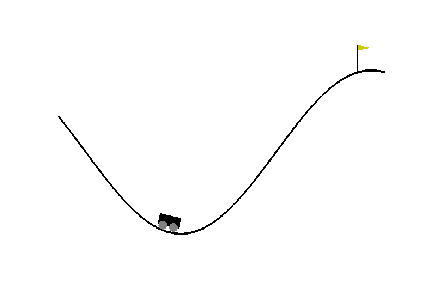
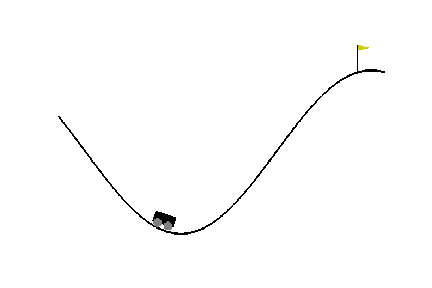
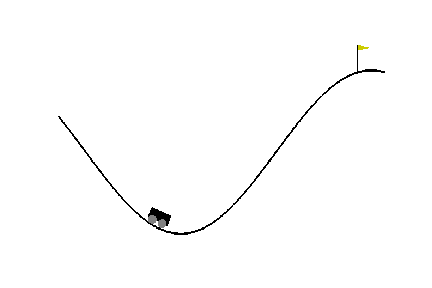
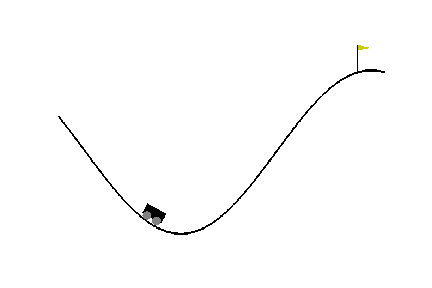
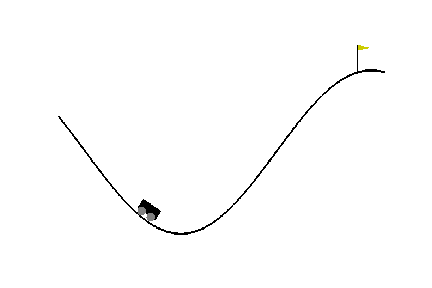
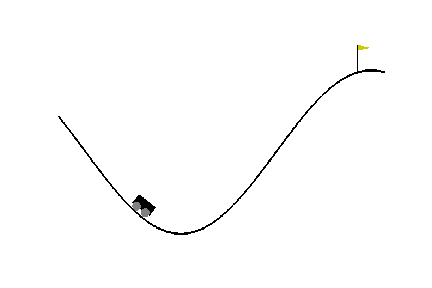
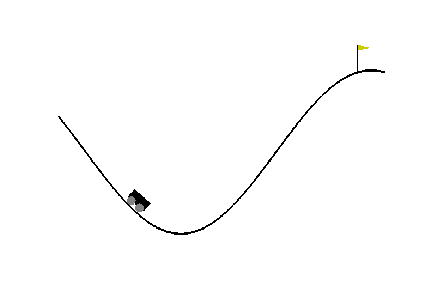
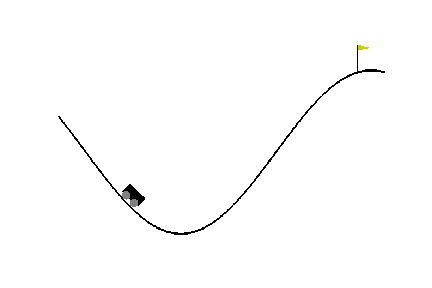
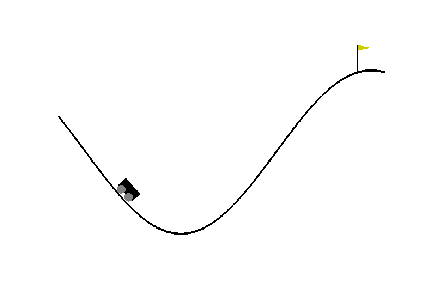
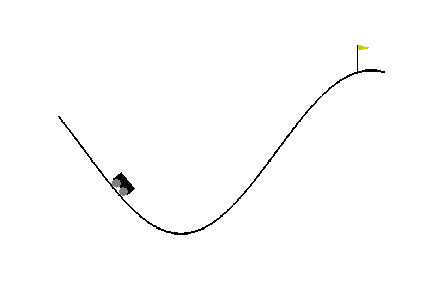
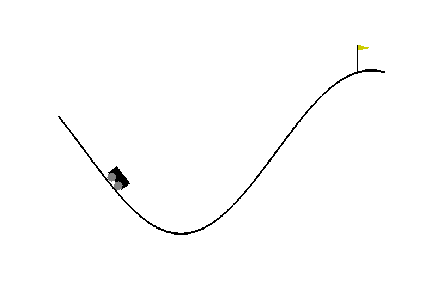
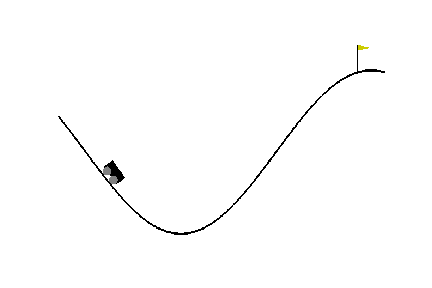
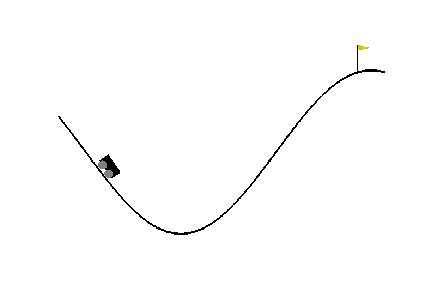
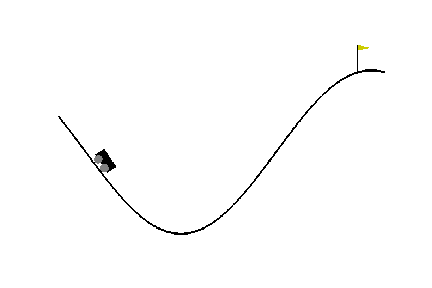
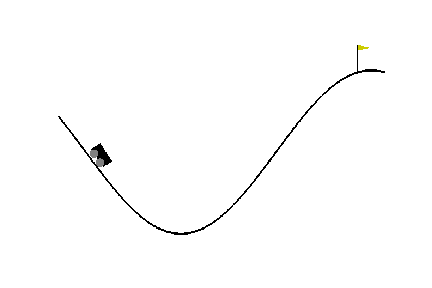
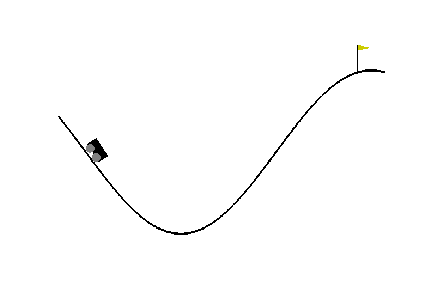
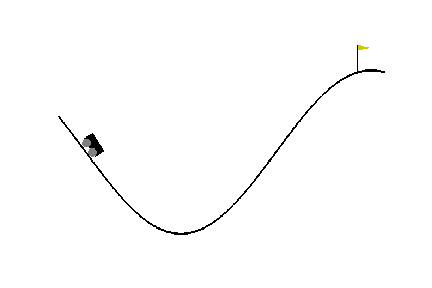
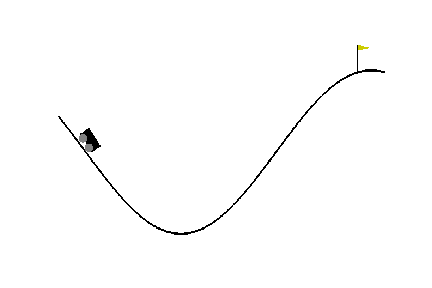
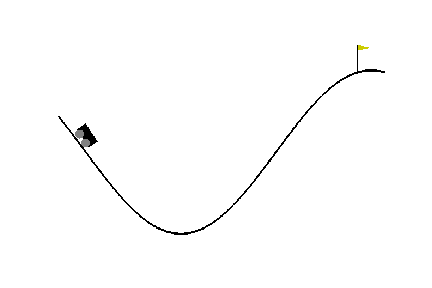
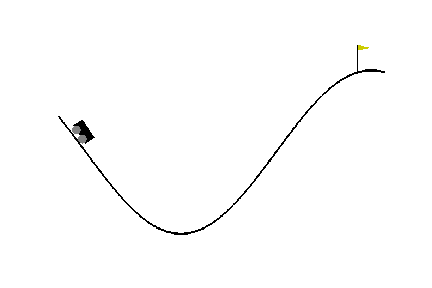
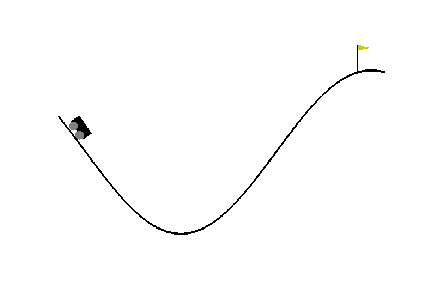
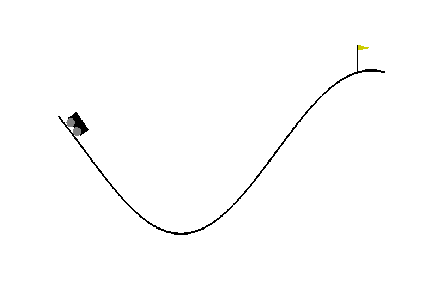
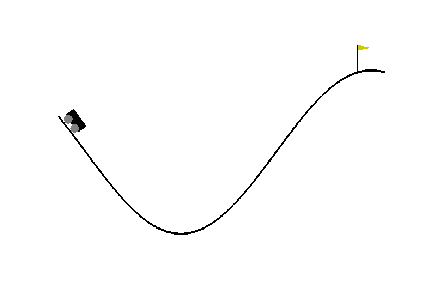
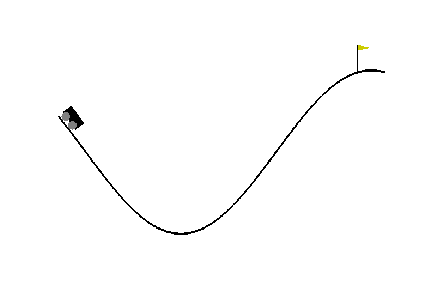
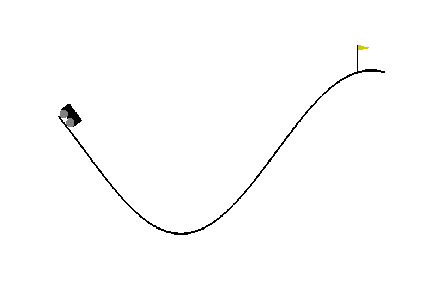
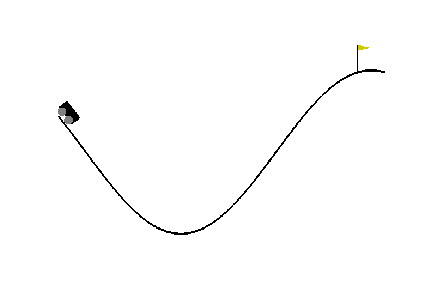
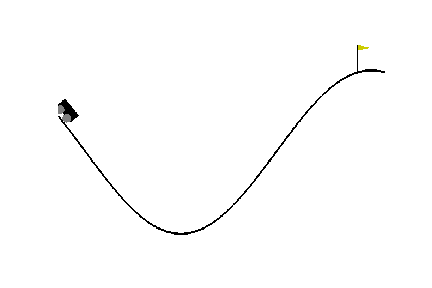
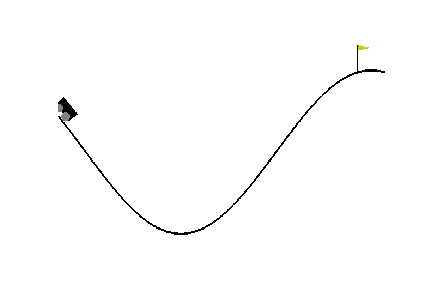
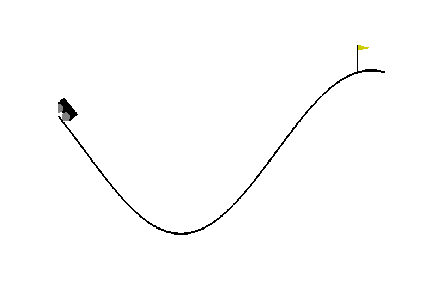
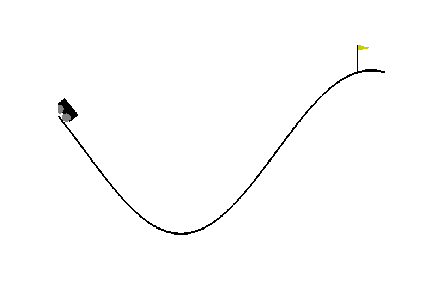
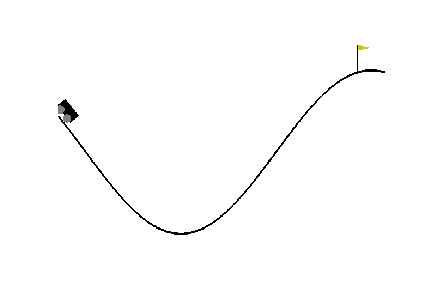
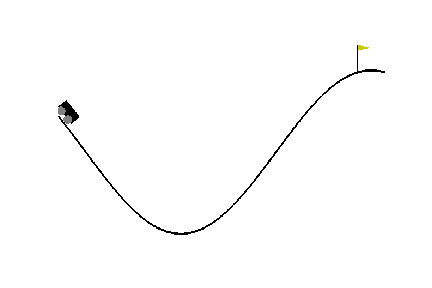
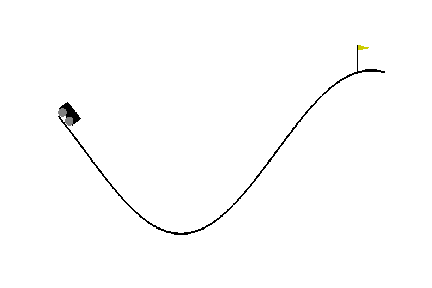
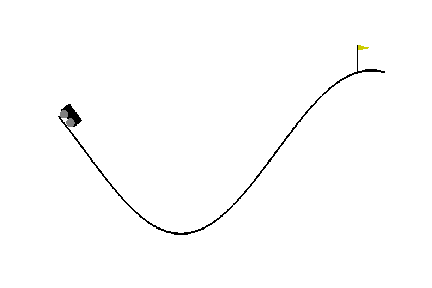
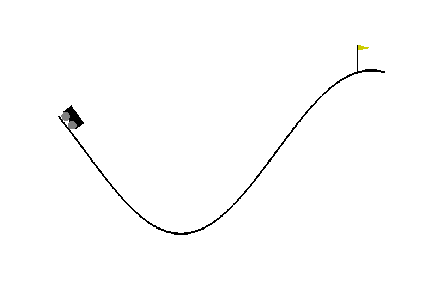
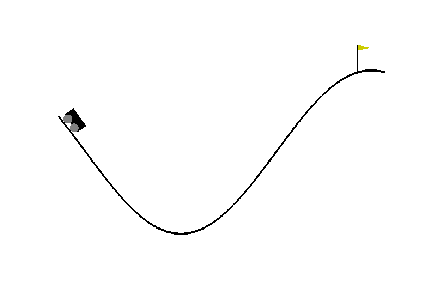
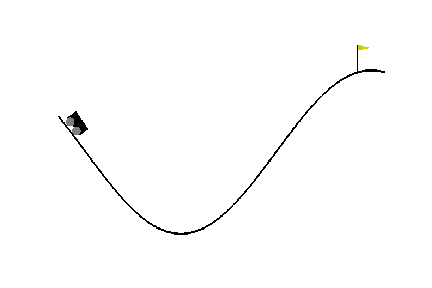
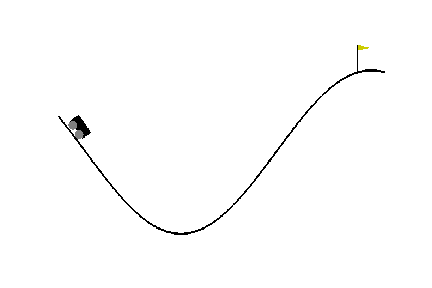
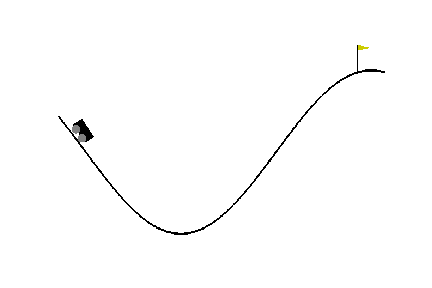
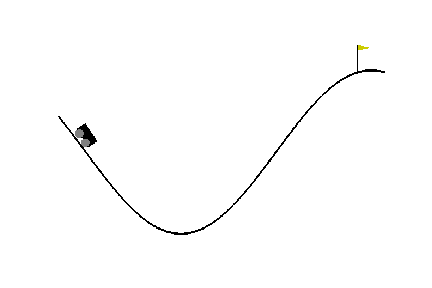
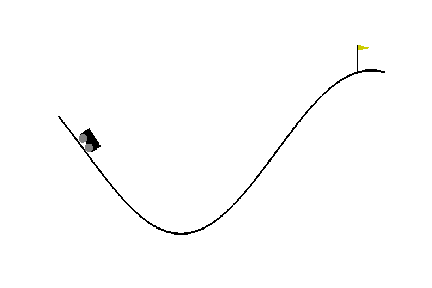
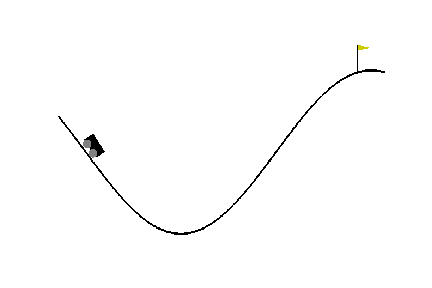
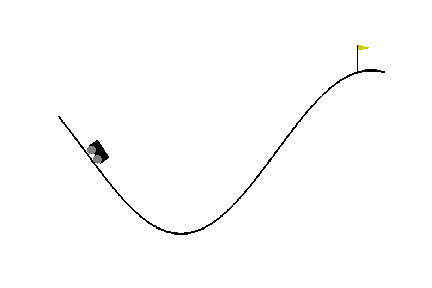
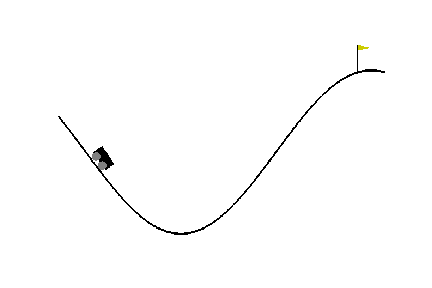
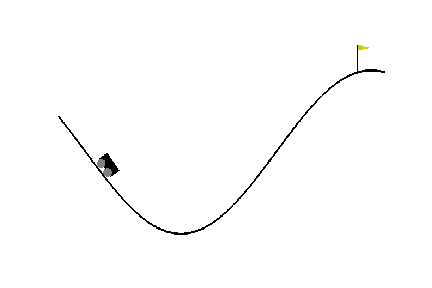
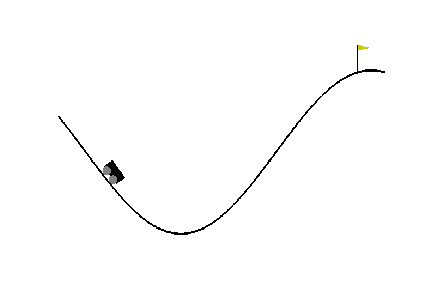
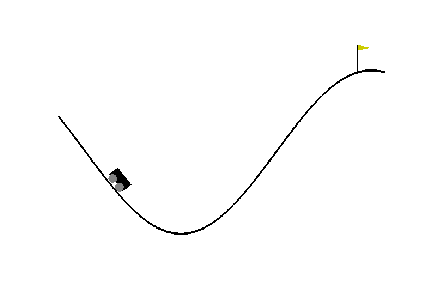
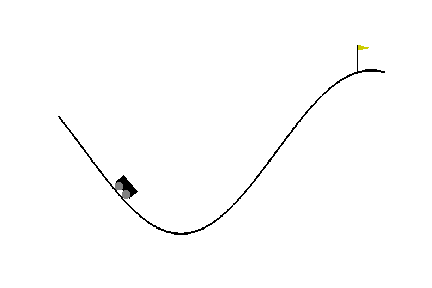
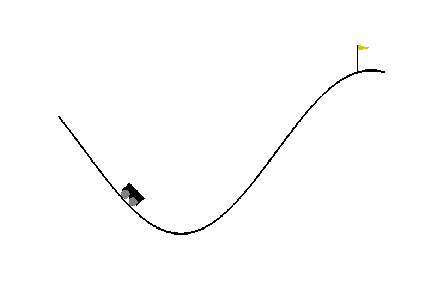
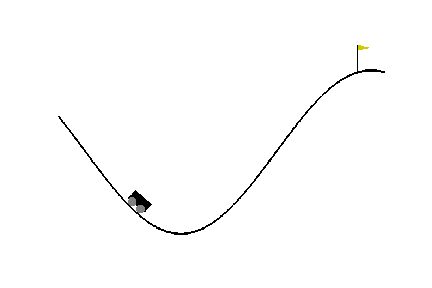
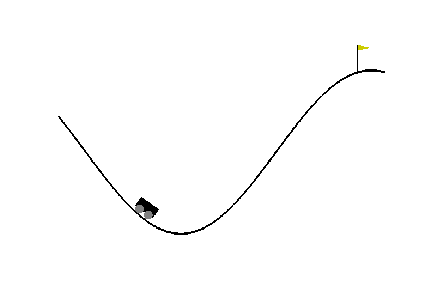
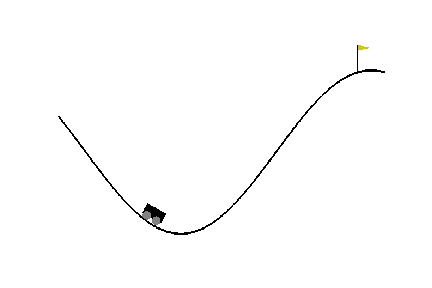
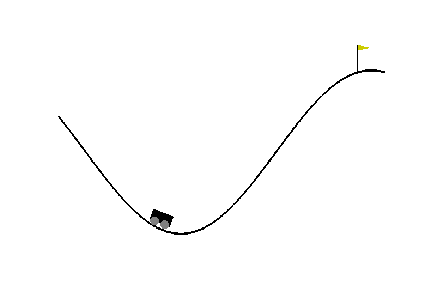
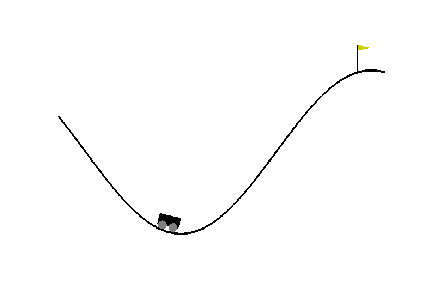
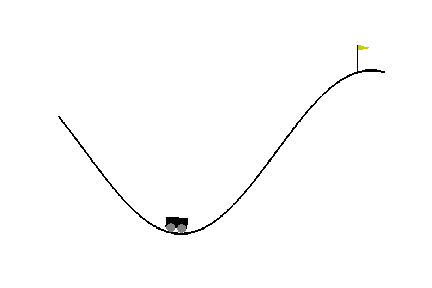
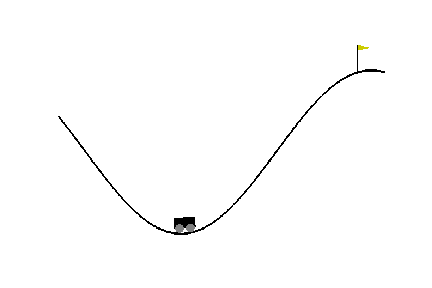
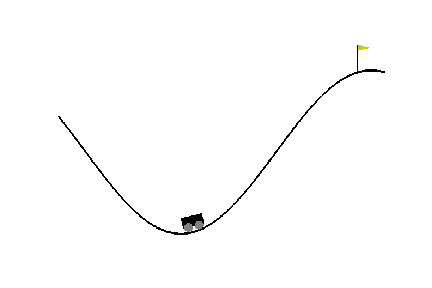
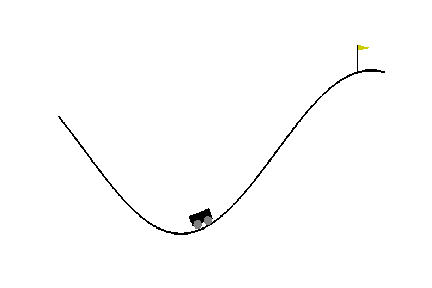
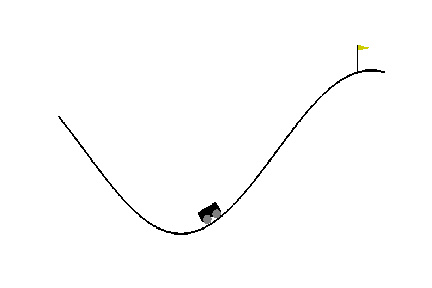
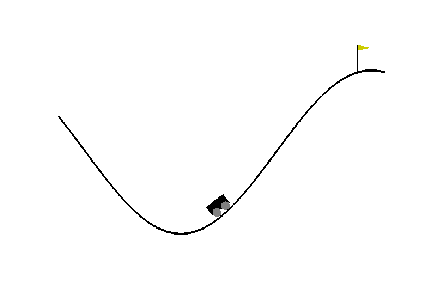
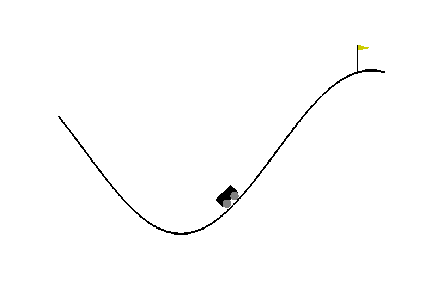
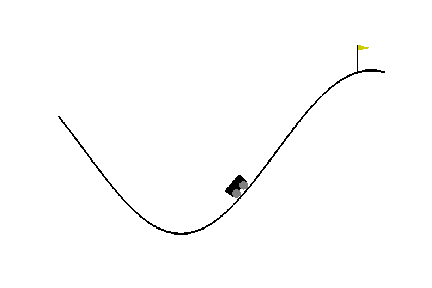
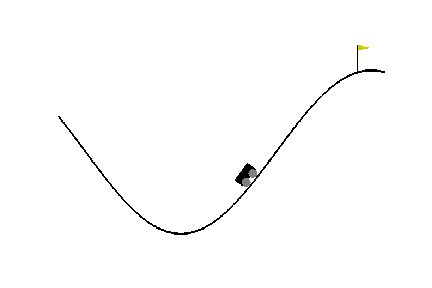
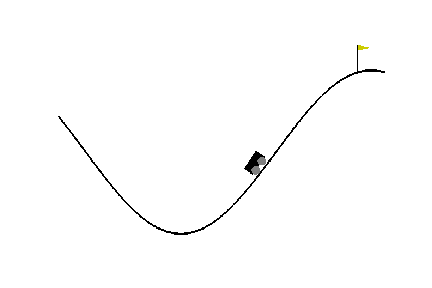
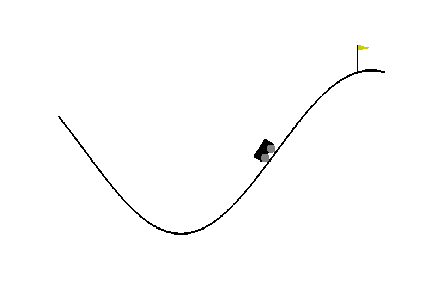
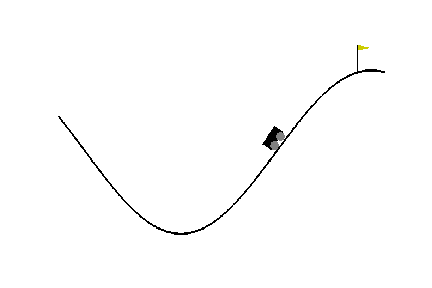
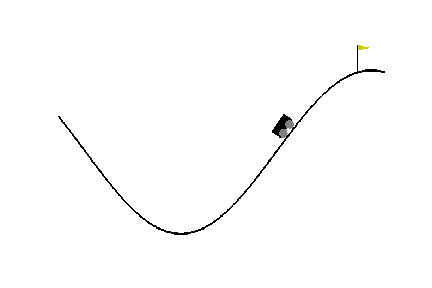
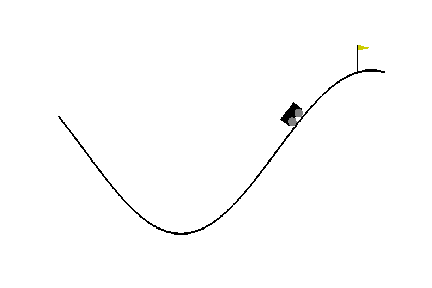
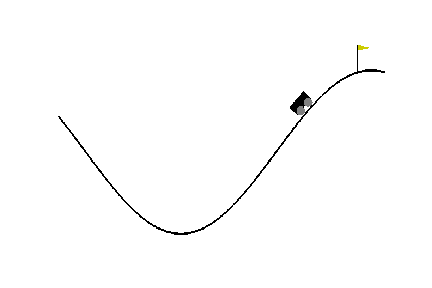
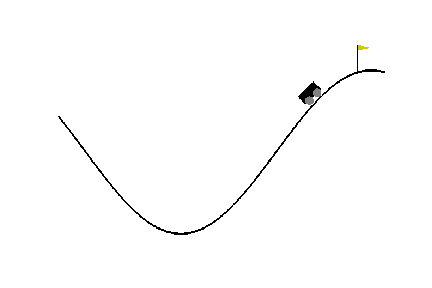
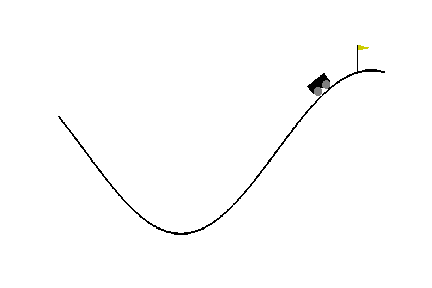
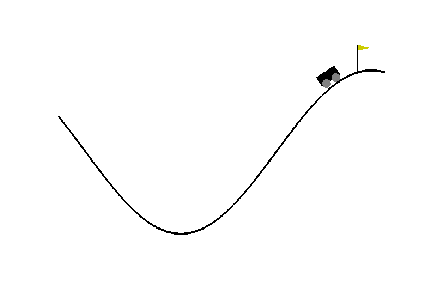
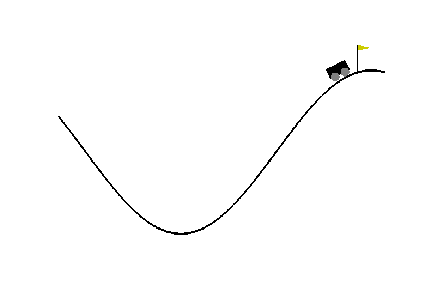
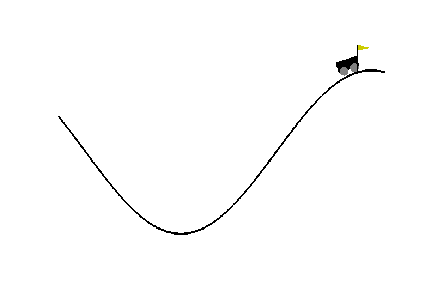

In [11]:
env = gym.make('MountainCarContinuous-v0')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs).reshape((1, -1)).astype(np.float32)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)